In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
import numpy as np
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot

C:\Users\somna\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\somna\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\somna\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\somna\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
(trainX,trainy), (testX,testy) = load_data()

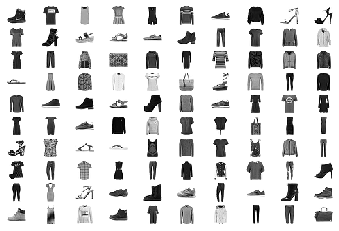

In [3]:
for i in range(100):
    pyplot.subplot(10,10,1+i)
    pyplot.axis('off')
    pyplot.imshow(trainX[i],cmap='gray_r')
pyplot.show()

In [4]:
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(128,(3,3),strides=(2,2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128,(3,3),strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1,activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt,metrics=['accuracy'])
    return model

In [5]:
def define_generator(latent_dim):
    model=Sequential()
    n_nodes = 128*7*7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7,7,128)))
    model.add(Conv2DTranspose(128,(4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128,(4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1,(7,7),activation='tanh',padding='same'))
    return model

In [6]:
def define_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy',optimizer=opt)
    return model

In [7]:
def load_real_samples():
    (trainX, _), (_,_)= load_data()
    X = np.expand_dims(trainX,axis=-1)
    X = X.astype('float32')
    X = (X - 127.5) / 127.5
    return X

In [8]:
def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples,1))
    return X,y

In [9]:
def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim*n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [10]:
def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    y = np.zeros((n_samples, 1))
    return X, y

In [11]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs = 100, n_batch= 128):
    bat_per_epo = int(dataset.shape[0]/n_batch)
    half_batch = int(n_batch/2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _  = d_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    g_model.save('generator.h5')

In [12]:
latent_dim = 100
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
dataset = load_real_samples()
train(generator, discriminator, gan_model, dataset, latent_dim)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
>1, 1/468, d1=0.709, d2=0.694 g=0.693
>1, 2/468, d1=0.632, d2=0.696 g=0.690
>1, 3/468, d1=0.577, d2=0.702 g=0.685
>1, 4/468, d1=0.530, d2=0.711 g=0.676
>1, 5/468, d1=0.477, d2=0.726 g=0.663
>1, 6/468, d1=0.429, d2=0.749 g=0.646
>1, 7/468, d1=0.381, d2=0.777 g=0.624
>1, 8/468, d1=0.351, d2=0.816 g=0.607
>1, 9/468, d1=0.329, d2=0.833 g=0.601
>1, 10/468, d1=0.308, d2=0.821 g=0.623
>1, 11/468, d1=0.322, d2=0.785 g=0.683
>1, 12/468, d1=0.286, d2=0.699 g=0.782
>1, 13/468, d1=0.306, d2=0.605 g=0.906
>1, 14/468, d1=0.331, d2=0.512 g=1.028
>1, 15/468, d1=0.352, d2=0.459 g=1.132
>1, 16/468, d1=0.352, d2=0.429 g=1.117
>1, 17/468, d1=0.305, d2=0.478 g=1.018
>1, 18/468, d1=0.300, d2=0.549 g=0.890
>1, 19/468, d1=0.366, d2=0.626 g=0.774
>1, 20/468, d1=0.339, d2=0.702 g=0.697
>1, 21/468, d1=0.

>1, 185/468, d1=0.643, d2=0.846 g=0.677
>1, 186/468, d1=0.680, d2=0.824 g=0.702
>1, 187/468, d1=0.723, d2=0.785 g=0.758
>1, 188/468, d1=0.745, d2=0.704 g=0.812
>1, 189/468, d1=0.722, d2=0.638 g=0.865
>1, 190/468, d1=0.677, d2=0.584 g=0.940
>1, 191/468, d1=0.679, d2=0.546 g=0.998
>1, 192/468, d1=0.719, d2=0.503 g=1.066
>1, 193/468, d1=0.682, d2=0.487 g=1.104
>1, 194/468, d1=0.729, d2=0.448 g=1.114
>1, 195/468, d1=0.659, d2=0.449 g=1.133
>1, 196/468, d1=0.628, d2=0.436 g=1.160
>1, 197/468, d1=0.570, d2=0.417 g=1.159
>1, 198/468, d1=0.595, d2=0.410 g=1.181
>1, 199/468, d1=0.611, d2=0.447 g=1.129
>1, 200/468, d1=0.536, d2=0.443 g=1.132
>1, 201/468, d1=0.633, d2=0.465 g=1.039
>1, 202/468, d1=0.581, d2=0.551 g=0.964
>1, 203/468, d1=0.544, d2=0.588 g=0.926
>1, 204/468, d1=0.622, d2=0.668 g=0.844
>1, 205/468, d1=0.573, d2=0.721 g=0.817
>1, 206/468, d1=0.516, d2=0.746 g=0.805
>1, 207/468, d1=0.607, d2=0.735 g=0.775
>1, 208/468, d1=0.685, d2=0.794 g=0.746
>1, 209/468, d1=0.737, d2=0.787 g=0.779


>1, 391/468, d1=0.715, d2=0.679 g=0.774
>1, 392/468, d1=0.673, d2=0.685 g=0.738
>1, 393/468, d1=0.731, d2=0.707 g=0.778
>1, 394/468, d1=0.714, d2=0.696 g=0.759
>1, 395/468, d1=0.688, d2=0.667 g=0.773
>1, 396/468, d1=0.697, d2=0.643 g=0.789
>1, 397/468, d1=0.690, d2=0.658 g=0.806
>1, 398/468, d1=0.685, d2=0.621 g=0.815
>1, 399/468, d1=0.696, d2=0.628 g=0.842
>1, 400/468, d1=0.691, d2=0.599 g=0.847
>1, 401/468, d1=0.675, d2=0.589 g=0.868
>1, 402/468, d1=0.660, d2=0.585 g=0.870
>1, 403/468, d1=0.660, d2=0.592 g=0.864
>1, 404/468, d1=0.693, d2=0.599 g=0.868
>1, 405/468, d1=0.677, d2=0.588 g=0.837
>1, 406/468, d1=0.670, d2=0.643 g=0.818
>1, 407/468, d1=0.707, d2=0.681 g=0.776
>1, 408/468, d1=0.684, d2=0.695 g=0.755
>1, 409/468, d1=0.703, d2=0.690 g=0.697
>1, 410/468, d1=0.706, d2=0.730 g=0.723
>1, 411/468, d1=0.713, d2=0.716 g=0.704
>1, 412/468, d1=0.686, d2=0.736 g=0.712
>1, 413/468, d1=0.697, d2=0.742 g=0.702
>1, 414/468, d1=0.710, d2=0.723 g=0.751
>1, 415/468, d1=0.712, d2=0.706 g=0.750


>2, 131/468, d1=0.669, d2=0.700 g=0.769
>2, 132/468, d1=0.679, d2=0.681 g=0.763
>2, 133/468, d1=0.688, d2=0.681 g=0.763
>2, 134/468, d1=0.693, d2=0.685 g=0.738
>2, 135/468, d1=0.682, d2=0.703 g=0.733
>2, 136/468, d1=0.699, d2=0.688 g=0.749
>2, 137/468, d1=0.676, d2=0.694 g=0.734
>2, 138/468, d1=0.676, d2=0.698 g=0.748
>2, 139/468, d1=0.703, d2=0.678 g=0.742
>2, 140/468, d1=0.692, d2=0.673 g=0.745
>2, 141/468, d1=0.677, d2=0.678 g=0.752
>2, 142/468, d1=0.660, d2=0.687 g=0.741
>2, 143/468, d1=0.699, d2=0.703 g=0.753
>2, 144/468, d1=0.674, d2=0.680 g=0.765
>2, 145/468, d1=0.682, d2=0.675 g=0.754
>2, 146/468, d1=0.659, d2=0.675 g=0.758
>2, 147/468, d1=0.651, d2=0.691 g=0.760
>2, 148/468, d1=0.676, d2=0.670 g=0.761
>2, 149/468, d1=0.678, d2=0.683 g=0.759
>2, 150/468, d1=0.629, d2=0.672 g=0.748
>2, 151/468, d1=0.692, d2=0.716 g=0.739
>2, 152/468, d1=0.677, d2=0.701 g=0.730
>2, 153/468, d1=0.672, d2=0.704 g=0.728
>2, 154/468, d1=0.716, d2=0.741 g=0.712
>2, 155/468, d1=0.677, d2=0.703 g=0.712


>2, 337/468, d1=0.690, d2=0.762 g=0.711
>2, 338/468, d1=0.711, d2=0.745 g=0.705
>2, 339/468, d1=0.690, d2=0.690 g=0.727
>2, 340/468, d1=0.711, d2=0.665 g=0.764
>2, 341/468, d1=0.688, d2=0.668 g=0.785
>2, 342/468, d1=0.719, d2=0.656 g=0.827
>2, 343/468, d1=0.707, d2=0.592 g=0.855
>2, 344/468, d1=0.712, d2=0.578 g=0.891
>2, 345/468, d1=0.723, d2=0.600 g=0.912
>2, 346/468, d1=0.727, d2=0.565 g=0.892
>2, 347/468, d1=0.700, d2=0.609 g=0.853
>2, 348/468, d1=0.731, d2=0.619 g=0.823
>2, 349/468, d1=0.693, d2=0.637 g=0.798
>2, 350/468, d1=0.677, d2=0.684 g=0.759
>2, 351/468, d1=0.680, d2=0.715 g=0.726
>2, 352/468, d1=0.680, d2=0.747 g=0.703
>2, 353/468, d1=0.657, d2=0.771 g=0.665
>2, 354/468, d1=0.691, d2=0.750 g=0.671
>2, 355/468, d1=0.673, d2=0.751 g=0.673
>2, 356/468, d1=0.659, d2=0.740 g=0.692
>2, 357/468, d1=0.651, d2=0.720 g=0.692
>2, 358/468, d1=0.659, d2=0.706 g=0.702
>2, 359/468, d1=0.669, d2=0.705 g=0.713
>2, 360/468, d1=0.645, d2=0.694 g=0.721
>2, 361/468, d1=0.623, d2=0.679 g=0.740


>3, 77/468, d1=0.676, d2=0.649 g=0.776
>3, 78/468, d1=0.696, d2=0.668 g=0.761
>3, 79/468, d1=0.674, d2=0.663 g=0.770
>3, 80/468, d1=0.674, d2=0.655 g=0.776
>3, 81/468, d1=0.674, d2=0.633 g=0.807
>3, 82/468, d1=0.698, d2=0.634 g=0.801
>3, 83/468, d1=0.682, d2=0.623 g=0.814
>3, 84/468, d1=0.699, d2=0.625 g=0.833
>3, 85/468, d1=0.686, d2=0.620 g=0.795
>3, 86/468, d1=0.694, d2=0.625 g=0.796
>3, 87/468, d1=0.707, d2=0.649 g=0.781
>3, 88/468, d1=0.697, d2=0.666 g=0.766
>3, 89/468, d1=0.680, d2=0.679 g=0.734
>3, 90/468, d1=0.700, d2=0.714 g=0.728
>3, 91/468, d1=0.686, d2=0.706 g=0.719
>3, 92/468, d1=0.704, d2=0.693 g=0.724
>3, 93/468, d1=0.674, d2=0.690 g=0.722
>3, 94/468, d1=0.673, d2=0.686 g=0.723
>3, 95/468, d1=0.687, d2=0.692 g=0.720
>3, 96/468, d1=0.684, d2=0.700 g=0.728
>3, 97/468, d1=0.680, d2=0.689 g=0.720
>3, 98/468, d1=0.672, d2=0.693 g=0.713
>3, 99/468, d1=0.677, d2=0.699 g=0.727
>3, 100/468, d1=0.687, d2=0.707 g=0.720
>3, 101/468, d1=0.673, d2=0.683 g=0.706
>3, 102/468, d1=0.668, 

>3, 283/468, d1=0.698, d2=0.691 g=0.751
>3, 284/468, d1=0.705, d2=0.672 g=0.755
>3, 285/468, d1=0.711, d2=0.668 g=0.768
>3, 286/468, d1=0.703, d2=0.670 g=0.758
>3, 287/468, d1=0.703, d2=0.664 g=0.754
>3, 288/468, d1=0.690, d2=0.668 g=0.745
>3, 289/468, d1=0.697, d2=0.659 g=0.748
>3, 290/468, d1=0.677, d2=0.664 g=0.761
>3, 291/468, d1=0.704, d2=0.673 g=0.771
>3, 292/468, d1=0.706, d2=0.658 g=0.779
>3, 293/468, d1=0.694, d2=0.649 g=0.765
>3, 294/468, d1=0.718, d2=0.656 g=0.772
>3, 295/468, d1=0.708, d2=0.661 g=0.756
>3, 296/468, d1=0.694, d2=0.651 g=0.775
>3, 297/468, d1=0.713, d2=0.649 g=0.782
>3, 298/468, d1=0.708, d2=0.648 g=0.777
>3, 299/468, d1=0.694, d2=0.656 g=0.790
>3, 300/468, d1=0.701, d2=0.648 g=0.771
>3, 301/468, d1=0.703, d2=0.647 g=0.775
>3, 302/468, d1=0.672, d2=0.644 g=0.781
>3, 303/468, d1=0.681, d2=0.664 g=0.779
>3, 304/468, d1=0.701, d2=0.644 g=0.786
>3, 305/468, d1=0.676, d2=0.639 g=0.780
>3, 306/468, d1=0.687, d2=0.631 g=0.772
>3, 307/468, d1=0.680, d2=0.650 g=0.766


>4, 21/468, d1=0.711, d2=0.672 g=0.767
>4, 22/468, d1=0.704, d2=0.650 g=0.788
>4, 23/468, d1=0.712, d2=0.654 g=0.798
>4, 24/468, d1=0.708, d2=0.638 g=0.810
>4, 25/468, d1=0.704, d2=0.633 g=0.805
>4, 26/468, d1=0.710, d2=0.628 g=0.800
>4, 27/468, d1=0.706, d2=0.626 g=0.787
>4, 28/468, d1=0.692, d2=0.636 g=0.783
>4, 29/468, d1=0.721, d2=0.653 g=0.770
>4, 30/468, d1=0.696, d2=0.667 g=0.780
>4, 31/468, d1=0.681, d2=0.656 g=0.769
>4, 32/468, d1=0.658, d2=0.650 g=0.785
>4, 33/468, d1=0.681, d2=0.659 g=0.786
>4, 34/468, d1=0.670, d2=0.635 g=0.777
>4, 35/468, d1=0.669, d2=0.651 g=0.759
>4, 36/468, d1=0.687, d2=0.704 g=0.743
>4, 37/468, d1=0.679, d2=0.699 g=0.752
>4, 38/468, d1=0.678, d2=0.691 g=0.783
>4, 39/468, d1=0.653, d2=0.654 g=0.779
>4, 40/468, d1=0.706, d2=0.649 g=0.805
>4, 41/468, d1=0.699, d2=0.630 g=0.829
>4, 42/468, d1=0.700, d2=0.624 g=0.838
>4, 43/468, d1=0.707, d2=0.598 g=0.835
>4, 44/468, d1=0.737, d2=0.627 g=0.816
>4, 45/468, d1=0.712, d2=0.640 g=0.782
>4, 46/468, d1=0.701, d2=

>4, 229/468, d1=0.697, d2=0.648 g=0.798
>4, 230/468, d1=0.699, d2=0.642 g=0.789
>4, 231/468, d1=0.668, d2=0.640 g=0.794
>4, 232/468, d1=0.695, d2=0.660 g=0.806
>4, 233/468, d1=0.695, d2=0.649 g=0.788
>4, 234/468, d1=0.679, d2=0.644 g=0.792
>4, 235/468, d1=0.675, d2=0.641 g=0.806
>4, 236/468, d1=0.697, d2=0.647 g=0.789
>4, 237/468, d1=0.687, d2=0.650 g=0.784
>4, 238/468, d1=0.664, d2=0.654 g=0.792
>4, 239/468, d1=0.692, d2=0.624 g=0.794
>4, 240/468, d1=0.680, d2=0.636 g=0.804
>4, 241/468, d1=0.695, d2=0.636 g=0.801
>4, 242/468, d1=0.673, d2=0.636 g=0.814
>4, 243/468, d1=0.690, d2=0.633 g=0.806
>4, 244/468, d1=0.717, d2=0.607 g=0.848
>4, 245/468, d1=0.713, d2=0.605 g=0.839
>4, 246/468, d1=0.703, d2=0.597 g=0.825
>4, 247/468, d1=0.713, d2=0.606 g=0.832
>4, 248/468, d1=0.701, d2=0.630 g=0.834
>4, 249/468, d1=0.707, d2=0.626 g=0.805
>4, 250/468, d1=0.694, d2=0.634 g=0.806
>4, 251/468, d1=0.694, d2=0.626 g=0.798
>4, 252/468, d1=0.663, d2=0.631 g=0.811
>4, 253/468, d1=0.657, d2=0.648 g=0.801


>4, 435/468, d1=0.669, d2=0.631 g=0.784
>4, 436/468, d1=0.706, d2=0.643 g=0.797
>4, 437/468, d1=0.703, d2=0.627 g=0.817
>4, 438/468, d1=0.681, d2=0.635 g=0.821
>4, 439/468, d1=0.715, d2=0.599 g=0.832
>4, 440/468, d1=0.745, d2=0.604 g=0.815
>4, 441/468, d1=0.688, d2=0.634 g=0.810
>4, 442/468, d1=0.705, d2=0.629 g=0.801
>4, 443/468, d1=0.703, d2=0.640 g=0.782
>4, 444/468, d1=0.681, d2=0.621 g=0.780
>4, 445/468, d1=0.654, d2=0.643 g=0.771
>4, 446/468, d1=0.670, d2=0.646 g=0.770
>4, 447/468, d1=0.674, d2=0.657 g=0.742
>4, 448/468, d1=0.663, d2=0.658 g=0.789
>4, 449/468, d1=0.674, d2=0.661 g=0.770
>4, 450/468, d1=0.680, d2=0.682 g=0.763
>4, 451/468, d1=0.656, d2=0.666 g=0.771
>4, 452/468, d1=0.671, d2=0.691 g=0.784
>4, 453/468, d1=0.691, d2=0.635 g=0.798
>4, 454/468, d1=0.694, d2=0.635 g=0.798
>4, 455/468, d1=0.713, d2=0.623 g=0.804
>4, 456/468, d1=0.685, d2=0.643 g=0.785
>4, 457/468, d1=0.686, d2=0.644 g=0.790
>4, 458/468, d1=0.675, d2=0.634 g=0.790
>4, 459/468, d1=0.664, d2=0.644 g=0.776


>5, 175/468, d1=0.742, d2=0.662 g=0.820
>5, 176/468, d1=0.726, d2=0.653 g=0.787
>5, 177/468, d1=0.683, d2=0.653 g=0.769
>5, 178/468, d1=0.714, d2=0.661 g=0.776
>5, 179/468, d1=0.679, d2=0.667 g=0.774
>5, 180/468, d1=0.668, d2=0.649 g=0.759
>5, 181/468, d1=0.688, d2=0.668 g=0.760
>5, 182/468, d1=0.689, d2=0.668 g=0.755
>5, 183/468, d1=0.658, d2=0.683 g=0.758
>5, 184/468, d1=0.682, d2=0.651 g=0.774
>5, 185/468, d1=0.660, d2=0.677 g=0.755
>5, 186/468, d1=0.661, d2=0.665 g=0.774
>5, 187/468, d1=0.671, d2=0.648 g=0.778
>5, 188/468, d1=0.680, d2=0.644 g=0.770
>5, 189/468, d1=0.699, d2=0.654 g=0.778
>5, 190/468, d1=0.663, d2=0.653 g=0.766
>5, 191/468, d1=0.691, d2=0.662 g=0.743
>5, 192/468, d1=0.654, d2=0.672 g=0.764
>5, 193/468, d1=0.681, d2=0.656 g=0.766
>5, 194/468, d1=0.653, d2=0.686 g=0.772
>5, 195/468, d1=0.661, d2=0.661 g=0.744
>5, 196/468, d1=0.680, d2=0.660 g=0.768
>5, 197/468, d1=0.667, d2=0.664 g=0.779
>5, 198/468, d1=0.673, d2=0.656 g=0.758
>5, 199/468, d1=0.655, d2=0.647 g=0.767


>5, 381/468, d1=0.734, d2=0.668 g=0.731
>5, 382/468, d1=0.667, d2=0.693 g=0.735
>5, 383/468, d1=0.664, d2=0.673 g=0.746
>5, 384/468, d1=0.662, d2=0.661 g=0.744
>5, 385/468, d1=0.655, d2=0.684 g=0.745
>5, 386/468, d1=0.619, d2=0.690 g=0.730
>5, 387/468, d1=0.668, d2=0.690 g=0.743
>5, 388/468, d1=0.640, d2=0.687 g=0.708
>5, 389/468, d1=0.648, d2=0.714 g=0.726
>5, 390/468, d1=0.642, d2=0.741 g=0.726
>5, 391/468, d1=0.655, d2=0.718 g=0.718
>5, 392/468, d1=0.646, d2=0.695 g=0.732
>5, 393/468, d1=0.666, d2=0.706 g=0.753
>5, 394/468, d1=0.719, d2=0.674 g=0.783
>5, 395/468, d1=0.696, d2=0.661 g=0.805
>5, 396/468, d1=0.684, d2=0.630 g=0.824
>5, 397/468, d1=0.741, d2=0.631 g=0.818
>5, 398/468, d1=0.721, d2=0.626 g=0.785
>5, 399/468, d1=0.748, d2=0.673 g=0.766
>5, 400/468, d1=0.726, d2=0.701 g=0.726
>5, 401/468, d1=0.684, d2=0.701 g=0.731
>5, 402/468, d1=0.662, d2=0.709 g=0.720
>5, 403/468, d1=0.677, d2=0.695 g=0.719
>5, 404/468, d1=0.658, d2=0.682 g=0.735
>5, 405/468, d1=0.662, d2=0.680 g=0.727


>6, 121/468, d1=0.666, d2=0.661 g=0.746
>6, 122/468, d1=0.666, d2=0.687 g=0.762
>6, 123/468, d1=0.687, d2=0.682 g=0.710
>6, 124/468, d1=0.681, d2=0.704 g=0.715
>6, 125/468, d1=0.638, d2=0.713 g=0.700
>6, 126/468, d1=0.667, d2=0.749 g=0.699
>6, 127/468, d1=0.670, d2=0.695 g=0.710
>6, 128/468, d1=0.675, d2=0.726 g=0.716
>6, 129/468, d1=0.714, d2=0.702 g=0.759
>6, 130/468, d1=0.697, d2=0.637 g=0.811
>6, 131/468, d1=0.719, d2=0.643 g=0.840
>6, 132/468, d1=0.713, d2=0.628 g=0.826
>6, 133/468, d1=0.745, d2=0.681 g=0.769
>6, 134/468, d1=0.720, d2=0.674 g=0.749
>6, 135/468, d1=0.699, d2=0.700 g=0.737
>6, 136/468, d1=0.721, d2=0.705 g=0.717
>6, 137/468, d1=0.664, d2=0.685 g=0.731
>6, 138/468, d1=0.646, d2=0.688 g=0.751
>6, 139/468, d1=0.674, d2=0.675 g=0.746
>6, 140/468, d1=0.637, d2=0.703 g=0.737
>6, 141/468, d1=0.657, d2=0.723 g=0.731
>6, 142/468, d1=0.666, d2=0.686 g=0.712
>6, 143/468, d1=0.659, d2=0.711 g=0.696
>6, 144/468, d1=0.641, d2=0.719 g=0.712
>6, 145/468, d1=0.675, d2=0.742 g=0.717


>6, 327/468, d1=0.672, d2=0.673 g=0.731
>6, 328/468, d1=0.696, d2=0.712 g=0.698
>6, 329/468, d1=0.681, d2=0.695 g=0.713
>6, 330/468, d1=0.667, d2=0.697 g=0.717
>6, 331/468, d1=0.652, d2=0.709 g=0.716
>6, 332/468, d1=0.670, d2=0.703 g=0.726
>6, 333/468, d1=0.686, d2=0.696 g=0.737
>6, 334/468, d1=0.684, d2=0.686 g=0.750
>6, 335/468, d1=0.701, d2=0.659 g=0.749
>6, 336/468, d1=0.680, d2=0.694 g=0.735
>6, 337/468, d1=0.662, d2=0.671 g=0.731
>6, 338/468, d1=0.694, d2=0.683 g=0.732
>6, 339/468, d1=0.686, d2=0.688 g=0.744
>6, 340/468, d1=0.695, d2=0.670 g=0.725
>6, 341/468, d1=0.692, d2=0.682 g=0.724
>6, 342/468, d1=0.676, d2=0.700 g=0.724
>6, 343/468, d1=0.683, d2=0.691 g=0.720
>6, 344/468, d1=0.674, d2=0.699 g=0.734
>6, 345/468, d1=0.682, d2=0.690 g=0.735
>6, 346/468, d1=0.677, d2=0.681 g=0.722
>6, 347/468, d1=0.684, d2=0.695 g=0.716
>6, 348/468, d1=0.688, d2=0.693 g=0.716
>6, 349/468, d1=0.665, d2=0.692 g=0.717
>6, 350/468, d1=0.661, d2=0.706 g=0.723
>6, 351/468, d1=0.704, d2=0.682 g=0.727


>7, 67/468, d1=0.671, d2=0.669 g=0.749
>7, 68/468, d1=0.711, d2=0.668 g=0.739
>7, 69/468, d1=0.689, d2=0.684 g=0.752
>7, 70/468, d1=0.692, d2=0.673 g=0.725
>7, 71/468, d1=0.710, d2=0.666 g=0.744
>7, 72/468, d1=0.705, d2=0.672 g=0.731
>7, 73/468, d1=0.721, d2=0.691 g=0.742
>7, 74/468, d1=0.683, d2=0.671 g=0.748
>7, 75/468, d1=0.675, d2=0.654 g=0.748
>7, 76/468, d1=0.709, d2=0.674 g=0.743
>7, 77/468, d1=0.695, d2=0.704 g=0.739
>7, 78/468, d1=0.674, d2=0.707 g=0.735
>7, 79/468, d1=0.708, d2=0.688 g=0.724
>7, 80/468, d1=0.694, d2=0.678 g=0.723
>7, 81/468, d1=0.680, d2=0.692 g=0.749
>7, 82/468, d1=0.700, d2=0.673 g=0.748
>7, 83/468, d1=0.719, d2=0.678 g=0.761
>7, 84/468, d1=0.691, d2=0.661 g=0.768
>7, 85/468, d1=0.719, d2=0.666 g=0.779
>7, 86/468, d1=0.672, d2=0.667 g=0.749
>7, 87/468, d1=0.708, d2=0.667 g=0.744
>7, 88/468, d1=0.697, d2=0.681 g=0.733
>7, 89/468, d1=0.677, d2=0.671 g=0.742
>7, 90/468, d1=0.666, d2=0.681 g=0.726
>7, 91/468, d1=0.688, d2=0.681 g=0.734
>7, 92/468, d1=0.685, d2=

>7, 273/468, d1=0.693, d2=0.667 g=0.753
>7, 274/468, d1=0.689, d2=0.649 g=0.747
>7, 275/468, d1=0.700, d2=0.668 g=0.737
>7, 276/468, d1=0.720, d2=0.674 g=0.729
>7, 277/468, d1=0.683, d2=0.676 g=0.727
>7, 278/468, d1=0.698, d2=0.677 g=0.727
>7, 279/468, d1=0.681, d2=0.692 g=0.738
>7, 280/468, d1=0.676, d2=0.694 g=0.745
>7, 281/468, d1=0.658, d2=0.681 g=0.751
>7, 282/468, d1=0.682, d2=0.688 g=0.736
>7, 283/468, d1=0.673, d2=0.715 g=0.715
>7, 284/468, d1=0.677, d2=0.704 g=0.713
>7, 285/468, d1=0.682, d2=0.720 g=0.721
>7, 286/468, d1=0.693, d2=0.685 g=0.744
>7, 287/468, d1=0.701, d2=0.658 g=0.765
>7, 288/468, d1=0.702, d2=0.647 g=0.777
>7, 289/468, d1=0.705, d2=0.683 g=0.761
>7, 290/468, d1=0.713, d2=0.653 g=0.750
>7, 291/468, d1=0.703, d2=0.670 g=0.749
>7, 292/468, d1=0.710, d2=0.696 g=0.718
>7, 293/468, d1=0.705, d2=0.688 g=0.741
>7, 294/468, d1=0.695, d2=0.694 g=0.745
>7, 295/468, d1=0.680, d2=0.669 g=0.771
>7, 296/468, d1=0.682, d2=0.653 g=0.765
>7, 297/468, d1=0.689, d2=0.660 g=0.748


>8, 11/468, d1=0.701, d2=0.664 g=0.766
>8, 12/468, d1=0.713, d2=0.662 g=0.764
>8, 13/468, d1=0.660, d2=0.686 g=0.762
>8, 14/468, d1=0.651, d2=0.671 g=0.754
>8, 15/468, d1=0.698, d2=0.695 g=0.724
>8, 16/468, d1=0.687, d2=0.710 g=0.713
>8, 17/468, d1=0.670, d2=0.684 g=0.717
>8, 18/468, d1=0.677, d2=0.718 g=0.730
>8, 19/468, d1=0.683, d2=0.707 g=0.745
>8, 20/468, d1=0.708, d2=0.673 g=0.776
>8, 21/468, d1=0.716, d2=0.669 g=0.763
>8, 22/468, d1=0.727, d2=0.654 g=0.764
>8, 23/468, d1=0.699, d2=0.655 g=0.742
>8, 24/468, d1=0.720, d2=0.677 g=0.763
>8, 25/468, d1=0.703, d2=0.679 g=0.732
>8, 26/468, d1=0.704, d2=0.678 g=0.721
>8, 27/468, d1=0.686, d2=0.687 g=0.737
>8, 28/468, d1=0.691, d2=0.672 g=0.730
>8, 29/468, d1=0.694, d2=0.683 g=0.725
>8, 30/468, d1=0.673, d2=0.688 g=0.753
>8, 31/468, d1=0.664, d2=0.724 g=0.720
>8, 32/468, d1=0.687, d2=0.721 g=0.719
>8, 33/468, d1=0.692, d2=0.710 g=0.730
>8, 34/468, d1=0.696, d2=0.695 g=0.741
>8, 35/468, d1=0.687, d2=0.661 g=0.773
>8, 36/468, d1=0.701, d2=

>8, 219/468, d1=0.715, d2=0.717 g=0.720
>8, 220/468, d1=0.666, d2=0.690 g=0.731
>8, 221/468, d1=0.676, d2=0.677 g=0.740
>8, 222/468, d1=0.670, d2=0.690 g=0.753
>8, 223/468, d1=0.685, d2=0.676 g=0.737
>8, 224/468, d1=0.695, d2=0.674 g=0.717
>8, 225/468, d1=0.674, d2=0.708 g=0.700
>8, 226/468, d1=0.685, d2=0.731 g=0.714
>8, 227/468, d1=0.686, d2=0.694 g=0.722
>8, 228/468, d1=0.698, d2=0.678 g=0.731
>8, 229/468, d1=0.677, d2=0.704 g=0.774
>8, 230/468, d1=0.702, d2=0.668 g=0.784
>8, 231/468, d1=0.750, d2=0.665 g=0.755
>8, 232/468, d1=0.725, d2=0.675 g=0.731
>8, 233/468, d1=0.687, d2=0.692 g=0.735
>8, 234/468, d1=0.678, d2=0.690 g=0.722
>8, 235/468, d1=0.708, d2=0.685 g=0.725
>8, 236/468, d1=0.678, d2=0.699 g=0.720
>8, 237/468, d1=0.691, d2=0.675 g=0.709
>8, 238/468, d1=0.673, d2=0.714 g=0.719
>8, 239/468, d1=0.677, d2=0.717 g=0.713
>8, 240/468, d1=0.665, d2=0.707 g=0.716
>8, 241/468, d1=0.671, d2=0.696 g=0.717
>8, 242/468, d1=0.711, d2=0.688 g=0.715
>8, 243/468, d1=0.674, d2=0.678 g=0.734


>8, 425/468, d1=0.691, d2=0.679 g=0.714
>8, 426/468, d1=0.660, d2=0.692 g=0.716
>8, 427/468, d1=0.685, d2=0.705 g=0.708
>8, 428/468, d1=0.707, d2=0.715 g=0.729
>8, 429/468, d1=0.698, d2=0.694 g=0.739
>8, 430/468, d1=0.702, d2=0.682 g=0.757
>8, 431/468, d1=0.703, d2=0.675 g=0.742
>8, 432/468, d1=0.729, d2=0.678 g=0.731
>8, 433/468, d1=0.726, d2=0.682 g=0.723
>8, 434/468, d1=0.703, d2=0.709 g=0.720
>8, 435/468, d1=0.696, d2=0.695 g=0.710
>8, 436/468, d1=0.678, d2=0.710 g=0.722
>8, 437/468, d1=0.693, d2=0.698 g=0.712
>8, 438/468, d1=0.680, d2=0.671 g=0.715
>8, 439/468, d1=0.676, d2=0.701 g=0.715
>8, 440/468, d1=0.662, d2=0.702 g=0.706
>8, 441/468, d1=0.678, d2=0.700 g=0.690
>8, 442/468, d1=0.676, d2=0.698 g=0.707
>8, 443/468, d1=0.686, d2=0.716 g=0.710
>8, 444/468, d1=0.694, d2=0.674 g=0.714
>8, 445/468, d1=0.705, d2=0.697 g=0.723
>8, 446/468, d1=0.686, d2=0.693 g=0.732
>8, 447/468, d1=0.677, d2=0.692 g=0.730
>8, 448/468, d1=0.699, d2=0.694 g=0.721
>8, 449/468, d1=0.656, d2=0.678 g=0.733


>9, 165/468, d1=0.689, d2=0.703 g=0.712
>9, 166/468, d1=0.696, d2=0.696 g=0.714
>9, 167/468, d1=0.698, d2=0.681 g=0.713
>9, 168/468, d1=0.695, d2=0.704 g=0.730
>9, 169/468, d1=0.691, d2=0.704 g=0.719
>9, 170/468, d1=0.701, d2=0.692 g=0.705
>9, 171/468, d1=0.687, d2=0.694 g=0.716
>9, 172/468, d1=0.673, d2=0.680 g=0.713
>9, 173/468, d1=0.693, d2=0.693 g=0.721
>9, 174/468, d1=0.703, d2=0.704 g=0.719
>9, 175/468, d1=0.685, d2=0.679 g=0.719
>9, 176/468, d1=0.670, d2=0.694 g=0.712
>9, 177/468, d1=0.706, d2=0.689 g=0.725
>9, 178/468, d1=0.685, d2=0.696 g=0.727
>9, 179/468, d1=0.691, d2=0.702 g=0.723
>9, 180/468, d1=0.684, d2=0.696 g=0.709
>9, 181/468, d1=0.675, d2=0.705 g=0.701
>9, 182/468, d1=0.688, d2=0.697 g=0.718
>9, 183/468, d1=0.710, d2=0.692 g=0.720
>9, 184/468, d1=0.706, d2=0.691 g=0.713
>9, 185/468, d1=0.683, d2=0.691 g=0.703
>9, 186/468, d1=0.682, d2=0.688 g=0.715
>9, 187/468, d1=0.697, d2=0.697 g=0.732
>9, 188/468, d1=0.689, d2=0.700 g=0.727
>9, 189/468, d1=0.701, d2=0.710 g=0.717


>9, 371/468, d1=0.703, d2=0.689 g=0.727
>9, 372/468, d1=0.684, d2=0.694 g=0.737
>9, 373/468, d1=0.702, d2=0.675 g=0.734
>9, 374/468, d1=0.710, d2=0.682 g=0.729
>9, 375/468, d1=0.722, d2=0.699 g=0.726
>9, 376/468, d1=0.712, d2=0.703 g=0.709
>9, 377/468, d1=0.690, d2=0.683 g=0.730
>9, 378/468, d1=0.695, d2=0.703 g=0.728
>9, 379/468, d1=0.706, d2=0.693 g=0.722
>9, 380/468, d1=0.689, d2=0.702 g=0.706
>9, 381/468, d1=0.676, d2=0.687 g=0.705
>9, 382/468, d1=0.682, d2=0.697 g=0.706
>9, 383/468, d1=0.689, d2=0.739 g=0.724
>9, 384/468, d1=0.703, d2=0.701 g=0.723
>9, 385/468, d1=0.720, d2=0.682 g=0.738
>9, 386/468, d1=0.701, d2=0.683 g=0.744
>9, 387/468, d1=0.709, d2=0.701 g=0.733
>9, 388/468, d1=0.699, d2=0.695 g=0.727
>9, 389/468, d1=0.695, d2=0.679 g=0.724
>9, 390/468, d1=0.705, d2=0.698 g=0.722
>9, 391/468, d1=0.710, d2=0.698 g=0.723
>9, 392/468, d1=0.700, d2=0.693 g=0.711
>9, 393/468, d1=0.702, d2=0.681 g=0.719
>9, 394/468, d1=0.699, d2=0.688 g=0.726
>9, 395/468, d1=0.698, d2=0.680 g=0.719


>10, 109/468, d1=0.688, d2=0.693 g=0.707
>10, 110/468, d1=0.682, d2=0.696 g=0.715
>10, 111/468, d1=0.691, d2=0.677 g=0.721
>10, 112/468, d1=0.699, d2=0.681 g=0.719
>10, 113/468, d1=0.684, d2=0.688 g=0.713
>10, 114/468, d1=0.678, d2=0.696 g=0.727
>10, 115/468, d1=0.701, d2=0.689 g=0.711
>10, 116/468, d1=0.683, d2=0.702 g=0.717
>10, 117/468, d1=0.693, d2=0.692 g=0.722
>10, 118/468, d1=0.702, d2=0.708 g=0.724
>10, 119/468, d1=0.693, d2=0.690 g=0.719
>10, 120/468, d1=0.696, d2=0.684 g=0.713
>10, 121/468, d1=0.678, d2=0.699 g=0.720
>10, 122/468, d1=0.696, d2=0.673 g=0.721
>10, 123/468, d1=0.694, d2=0.688 g=0.721
>10, 124/468, d1=0.702, d2=0.697 g=0.722
>10, 125/468, d1=0.689, d2=0.693 g=0.721
>10, 126/468, d1=0.684, d2=0.696 g=0.705
>10, 127/468, d1=0.674, d2=0.692 g=0.712
>10, 128/468, d1=0.672, d2=0.690 g=0.719
>10, 129/468, d1=0.688, d2=0.685 g=0.727
>10, 130/468, d1=0.690, d2=0.697 g=0.734
>10, 131/468, d1=0.694, d2=0.676 g=0.726
>10, 132/468, d1=0.696, d2=0.684 g=0.734
>10, 133/468, d1

>10, 309/468, d1=0.690, d2=0.710 g=0.730
>10, 310/468, d1=0.690, d2=0.677 g=0.730
>10, 311/468, d1=0.700, d2=0.683 g=0.723
>10, 312/468, d1=0.703, d2=0.698 g=0.716
>10, 313/468, d1=0.689, d2=0.684 g=0.715
>10, 314/468, d1=0.688, d2=0.691 g=0.721
>10, 315/468, d1=0.693, d2=0.705 g=0.719
>10, 316/468, d1=0.685, d2=0.702 g=0.711
>10, 317/468, d1=0.710, d2=0.700 g=0.709
>10, 318/468, d1=0.683, d2=0.690 g=0.712
>10, 319/468, d1=0.689, d2=0.692 g=0.718
>10, 320/468, d1=0.689, d2=0.704 g=0.725
>10, 321/468, d1=0.687, d2=0.684 g=0.739
>10, 322/468, d1=0.698, d2=0.692 g=0.734
>10, 323/468, d1=0.709, d2=0.694 g=0.712
>10, 324/468, d1=0.687, d2=0.698 g=0.717
>10, 325/468, d1=0.690, d2=0.681 g=0.709
>10, 326/468, d1=0.687, d2=0.694 g=0.718
>10, 327/468, d1=0.699, d2=0.685 g=0.733
>10, 328/468, d1=0.691, d2=0.687 g=0.718
>10, 329/468, d1=0.698, d2=0.693 g=0.708
>10, 330/468, d1=0.683, d2=0.701 g=0.711
>10, 331/468, d1=0.683, d2=0.685 g=0.709
>10, 332/468, d1=0.677, d2=0.689 g=0.713
>10, 333/468, d1

>11, 43/468, d1=0.702, d2=0.683 g=0.731
>11, 44/468, d1=0.689, d2=0.680 g=0.740
>11, 45/468, d1=0.697, d2=0.691 g=0.720
>11, 46/468, d1=0.693, d2=0.687 g=0.728
>11, 47/468, d1=0.701, d2=0.688 g=0.713
>11, 48/468, d1=0.689, d2=0.692 g=0.725
>11, 49/468, d1=0.683, d2=0.688 g=0.723
>11, 50/468, d1=0.690, d2=0.698 g=0.725
>11, 51/468, d1=0.668, d2=0.684 g=0.706
>11, 52/468, d1=0.692, d2=0.688 g=0.706
>11, 53/468, d1=0.672, d2=0.710 g=0.711
>11, 54/468, d1=0.686, d2=0.698 g=0.699
>11, 55/468, d1=0.683, d2=0.694 g=0.706
>11, 56/468, d1=0.671, d2=0.687 g=0.702
>11, 57/468, d1=0.696, d2=0.698 g=0.711
>11, 58/468, d1=0.678, d2=0.715 g=0.722
>11, 59/468, d1=0.675, d2=0.694 g=0.725
>11, 60/468, d1=0.682, d2=0.686 g=0.725
>11, 61/468, d1=0.693, d2=0.670 g=0.733
>11, 62/468, d1=0.702, d2=0.698 g=0.724
>11, 63/468, d1=0.717, d2=0.688 g=0.719
>11, 64/468, d1=0.694, d2=0.683 g=0.725
>11, 65/468, d1=0.674, d2=0.688 g=0.714
>11, 66/468, d1=0.692, d2=0.684 g=0.716
>11, 67/468, d1=0.698, d2=0.692 g=0.708


>11, 245/468, d1=0.702, d2=0.705 g=0.709
>11, 246/468, d1=0.691, d2=0.701 g=0.704
>11, 247/468, d1=0.668, d2=0.697 g=0.714
>11, 248/468, d1=0.693, d2=0.704 g=0.720
>11, 249/468, d1=0.682, d2=0.691 g=0.717
>11, 250/468, d1=0.711, d2=0.694 g=0.723
>11, 251/468, d1=0.693, d2=0.698 g=0.710
>11, 252/468, d1=0.683, d2=0.689 g=0.725
>11, 253/468, d1=0.689, d2=0.668 g=0.726
>11, 254/468, d1=0.688, d2=0.684 g=0.718
>11, 255/468, d1=0.706, d2=0.682 g=0.712
>11, 256/468, d1=0.683, d2=0.696 g=0.705
>11, 257/468, d1=0.691, d2=0.686 g=0.723
>11, 258/468, d1=0.691, d2=0.685 g=0.708
>11, 259/468, d1=0.688, d2=0.695 g=0.707
>11, 260/468, d1=0.676, d2=0.715 g=0.710
>11, 261/468, d1=0.689, d2=0.713 g=0.708
>11, 262/468, d1=0.686, d2=0.709 g=0.720
>11, 263/468, d1=0.681, d2=0.696 g=0.711
>11, 264/468, d1=0.679, d2=0.692 g=0.712
>11, 265/468, d1=0.685, d2=0.696 g=0.721
>11, 266/468, d1=0.697, d2=0.685 g=0.717
>11, 267/468, d1=0.706, d2=0.694 g=0.723
>11, 268/468, d1=0.702, d2=0.678 g=0.725
>11, 269/468, d1

>11, 445/468, d1=0.707, d2=0.680 g=0.735
>11, 446/468, d1=0.701, d2=0.687 g=0.723
>11, 447/468, d1=0.703, d2=0.682 g=0.723
>11, 448/468, d1=0.686, d2=0.683 g=0.738
>11, 449/468, d1=0.692, d2=0.701 g=0.727
>11, 450/468, d1=0.704, d2=0.681 g=0.718
>11, 451/468, d1=0.691, d2=0.692 g=0.720
>11, 452/468, d1=0.704, d2=0.704 g=0.722
>11, 453/468, d1=0.693, d2=0.695 g=0.721
>11, 454/468, d1=0.698, d2=0.703 g=0.721
>11, 455/468, d1=0.688, d2=0.691 g=0.732
>11, 456/468, d1=0.690, d2=0.669 g=0.735
>11, 457/468, d1=0.691, d2=0.684 g=0.734
>11, 458/468, d1=0.670, d2=0.684 g=0.724
>11, 459/468, d1=0.712, d2=0.696 g=0.708
>11, 460/468, d1=0.709, d2=0.698 g=0.711
>11, 461/468, d1=0.687, d2=0.680 g=0.721
>11, 462/468, d1=0.684, d2=0.677 g=0.741
>11, 463/468, d1=0.684, d2=0.674 g=0.748
>11, 464/468, d1=0.703, d2=0.683 g=0.711
>11, 465/468, d1=0.683, d2=0.704 g=0.708
>11, 466/468, d1=0.672, d2=0.691 g=0.708
>11, 467/468, d1=0.676, d2=0.714 g=0.700
>11, 468/468, d1=0.662, d2=0.726 g=0.703
>12, 1/468, d1=0

>12, 181/468, d1=0.690, d2=0.694 g=0.715
>12, 182/468, d1=0.681, d2=0.683 g=0.719
>12, 183/468, d1=0.689, d2=0.676 g=0.749
>12, 184/468, d1=0.685, d2=0.670 g=0.766
>12, 185/468, d1=0.707, d2=0.647 g=0.783
>12, 186/468, d1=0.673, d2=0.617 g=0.801
>12, 187/468, d1=0.711, d2=0.662 g=0.764
>12, 188/468, d1=0.735, d2=0.702 g=0.716
>12, 189/468, d1=0.719, d2=0.718 g=0.697
>12, 190/468, d1=0.706, d2=0.718 g=0.714
>12, 191/468, d1=0.696, d2=0.685 g=0.741
>12, 192/468, d1=0.675, d2=0.665 g=0.781
>12, 193/468, d1=0.686, d2=0.666 g=0.769
>12, 194/468, d1=0.672, d2=0.673 g=0.727
>12, 195/468, d1=0.693, d2=0.712 g=0.717
>12, 196/468, d1=0.665, d2=0.710 g=0.694
>12, 197/468, d1=0.656, d2=0.744 g=0.702
>12, 198/468, d1=0.703, d2=0.710 g=0.713
>12, 199/468, d1=0.693, d2=0.686 g=0.734
>12, 200/468, d1=0.691, d2=0.667 g=0.765
>12, 201/468, d1=0.698, d2=0.666 g=0.755
>12, 202/468, d1=0.702, d2=0.659 g=0.748
>12, 203/468, d1=0.721, d2=0.703 g=0.732
>12, 204/468, d1=0.711, d2=0.703 g=0.711
>12, 205/468, d1

>12, 381/468, d1=0.690, d2=0.677 g=0.749
>12, 382/468, d1=0.705, d2=0.677 g=0.723
>12, 383/468, d1=0.716, d2=0.684 g=0.723
>12, 384/468, d1=0.704, d2=0.694 g=0.717
>12, 385/468, d1=0.690, d2=0.704 g=0.711
>12, 386/468, d1=0.695, d2=0.688 g=0.725
>12, 387/468, d1=0.690, d2=0.684 g=0.739
>12, 388/468, d1=0.689, d2=0.684 g=0.714
>12, 389/468, d1=0.677, d2=0.695 g=0.716
>12, 390/468, d1=0.684, d2=0.704 g=0.710
>12, 391/468, d1=0.684, d2=0.716 g=0.716
>12, 392/468, d1=0.704, d2=0.722 g=0.702
>12, 393/468, d1=0.672, d2=0.695 g=0.716
>12, 394/468, d1=0.692, d2=0.677 g=0.731
>12, 395/468, d1=0.689, d2=0.670 g=0.742
>12, 396/468, d1=0.692, d2=0.668 g=0.748
>12, 397/468, d1=0.694, d2=0.671 g=0.746
>12, 398/468, d1=0.723, d2=0.672 g=0.725
>12, 399/468, d1=0.707, d2=0.680 g=0.720
>12, 400/468, d1=0.698, d2=0.709 g=0.717
>12, 401/468, d1=0.697, d2=0.690 g=0.721
>12, 402/468, d1=0.695, d2=0.691 g=0.716
>12, 403/468, d1=0.696, d2=0.699 g=0.719
>12, 404/468, d1=0.686, d2=0.673 g=0.717
>12, 405/468, d1

>13, 117/468, d1=0.711, d2=0.700 g=0.730
>13, 118/468, d1=0.708, d2=0.679 g=0.723
>13, 119/468, d1=0.701, d2=0.690 g=0.698
>13, 120/468, d1=0.679, d2=0.696 g=0.700
>13, 121/468, d1=0.692, d2=0.697 g=0.721
>13, 122/468, d1=0.682, d2=0.683 g=0.720
>13, 123/468, d1=0.709, d2=0.696 g=0.716
>13, 124/468, d1=0.707, d2=0.681 g=0.721
>13, 125/468, d1=0.693, d2=0.692 g=0.731
>13, 126/468, d1=0.688, d2=0.680 g=0.719
>13, 127/468, d1=0.703, d2=0.701 g=0.717
>13, 128/468, d1=0.680, d2=0.686 g=0.705
>13, 129/468, d1=0.699, d2=0.708 g=0.707
>13, 130/468, d1=0.695, d2=0.690 g=0.709
>13, 131/468, d1=0.699, d2=0.684 g=0.715
>13, 132/468, d1=0.710, d2=0.686 g=0.727
>13, 133/468, d1=0.717, d2=0.676 g=0.730
>13, 134/468, d1=0.693, d2=0.672 g=0.730
>13, 135/468, d1=0.706, d2=0.682 g=0.735
>13, 136/468, d1=0.709, d2=0.692 g=0.715
>13, 137/468, d1=0.704, d2=0.688 g=0.723
>13, 138/468, d1=0.696, d2=0.704 g=0.709
>13, 139/468, d1=0.690, d2=0.687 g=0.717
>13, 140/468, d1=0.677, d2=0.685 g=0.724
>13, 141/468, d1

>13, 317/468, d1=0.700, d2=0.710 g=0.722
>13, 318/468, d1=0.696, d2=0.678 g=0.734
>13, 319/468, d1=0.703, d2=0.690 g=0.725
>13, 320/468, d1=0.699, d2=0.682 g=0.725
>13, 321/468, d1=0.694, d2=0.693 g=0.716
>13, 322/468, d1=0.692, d2=0.685 g=0.731
>13, 323/468, d1=0.697, d2=0.694 g=0.718
>13, 324/468, d1=0.682, d2=0.683 g=0.717
>13, 325/468, d1=0.695, d2=0.692 g=0.715
>13, 326/468, d1=0.700, d2=0.683 g=0.719
>13, 327/468, d1=0.695, d2=0.681 g=0.706
>13, 328/468, d1=0.694, d2=0.686 g=0.719
>13, 329/468, d1=0.711, d2=0.688 g=0.721
>13, 330/468, d1=0.706, d2=0.692 g=0.729
>13, 331/468, d1=0.703, d2=0.673 g=0.719
>13, 332/468, d1=0.708, d2=0.675 g=0.722
>13, 333/468, d1=0.715, d2=0.685 g=0.722
>13, 334/468, d1=0.693, d2=0.692 g=0.722
>13, 335/468, d1=0.698, d2=0.689 g=0.713
>13, 336/468, d1=0.692, d2=0.698 g=0.713
>13, 337/468, d1=0.694, d2=0.684 g=0.720
>13, 338/468, d1=0.688, d2=0.677 g=0.722
>13, 339/468, d1=0.698, d2=0.694 g=0.713
>13, 340/468, d1=0.702, d2=0.680 g=0.716
>13, 341/468, d1

>14, 51/468, d1=0.693, d2=0.686 g=0.711
>14, 52/468, d1=0.702, d2=0.685 g=0.717
>14, 53/468, d1=0.673, d2=0.698 g=0.716
>14, 54/468, d1=0.691, d2=0.688 g=0.719
>14, 55/468, d1=0.685, d2=0.686 g=0.727
>14, 56/468, d1=0.705, d2=0.693 g=0.720
>14, 57/468, d1=0.693, d2=0.681 g=0.705
>14, 58/468, d1=0.705, d2=0.698 g=0.712
>14, 59/468, d1=0.688, d2=0.691 g=0.709
>14, 60/468, d1=0.694, d2=0.692 g=0.718
>14, 61/468, d1=0.687, d2=0.693 g=0.724
>14, 62/468, d1=0.699, d2=0.689 g=0.719
>14, 63/468, d1=0.703, d2=0.682 g=0.718
>14, 64/468, d1=0.702, d2=0.691 g=0.723
>14, 65/468, d1=0.671, d2=0.688 g=0.726
>14, 66/468, d1=0.724, d2=0.692 g=0.714
>14, 67/468, d1=0.707, d2=0.708 g=0.722
>14, 68/468, d1=0.687, d2=0.696 g=0.721
>14, 69/468, d1=0.691, d2=0.688 g=0.711
>14, 70/468, d1=0.695, d2=0.686 g=0.725
>14, 71/468, d1=0.700, d2=0.687 g=0.727
>14, 72/468, d1=0.695, d2=0.674 g=0.731
>14, 73/468, d1=0.712, d2=0.668 g=0.722
>14, 74/468, d1=0.695, d2=0.676 g=0.722
>14, 75/468, d1=0.708, d2=0.691 g=0.713


>14, 253/468, d1=0.687, d2=0.686 g=0.714
>14, 254/468, d1=0.695, d2=0.689 g=0.706
>14, 255/468, d1=0.676, d2=0.709 g=0.708
>14, 256/468, d1=0.689, d2=0.696 g=0.695
>14, 257/468, d1=0.693, d2=0.719 g=0.712
>14, 258/468, d1=0.684, d2=0.702 g=0.706
>14, 259/468, d1=0.690, d2=0.721 g=0.711
>14, 260/468, d1=0.677, d2=0.693 g=0.729
>14, 261/468, d1=0.685, d2=0.672 g=0.741
>14, 262/468, d1=0.690, d2=0.694 g=0.730
>14, 263/468, d1=0.702, d2=0.681 g=0.734
>14, 264/468, d1=0.700, d2=0.670 g=0.724
>14, 265/468, d1=0.703, d2=0.680 g=0.724
>14, 266/468, d1=0.702, d2=0.692 g=0.737
>14, 267/468, d1=0.703, d2=0.687 g=0.726
>14, 268/468, d1=0.683, d2=0.684 g=0.721
>14, 269/468, d1=0.681, d2=0.700 g=0.722
>14, 270/468, d1=0.698, d2=0.703 g=0.713
>14, 271/468, d1=0.673, d2=0.699 g=0.720
>14, 272/468, d1=0.712, d2=0.698 g=0.719
>14, 273/468, d1=0.720, d2=0.686 g=0.715
>14, 274/468, d1=0.695, d2=0.700 g=0.711
>14, 275/468, d1=0.701, d2=0.689 g=0.715
>14, 276/468, d1=0.687, d2=0.692 g=0.715
>14, 277/468, d1

>14, 453/468, d1=0.699, d2=0.693 g=0.712
>14, 454/468, d1=0.680, d2=0.687 g=0.707
>14, 455/468, d1=0.693, d2=0.681 g=0.710
>14, 456/468, d1=0.687, d2=0.702 g=0.714
>14, 457/468, d1=0.673, d2=0.687 g=0.704
>14, 458/468, d1=0.685, d2=0.702 g=0.711
>14, 459/468, d1=0.673, d2=0.687 g=0.702
>14, 460/468, d1=0.686, d2=0.694 g=0.711
>14, 461/468, d1=0.685, d2=0.699 g=0.705
>14, 462/468, d1=0.691, d2=0.704 g=0.710
>14, 463/468, d1=0.689, d2=0.699 g=0.702
>14, 464/468, d1=0.682, d2=0.688 g=0.701
>14, 465/468, d1=0.699, d2=0.699 g=0.708
>14, 466/468, d1=0.692, d2=0.693 g=0.712
>14, 467/468, d1=0.690, d2=0.702 g=0.703
>14, 468/468, d1=0.693, d2=0.705 g=0.708
>15, 1/468, d1=0.695, d2=0.696 g=0.720
>15, 2/468, d1=0.678, d2=0.685 g=0.713
>15, 3/468, d1=0.687, d2=0.692 g=0.721
>15, 4/468, d1=0.696, d2=0.683 g=0.726
>15, 5/468, d1=0.719, d2=0.692 g=0.717
>15, 6/468, d1=0.691, d2=0.679 g=0.709
>15, 7/468, d1=0.699, d2=0.698 g=0.730
>15, 8/468, d1=0.689, d2=0.689 g=0.719
>15, 9/468, d1=0.686, d2=0.696 g

>15, 189/468, d1=0.683, d2=0.676 g=0.717
>15, 190/468, d1=0.705, d2=0.680 g=0.719
>15, 191/468, d1=0.691, d2=0.689 g=0.725
>15, 192/468, d1=0.707, d2=0.682 g=0.728
>15, 193/468, d1=0.701, d2=0.675 g=0.720
>15, 194/468, d1=0.702, d2=0.687 g=0.720
>15, 195/468, d1=0.692, d2=0.673 g=0.715
>15, 196/468, d1=0.685, d2=0.698 g=0.715
>15, 197/468, d1=0.688, d2=0.691 g=0.709
>15, 198/468, d1=0.693, d2=0.672 g=0.712
>15, 199/468, d1=0.686, d2=0.715 g=0.722
>15, 200/468, d1=0.703, d2=0.683 g=0.721
>15, 201/468, d1=0.696, d2=0.655 g=0.734
>15, 202/468, d1=0.696, d2=0.688 g=0.726
>15, 203/468, d1=0.715, d2=0.675 g=0.733
>15, 204/468, d1=0.689, d2=0.688 g=0.729
>15, 205/468, d1=0.704, d2=0.686 g=0.732
>15, 206/468, d1=0.708, d2=0.676 g=0.719
>15, 207/468, d1=0.684, d2=0.693 g=0.720
>15, 208/468, d1=0.668, d2=0.693 g=0.727
>15, 209/468, d1=0.686, d2=0.696 g=0.705
>15, 210/468, d1=0.689, d2=0.707 g=0.714
>15, 211/468, d1=0.694, d2=0.695 g=0.710
>15, 212/468, d1=0.690, d2=0.703 g=0.720
>15, 213/468, d1

>15, 389/468, d1=0.708, d2=0.674 g=0.717
>15, 390/468, d1=0.701, d2=0.686 g=0.721
>15, 391/468, d1=0.683, d2=0.699 g=0.703
>15, 392/468, d1=0.698, d2=0.674 g=0.712
>15, 393/468, d1=0.688, d2=0.690 g=0.712
>15, 394/468, d1=0.700, d2=0.697 g=0.708
>15, 395/468, d1=0.686, d2=0.676 g=0.725
>15, 396/468, d1=0.692, d2=0.710 g=0.710
>15, 397/468, d1=0.672, d2=0.717 g=0.714
>15, 398/468, d1=0.662, d2=0.690 g=0.688
>15, 399/468, d1=0.679, d2=0.706 g=0.712
>15, 400/468, d1=0.678, d2=0.698 g=0.714
>15, 401/468, d1=0.686, d2=0.690 g=0.720
>15, 402/468, d1=0.707, d2=0.696 g=0.730
>15, 403/468, d1=0.702, d2=0.679 g=0.730
>15, 404/468, d1=0.690, d2=0.688 g=0.728
>15, 405/468, d1=0.691, d2=0.708 g=0.712
>15, 406/468, d1=0.679, d2=0.692 g=0.720
>15, 407/468, d1=0.695, d2=0.690 g=0.720
>15, 408/468, d1=0.693, d2=0.695 g=0.724
>15, 409/468, d1=0.704, d2=0.681 g=0.727
>15, 410/468, d1=0.683, d2=0.688 g=0.739
>15, 411/468, d1=0.705, d2=0.690 g=0.714
>15, 412/468, d1=0.692, d2=0.719 g=0.715
>15, 413/468, d1

>16, 125/468, d1=0.701, d2=0.708 g=0.710
>16, 126/468, d1=0.667, d2=0.700 g=0.688
>16, 127/468, d1=0.679, d2=0.703 g=0.699
>16, 128/468, d1=0.716, d2=0.722 g=0.717
>16, 129/468, d1=0.684, d2=0.700 g=0.723
>16, 130/468, d1=0.697, d2=0.673 g=0.756
>16, 131/468, d1=0.702, d2=0.655 g=0.760
>16, 132/468, d1=0.709, d2=0.650 g=0.748
>16, 133/468, d1=0.707, d2=0.662 g=0.733
>16, 134/468, d1=0.694, d2=0.684 g=0.727
>16, 135/468, d1=0.706, d2=0.701 g=0.709
>16, 136/468, d1=0.710, d2=0.716 g=0.698
>16, 137/468, d1=0.674, d2=0.692 g=0.715
>16, 138/468, d1=0.693, d2=0.682 g=0.724
>16, 139/468, d1=0.685, d2=0.682 g=0.745
>16, 140/468, d1=0.689, d2=0.678 g=0.743
>16, 141/468, d1=0.697, d2=0.668 g=0.727
>16, 142/468, d1=0.679, d2=0.705 g=0.710
>16, 143/468, d1=0.671, d2=0.725 g=0.696
>16, 144/468, d1=0.687, d2=0.705 g=0.705
>16, 145/468, d1=0.680, d2=0.719 g=0.691
>16, 146/468, d1=0.687, d2=0.704 g=0.708
>16, 147/468, d1=0.677, d2=0.684 g=0.724
>16, 148/468, d1=0.690, d2=0.676 g=0.728
>16, 149/468, d1

>16, 325/468, d1=0.689, d2=0.704 g=0.696
>16, 326/468, d1=0.689, d2=0.677 g=0.708
>16, 327/468, d1=0.682, d2=0.687 g=0.717
>16, 328/468, d1=0.688, d2=0.696 g=0.717
>16, 329/468, d1=0.684, d2=0.688 g=0.715
>16, 330/468, d1=0.703, d2=0.695 g=0.727
>16, 331/468, d1=0.708, d2=0.687 g=0.710
>16, 332/468, d1=0.684, d2=0.688 g=0.717
>16, 333/468, d1=0.709, d2=0.684 g=0.708
>16, 334/468, d1=0.686, d2=0.695 g=0.708
>16, 335/468, d1=0.700, d2=0.685 g=0.723
>16, 336/468, d1=0.698, d2=0.696 g=0.721
>16, 337/468, d1=0.708, d2=0.675 g=0.720
>16, 338/468, d1=0.687, d2=0.687 g=0.712
>16, 339/468, d1=0.694, d2=0.697 g=0.712
>16, 340/468, d1=0.683, d2=0.688 g=0.713
>16, 341/468, d1=0.697, d2=0.692 g=0.725
>16, 342/468, d1=0.700, d2=0.689 g=0.715
>16, 343/468, d1=0.700, d2=0.687 g=0.715
>16, 344/468, d1=0.692, d2=0.688 g=0.735
>16, 345/468, d1=0.707, d2=0.671 g=0.721
>16, 346/468, d1=0.710, d2=0.690 g=0.728
>16, 347/468, d1=0.718, d2=0.667 g=0.723
>16, 348/468, d1=0.716, d2=0.695 g=0.717
>16, 349/468, d1

>17, 59/468, d1=0.692, d2=0.679 g=0.713
>17, 60/468, d1=0.695, d2=0.692 g=0.715
>17, 61/468, d1=0.689, d2=0.684 g=0.719
>17, 62/468, d1=0.690, d2=0.701 g=0.711
>17, 63/468, d1=0.683, d2=0.682 g=0.711
>17, 64/468, d1=0.685, d2=0.690 g=0.727
>17, 65/468, d1=0.683, d2=0.697 g=0.721
>17, 66/468, d1=0.698, d2=0.695 g=0.723
>17, 67/468, d1=0.672, d2=0.682 g=0.715
>17, 68/468, d1=0.694, d2=0.686 g=0.716
>17, 69/468, d1=0.701, d2=0.692 g=0.720
>17, 70/468, d1=0.687, d2=0.679 g=0.714
>17, 71/468, d1=0.705, d2=0.691 g=0.714
>17, 72/468, d1=0.692, d2=0.682 g=0.732
>17, 73/468, d1=0.700, d2=0.689 g=0.712
>17, 74/468, d1=0.701, d2=0.687 g=0.708
>17, 75/468, d1=0.688, d2=0.684 g=0.703
>17, 76/468, d1=0.702, d2=0.711 g=0.709
>17, 77/468, d1=0.688, d2=0.692 g=0.705
>17, 78/468, d1=0.695, d2=0.692 g=0.720
>17, 79/468, d1=0.691, d2=0.691 g=0.718
>17, 80/468, d1=0.693, d2=0.673 g=0.720
>17, 81/468, d1=0.687, d2=0.680 g=0.722
>17, 82/468, d1=0.661, d2=0.709 g=0.709
>17, 83/468, d1=0.692, d2=0.708 g=0.719


>17, 261/468, d1=0.681, d2=0.709 g=0.698
>17, 262/468, d1=0.705, d2=0.711 g=0.706
>17, 263/468, d1=0.692, d2=0.704 g=0.717
>17, 264/468, d1=0.697, d2=0.672 g=0.733
>17, 265/468, d1=0.695, d2=0.678 g=0.757
>17, 266/468, d1=0.699, d2=0.679 g=0.728
>17, 267/468, d1=0.689, d2=0.682 g=0.735
>17, 268/468, d1=0.683, d2=0.715 g=0.704
>17, 269/468, d1=0.686, d2=0.698 g=0.705
>17, 270/468, d1=0.698, d2=0.706 g=0.710
>17, 271/468, d1=0.699, d2=0.677 g=0.741
>17, 272/468, d1=0.687, d2=0.662 g=0.746
>17, 273/468, d1=0.707, d2=0.654 g=0.753
>17, 274/468, d1=0.686, d2=0.659 g=0.760
>17, 275/468, d1=0.711, d2=0.682 g=0.736
>17, 276/468, d1=0.702, d2=0.680 g=0.723
>17, 277/468, d1=0.697, d2=0.696 g=0.718
>17, 278/468, d1=0.713, d2=0.687 g=0.724
>17, 279/468, d1=0.713, d2=0.677 g=0.731
>17, 280/468, d1=0.684, d2=0.679 g=0.738
>17, 281/468, d1=0.678, d2=0.663 g=0.749
>17, 282/468, d1=0.696, d2=0.695 g=0.733
>17, 283/468, d1=0.671, d2=0.719 g=0.706
>17, 284/468, d1=0.692, d2=0.690 g=0.688
>17, 285/468, d1

>17, 461/468, d1=0.690, d2=0.696 g=0.719
>17, 462/468, d1=0.697, d2=0.684 g=0.709
>17, 463/468, d1=0.688, d2=0.683 g=0.720
>17, 464/468, d1=0.703, d2=0.692 g=0.722
>17, 465/468, d1=0.697, d2=0.688 g=0.729
>17, 466/468, d1=0.692, d2=0.685 g=0.720
>17, 467/468, d1=0.688, d2=0.683 g=0.720
>17, 468/468, d1=0.693, d2=0.686 g=0.719
>18, 1/468, d1=0.707, d2=0.686 g=0.705
>18, 2/468, d1=0.696, d2=0.695 g=0.704
>18, 3/468, d1=0.684, d2=0.701 g=0.715
>18, 4/468, d1=0.688, d2=0.693 g=0.706
>18, 5/468, d1=0.706, d2=0.693 g=0.727
>18, 6/468, d1=0.685, d2=0.699 g=0.714
>18, 7/468, d1=0.698, d2=0.689 g=0.717
>18, 8/468, d1=0.693, d2=0.682 g=0.722
>18, 9/468, d1=0.696, d2=0.672 g=0.718
>18, 10/468, d1=0.685, d2=0.693 g=0.715
>18, 11/468, d1=0.707, d2=0.675 g=0.713
>18, 12/468, d1=0.701, d2=0.678 g=0.716
>18, 13/468, d1=0.700, d2=0.685 g=0.718
>18, 14/468, d1=0.691, d2=0.678 g=0.725
>18, 15/468, d1=0.699, d2=0.674 g=0.716
>18, 16/468, d1=0.702, d2=0.672 g=0.718
>18, 17/468, d1=0.702, d2=0.693 g=0.718
>

>18, 197/468, d1=0.671, d2=0.703 g=0.716
>18, 198/468, d1=0.680, d2=0.698 g=0.702
>18, 199/468, d1=0.671, d2=0.689 g=0.708
>18, 200/468, d1=0.682, d2=0.694 g=0.709
>18, 201/468, d1=0.676, d2=0.716 g=0.704
>18, 202/468, d1=0.678, d2=0.701 g=0.715
>18, 203/468, d1=0.706, d2=0.705 g=0.711
>18, 204/468, d1=0.683, d2=0.688 g=0.719
>18, 205/468, d1=0.696, d2=0.709 g=0.727
>18, 206/468, d1=0.696, d2=0.702 g=0.725
>18, 207/468, d1=0.688, d2=0.689 g=0.711
>18, 208/468, d1=0.684, d2=0.688 g=0.715
>18, 209/468, d1=0.700, d2=0.691 g=0.722
>18, 210/468, d1=0.707, d2=0.691 g=0.718
>18, 211/468, d1=0.701, d2=0.676 g=0.734
>18, 212/468, d1=0.694, d2=0.676 g=0.745
>18, 213/468, d1=0.705, d2=0.692 g=0.721
>18, 214/468, d1=0.696, d2=0.702 g=0.710
>18, 215/468, d1=0.683, d2=0.694 g=0.714
>18, 216/468, d1=0.697, d2=0.692 g=0.716
>18, 217/468, d1=0.697, d2=0.678 g=0.719
>18, 218/468, d1=0.696, d2=0.687 g=0.739
>18, 219/468, d1=0.705, d2=0.702 g=0.730
>18, 220/468, d1=0.707, d2=0.675 g=0.716
>18, 221/468, d1

>18, 397/468, d1=0.692, d2=0.667 g=0.733
>18, 398/468, d1=0.694, d2=0.671 g=0.739
>18, 399/468, d1=0.689, d2=0.674 g=0.727
>18, 400/468, d1=0.705, d2=0.682 g=0.739
>18, 401/468, d1=0.697, d2=0.693 g=0.721
>18, 402/468, d1=0.694, d2=0.700 g=0.701
>18, 403/468, d1=0.714, d2=0.720 g=0.707
>18, 404/468, d1=0.697, d2=0.701 g=0.715
>18, 405/468, d1=0.686, d2=0.689 g=0.732
>18, 406/468, d1=0.700, d2=0.678 g=0.725
>18, 407/468, d1=0.690, d2=0.674 g=0.731
>18, 408/468, d1=0.684, d2=0.696 g=0.715
>18, 409/468, d1=0.664, d2=0.706 g=0.701
>18, 410/468, d1=0.665, d2=0.722 g=0.698
>18, 411/468, d1=0.671, d2=0.722 g=0.686
>18, 412/468, d1=0.687, d2=0.712 g=0.708
>18, 413/468, d1=0.681, d2=0.692 g=0.708
>18, 414/468, d1=0.700, d2=0.690 g=0.720
>18, 415/468, d1=0.697, d2=0.689 g=0.718
>18, 416/468, d1=0.695, d2=0.690 g=0.731
>18, 417/468, d1=0.675, d2=0.694 g=0.723
>18, 418/468, d1=0.686, d2=0.682 g=0.722
>18, 419/468, d1=0.708, d2=0.672 g=0.724
>18, 420/468, d1=0.708, d2=0.687 g=0.713
>18, 421/468, d1

>19, 133/468, d1=0.689, d2=0.690 g=0.730
>19, 134/468, d1=0.686, d2=0.682 g=0.740
>19, 135/468, d1=0.694, d2=0.676 g=0.734
>19, 136/468, d1=0.700, d2=0.708 g=0.744
>19, 137/468, d1=0.699, d2=0.683 g=0.729
>19, 138/468, d1=0.705, d2=0.685 g=0.729
>19, 139/468, d1=0.694, d2=0.681 g=0.714
>19, 140/468, d1=0.683, d2=0.681 g=0.706
>19, 141/468, d1=0.680, d2=0.704 g=0.715
>19, 142/468, d1=0.692, d2=0.693 g=0.710
>19, 143/468, d1=0.695, d2=0.676 g=0.709
>19, 144/468, d1=0.686, d2=0.675 g=0.726
>19, 145/468, d1=0.686, d2=0.681 g=0.726
>19, 146/468, d1=0.673, d2=0.693 g=0.717
>19, 147/468, d1=0.695, d2=0.690 g=0.713
>19, 148/468, d1=0.669, d2=0.707 g=0.716
>19, 149/468, d1=0.690, d2=0.707 g=0.697
>19, 150/468, d1=0.680, d2=0.708 g=0.709
>19, 151/468, d1=0.706, d2=0.697 g=0.705
>19, 152/468, d1=0.688, d2=0.704 g=0.716
>19, 153/468, d1=0.696, d2=0.696 g=0.723
>19, 154/468, d1=0.714, d2=0.693 g=0.725
>19, 155/468, d1=0.717, d2=0.682 g=0.720
>19, 156/468, d1=0.700, d2=0.687 g=0.714
>19, 157/468, d1

>19, 333/468, d1=0.693, d2=0.695 g=0.715
>19, 334/468, d1=0.700, d2=0.697 g=0.724
>19, 335/468, d1=0.683, d2=0.680 g=0.720
>19, 336/468, d1=0.674, d2=0.698 g=0.717
>19, 337/468, d1=0.699, d2=0.681 g=0.706
>19, 338/468, d1=0.674, d2=0.687 g=0.713
>19, 339/468, d1=0.677, d2=0.710 g=0.709
>19, 340/468, d1=0.702, d2=0.699 g=0.709
>19, 341/468, d1=0.687, d2=0.690 g=0.728
>19, 342/468, d1=0.697, d2=0.685 g=0.708
>19, 343/468, d1=0.703, d2=0.687 g=0.719
>19, 344/468, d1=0.713, d2=0.694 g=0.721
>19, 345/468, d1=0.699, d2=0.688 g=0.722
>19, 346/468, d1=0.699, d2=0.682 g=0.710
>19, 347/468, d1=0.691, d2=0.699 g=0.713
>19, 348/468, d1=0.692, d2=0.693 g=0.713
>19, 349/468, d1=0.699, d2=0.695 g=0.722
>19, 350/468, d1=0.694, d2=0.683 g=0.715
>19, 351/468, d1=0.707, d2=0.692 g=0.718
>19, 352/468, d1=0.693, d2=0.695 g=0.710
>19, 353/468, d1=0.699, d2=0.676 g=0.720
>19, 354/468, d1=0.687, d2=0.682 g=0.713
>19, 355/468, d1=0.692, d2=0.677 g=0.714
>19, 356/468, d1=0.695, d2=0.678 g=0.714
>19, 357/468, d1

>20, 67/468, d1=0.704, d2=0.678 g=0.716
>20, 68/468, d1=0.683, d2=0.699 g=0.692
>20, 69/468, d1=0.681, d2=0.687 g=0.704
>20, 70/468, d1=0.682, d2=0.706 g=0.706
>20, 71/468, d1=0.677, d2=0.707 g=0.716
>20, 72/468, d1=0.686, d2=0.703 g=0.718
>20, 73/468, d1=0.687, d2=0.694 g=0.718
>20, 74/468, d1=0.686, d2=0.693 g=0.713
>20, 75/468, d1=0.700, d2=0.696 g=0.706
>20, 76/468, d1=0.690, d2=0.705 g=0.715
>20, 77/468, d1=0.674, d2=0.689 g=0.709
>20, 78/468, d1=0.672, d2=0.702 g=0.703
>20, 79/468, d1=0.699, d2=0.694 g=0.700
>20, 80/468, d1=0.688, d2=0.692 g=0.717
>20, 81/468, d1=0.681, d2=0.695 g=0.704
>20, 82/468, d1=0.703, d2=0.685 g=0.707
>20, 83/468, d1=0.692, d2=0.701 g=0.710
>20, 84/468, d1=0.697, d2=0.680 g=0.717
>20, 85/468, d1=0.697, d2=0.692 g=0.718
>20, 86/468, d1=0.703, d2=0.703 g=0.706
>20, 87/468, d1=0.693, d2=0.698 g=0.707
>20, 88/468, d1=0.680, d2=0.688 g=0.709
>20, 89/468, d1=0.681, d2=0.694 g=0.715
>20, 90/468, d1=0.697, d2=0.687 g=0.709
>20, 91/468, d1=0.688, d2=0.695 g=0.719


>20, 269/468, d1=0.680, d2=0.681 g=0.722
>20, 270/468, d1=0.689, d2=0.691 g=0.718
>20, 271/468, d1=0.672, d2=0.691 g=0.705
>20, 272/468, d1=0.691, d2=0.717 g=0.702
>20, 273/468, d1=0.686, d2=0.723 g=0.699
>20, 274/468, d1=0.672, d2=0.718 g=0.700
>20, 275/468, d1=0.692, d2=0.709 g=0.712
>20, 276/468, d1=0.685, d2=0.692 g=0.718
>20, 277/468, d1=0.692, d2=0.690 g=0.714
>20, 278/468, d1=0.693, d2=0.676 g=0.733
>20, 279/468, d1=0.703, d2=0.663 g=0.735
>20, 280/468, d1=0.711, d2=0.717 g=0.718
>20, 281/468, d1=0.702, d2=0.701 g=0.711
>20, 282/468, d1=0.695, d2=0.704 g=0.704
>20, 283/468, d1=0.696, d2=0.687 g=0.712
>20, 284/468, d1=0.683, d2=0.673 g=0.726
>20, 285/468, d1=0.685, d2=0.683 g=0.723
>20, 286/468, d1=0.674, d2=0.699 g=0.724
>20, 287/468, d1=0.673, d2=0.693 g=0.722
>20, 288/468, d1=0.679, d2=0.712 g=0.716
>20, 289/468, d1=0.691, d2=0.711 g=0.702
>20, 290/468, d1=0.687, d2=0.695 g=0.707
>20, 291/468, d1=0.688, d2=0.700 g=0.715
>20, 292/468, d1=0.690, d2=0.669 g=0.745
>20, 293/468, d1

>21, 1/468, d1=0.680, d2=0.693 g=0.700
>21, 2/468, d1=0.693, d2=0.695 g=0.717
>21, 3/468, d1=0.698, d2=0.705 g=0.708
>21, 4/468, d1=0.689, d2=0.692 g=0.721
>21, 5/468, d1=0.694, d2=0.686 g=0.726
>21, 6/468, d1=0.701, d2=0.684 g=0.736
>21, 7/468, d1=0.690, d2=0.687 g=0.730
>21, 8/468, d1=0.689, d2=0.669 g=0.724
>21, 9/468, d1=0.698, d2=0.696 g=0.722
>21, 10/468, d1=0.713, d2=0.700 g=0.714
>21, 11/468, d1=0.699, d2=0.693 g=0.717
>21, 12/468, d1=0.703, d2=0.690 g=0.713
>21, 13/468, d1=0.691, d2=0.685 g=0.714
>21, 14/468, d1=0.685, d2=0.683 g=0.727
>21, 15/468, d1=0.687, d2=0.666 g=0.715
>21, 16/468, d1=0.687, d2=0.675 g=0.725
>21, 17/468, d1=0.680, d2=0.700 g=0.722
>21, 18/468, d1=0.669, d2=0.703 g=0.702
>21, 19/468, d1=0.684, d2=0.703 g=0.694
>21, 20/468, d1=0.691, d2=0.725 g=0.691
>21, 21/468, d1=0.687, d2=0.721 g=0.692
>21, 22/468, d1=0.693, d2=0.694 g=0.702
>21, 23/468, d1=0.673, d2=0.702 g=0.708
>21, 24/468, d1=0.702, d2=0.676 g=0.723
>21, 25/468, d1=0.702, d2=0.681 g=0.734
>21, 26/4

>21, 205/468, d1=0.686, d2=0.684 g=0.717
>21, 206/468, d1=0.706, d2=0.686 g=0.715
>21, 207/468, d1=0.709, d2=0.699 g=0.722
>21, 208/468, d1=0.686, d2=0.690 g=0.720
>21, 209/468, d1=0.691, d2=0.696 g=0.719
>21, 210/468, d1=0.679, d2=0.696 g=0.709
>21, 211/468, d1=0.689, d2=0.702 g=0.710
>21, 212/468, d1=0.692, d2=0.688 g=0.704
>21, 213/468, d1=0.691, d2=0.691 g=0.714
>21, 214/468, d1=0.697, d2=0.701 g=0.705
>21, 215/468, d1=0.690, d2=0.682 g=0.709
>21, 216/468, d1=0.699, d2=0.685 g=0.727
>21, 217/468, d1=0.697, d2=0.685 g=0.720
>21, 218/468, d1=0.701, d2=0.684 g=0.725
>21, 219/468, d1=0.704, d2=0.672 g=0.732
>21, 220/468, d1=0.700, d2=0.678 g=0.723
>21, 221/468, d1=0.697, d2=0.685 g=0.727
>21, 222/468, d1=0.704, d2=0.692 g=0.724
>21, 223/468, d1=0.704, d2=0.683 g=0.718
>21, 224/468, d1=0.695, d2=0.686 g=0.716
>21, 225/468, d1=0.698, d2=0.682 g=0.706
>21, 226/468, d1=0.686, d2=0.691 g=0.708
>21, 227/468, d1=0.688, d2=0.682 g=0.717
>21, 228/468, d1=0.692, d2=0.711 g=0.706
>21, 229/468, d1

>21, 405/468, d1=0.715, d2=0.717 g=0.684
>21, 406/468, d1=0.665, d2=0.714 g=0.705
>21, 407/468, d1=0.674, d2=0.712 g=0.704
>21, 408/468, d1=0.692, d2=0.707 g=0.713
>21, 409/468, d1=0.686, d2=0.689 g=0.735
>21, 410/468, d1=0.685, d2=0.674 g=0.720
>21, 411/468, d1=0.685, d2=0.688 g=0.728
>21, 412/468, d1=0.699, d2=0.672 g=0.725
>21, 413/468, d1=0.710, d2=0.700 g=0.708
>21, 414/468, d1=0.703, d2=0.706 g=0.700
>21, 415/468, d1=0.688, d2=0.700 g=0.710
>21, 416/468, d1=0.702, d2=0.682 g=0.734
>21, 417/468, d1=0.686, d2=0.685 g=0.718
>21, 418/468, d1=0.696, d2=0.690 g=0.719
>21, 419/468, d1=0.673, d2=0.706 g=0.717
>21, 420/468, d1=0.697, d2=0.690 g=0.710
>21, 421/468, d1=0.679, d2=0.702 g=0.707
>21, 422/468, d1=0.697, d2=0.704 g=0.711
>21, 423/468, d1=0.697, d2=0.676 g=0.710
>21, 424/468, d1=0.705, d2=0.689 g=0.722
>21, 425/468, d1=0.681, d2=0.690 g=0.726
>21, 426/468, d1=0.696, d2=0.695 g=0.728
>21, 427/468, d1=0.691, d2=0.690 g=0.716
>21, 428/468, d1=0.704, d2=0.694 g=0.724
>21, 429/468, d1

>22, 141/468, d1=0.681, d2=0.697 g=0.704
>22, 142/468, d1=0.689, d2=0.689 g=0.703
>22, 143/468, d1=0.693, d2=0.700 g=0.708
>22, 144/468, d1=0.692, d2=0.695 g=0.702
>22, 145/468, d1=0.698, d2=0.693 g=0.708
>22, 146/468, d1=0.688, d2=0.701 g=0.710
>22, 147/468, d1=0.684, d2=0.698 g=0.709
>22, 148/468, d1=0.708, d2=0.680 g=0.710
>22, 149/468, d1=0.694, d2=0.696 g=0.709
>22, 150/468, d1=0.682, d2=0.699 g=0.711
>22, 151/468, d1=0.685, d2=0.696 g=0.699
>22, 152/468, d1=0.688, d2=0.686 g=0.711
>22, 153/468, d1=0.689, d2=0.686 g=0.712
>22, 154/468, d1=0.690, d2=0.690 g=0.697
>22, 155/468, d1=0.698, d2=0.701 g=0.712
>22, 156/468, d1=0.701, d2=0.690 g=0.721
>22, 157/468, d1=0.699, d2=0.681 g=0.720
>22, 158/468, d1=0.694, d2=0.688 g=0.717
>22, 159/468, d1=0.702, d2=0.679 g=0.726
>22, 160/468, d1=0.712, d2=0.677 g=0.730
>22, 161/468, d1=0.699, d2=0.676 g=0.721
>22, 162/468, d1=0.700, d2=0.689 g=0.709
>22, 163/468, d1=0.700, d2=0.697 g=0.701
>22, 164/468, d1=0.700, d2=0.685 g=0.702
>22, 165/468, d1

>22, 341/468, d1=0.698, d2=0.693 g=0.710
>22, 342/468, d1=0.681, d2=0.681 g=0.716
>22, 343/468, d1=0.680, d2=0.701 g=0.713
>22, 344/468, d1=0.685, d2=0.699 g=0.699
>22, 345/468, d1=0.697, d2=0.697 g=0.708
>22, 346/468, d1=0.691, d2=0.693 g=0.708
>22, 347/468, d1=0.697, d2=0.695 g=0.720
>22, 348/468, d1=0.693, d2=0.686 g=0.729
>22, 349/468, d1=0.692, d2=0.672 g=0.723
>22, 350/468, d1=0.699, d2=0.688 g=0.726
>22, 351/468, d1=0.693, d2=0.683 g=0.723
>22, 352/468, d1=0.688, d2=0.688 g=0.707
>22, 353/468, d1=0.694, d2=0.684 g=0.713
>22, 354/468, d1=0.699, d2=0.693 g=0.704
>22, 355/468, d1=0.707, d2=0.688 g=0.719
>22, 356/468, d1=0.700, d2=0.683 g=0.718
>22, 357/468, d1=0.704, d2=0.680 g=0.716
>22, 358/468, d1=0.694, d2=0.686 g=0.719
>22, 359/468, d1=0.691, d2=0.692 g=0.712
>22, 360/468, d1=0.704, d2=0.680 g=0.716
>22, 361/468, d1=0.694, d2=0.680 g=0.722
>22, 362/468, d1=0.699, d2=0.679 g=0.725
>22, 363/468, d1=0.700, d2=0.680 g=0.712
>22, 364/468, d1=0.705, d2=0.688 g=0.721
>22, 365/468, d1

>23, 75/468, d1=0.681, d2=0.719 g=0.695
>23, 76/468, d1=0.687, d2=0.702 g=0.714
>23, 77/468, d1=0.698, d2=0.673 g=0.738
>23, 78/468, d1=0.691, d2=0.676 g=0.740
>23, 79/468, d1=0.698, d2=0.684 g=0.737
>23, 80/468, d1=0.679, d2=0.710 g=0.714
>23, 81/468, d1=0.708, d2=0.701 g=0.712
>23, 82/468, d1=0.695, d2=0.689 g=0.702
>23, 83/468, d1=0.699, d2=0.703 g=0.716
>23, 84/468, d1=0.678, d2=0.690 g=0.723
>23, 85/468, d1=0.690, d2=0.686 g=0.727
>23, 86/468, d1=0.691, d2=0.677 g=0.727
>23, 87/468, d1=0.710, d2=0.688 g=0.701
>23, 88/468, d1=0.683, d2=0.699 g=0.713
>23, 89/468, d1=0.695, d2=0.724 g=0.700
>23, 90/468, d1=0.671, d2=0.714 g=0.712
>23, 91/468, d1=0.694, d2=0.700 g=0.717
>23, 92/468, d1=0.687, d2=0.691 g=0.738
>23, 93/468, d1=0.685, d2=0.664 g=0.729
>23, 94/468, d1=0.688, d2=0.680 g=0.729
>23, 95/468, d1=0.696, d2=0.684 g=0.725
>23, 96/468, d1=0.709, d2=0.706 g=0.702
>23, 97/468, d1=0.703, d2=0.700 g=0.692
>23, 98/468, d1=0.698, d2=0.704 g=0.708
>23, 99/468, d1=0.698, d2=0.692 g=0.725


>23, 277/468, d1=0.688, d2=0.690 g=0.716
>23, 278/468, d1=0.674, d2=0.692 g=0.710
>23, 279/468, d1=0.715, d2=0.694 g=0.718
>23, 280/468, d1=0.711, d2=0.697 g=0.713
>23, 281/468, d1=0.692, d2=0.689 g=0.711
>23, 282/468, d1=0.690, d2=0.688 g=0.715
>23, 283/468, d1=0.698, d2=0.695 g=0.705
>23, 284/468, d1=0.699, d2=0.679 g=0.714
>23, 285/468, d1=0.684, d2=0.687 g=0.717
>23, 286/468, d1=0.692, d2=0.698 g=0.716
>23, 287/468, d1=0.691, d2=0.687 g=0.714
>23, 288/468, d1=0.707, d2=0.681 g=0.706
>23, 289/468, d1=0.682, d2=0.695 g=0.709
>23, 290/468, d1=0.690, d2=0.688 g=0.706
>23, 291/468, d1=0.697, d2=0.702 g=0.708
>23, 292/468, d1=0.705, d2=0.695 g=0.700
>23, 293/468, d1=0.686, d2=0.698 g=0.709
>23, 294/468, d1=0.697, d2=0.704 g=0.701
>23, 295/468, d1=0.693, d2=0.695 g=0.704
>23, 296/468, d1=0.684, d2=0.698 g=0.699
>23, 297/468, d1=0.686, d2=0.702 g=0.712
>23, 298/468, d1=0.699, d2=0.691 g=0.704
>23, 299/468, d1=0.696, d2=0.697 g=0.701
>23, 300/468, d1=0.695, d2=0.707 g=0.702
>23, 301/468, d1

>24, 11/468, d1=0.691, d2=0.682 g=0.707
>24, 12/468, d1=0.689, d2=0.704 g=0.705
>24, 13/468, d1=0.696, d2=0.704 g=0.705
>24, 14/468, d1=0.690, d2=0.695 g=0.697
>24, 15/468, d1=0.685, d2=0.696 g=0.705
>24, 16/468, d1=0.694, d2=0.688 g=0.714
>24, 17/468, d1=0.689, d2=0.693 g=0.704
>24, 18/468, d1=0.685, d2=0.687 g=0.710
>24, 19/468, d1=0.683, d2=0.703 g=0.694
>24, 20/468, d1=0.674, d2=0.705 g=0.698
>24, 21/468, d1=0.691, d2=0.713 g=0.701
>24, 22/468, d1=0.677, d2=0.707 g=0.704
>24, 23/468, d1=0.686, d2=0.700 g=0.704
>24, 24/468, d1=0.696, d2=0.692 g=0.711
>24, 25/468, d1=0.699, d2=0.689 g=0.714
>24, 26/468, d1=0.699, d2=0.695 g=0.706
>24, 27/468, d1=0.674, d2=0.687 g=0.715
>24, 28/468, d1=0.706, d2=0.688 g=0.708
>24, 29/468, d1=0.690, d2=0.691 g=0.698
>24, 30/468, d1=0.673, d2=0.704 g=0.714
>24, 31/468, d1=0.684, d2=0.682 g=0.714
>24, 32/468, d1=0.698, d2=0.693 g=0.706
>24, 33/468, d1=0.683, d2=0.701 g=0.707
>24, 34/468, d1=0.680, d2=0.694 g=0.713
>24, 35/468, d1=0.693, d2=0.691 g=0.713


>24, 213/468, d1=0.683, d2=0.685 g=0.714
>24, 214/468, d1=0.701, d2=0.684 g=0.706
>24, 215/468, d1=0.679, d2=0.691 g=0.693
>24, 216/468, d1=0.715, d2=0.695 g=0.717
>24, 217/468, d1=0.707, d2=0.690 g=0.712
>24, 218/468, d1=0.703, d2=0.692 g=0.710
>24, 219/468, d1=0.688, d2=0.684 g=0.712
>24, 220/468, d1=0.690, d2=0.688 g=0.729
>24, 221/468, d1=0.690, d2=0.702 g=0.722
>24, 222/468, d1=0.696, d2=0.690 g=0.717
>24, 223/468, d1=0.694, d2=0.689 g=0.722
>24, 224/468, d1=0.699, d2=0.698 g=0.701
>24, 225/468, d1=0.686, d2=0.692 g=0.709
>24, 226/468, d1=0.700, d2=0.692 g=0.706
>24, 227/468, d1=0.687, d2=0.696 g=0.707
>24, 228/468, d1=0.705, d2=0.686 g=0.717
>24, 229/468, d1=0.686, d2=0.692 g=0.707
>24, 230/468, d1=0.693, d2=0.688 g=0.710
>24, 231/468, d1=0.686, d2=0.692 g=0.703
>24, 232/468, d1=0.687, d2=0.688 g=0.712
>24, 233/468, d1=0.685, d2=0.697 g=0.699
>24, 234/468, d1=0.688, d2=0.703 g=0.710
>24, 235/468, d1=0.683, d2=0.696 g=0.718
>24, 236/468, d1=0.705, d2=0.673 g=0.707
>24, 237/468, d1

>24, 413/468, d1=0.691, d2=0.696 g=0.717
>24, 414/468, d1=0.715, d2=0.689 g=0.718
>24, 415/468, d1=0.694, d2=0.697 g=0.724
>24, 416/468, d1=0.694, d2=0.688 g=0.715
>24, 417/468, d1=0.702, d2=0.678 g=0.717
>24, 418/468, d1=0.714, d2=0.695 g=0.720
>24, 419/468, d1=0.700, d2=0.693 g=0.718
>24, 420/468, d1=0.699, d2=0.692 g=0.716
>24, 421/468, d1=0.702, d2=0.700 g=0.704
>24, 422/468, d1=0.688, d2=0.675 g=0.715
>24, 423/468, d1=0.692, d2=0.690 g=0.706
>24, 424/468, d1=0.690, d2=0.682 g=0.712
>24, 425/468, d1=0.687, d2=0.712 g=0.712
>24, 426/468, d1=0.699, d2=0.699 g=0.703
>24, 427/468, d1=0.701, d2=0.676 g=0.713
>24, 428/468, d1=0.707, d2=0.688 g=0.711
>24, 429/468, d1=0.695, d2=0.684 g=0.717
>24, 430/468, d1=0.683, d2=0.690 g=0.715
>24, 431/468, d1=0.687, d2=0.687 g=0.708
>24, 432/468, d1=0.699, d2=0.683 g=0.706
>24, 433/468, d1=0.691, d2=0.690 g=0.712
>24, 434/468, d1=0.692, d2=0.684 g=0.707
>24, 435/468, d1=0.701, d2=0.700 g=0.713
>24, 436/468, d1=0.698, d2=0.693 g=0.711
>24, 437/468, d1

>25, 149/468, d1=0.697, d2=0.701 g=0.705
>25, 150/468, d1=0.686, d2=0.680 g=0.718
>25, 151/468, d1=0.692, d2=0.676 g=0.722
>25, 152/468, d1=0.692, d2=0.685 g=0.712
>25, 153/468, d1=0.715, d2=0.678 g=0.720
>25, 154/468, d1=0.702, d2=0.679 g=0.722
>25, 155/468, d1=0.698, d2=0.686 g=0.714
>25, 156/468, d1=0.696, d2=0.694 g=0.723
>25, 157/468, d1=0.696, d2=0.698 g=0.705
>25, 158/468, d1=0.699, d2=0.696 g=0.704
>25, 159/468, d1=0.693, d2=0.693 g=0.711
>25, 160/468, d1=0.698, d2=0.699 g=0.716
>25, 161/468, d1=0.704, d2=0.677 g=0.718
>25, 162/468, d1=0.687, d2=0.681 g=0.716
>25, 163/468, d1=0.695, d2=0.681 g=0.722
>25, 164/468, d1=0.692, d2=0.685 g=0.704
>25, 165/468, d1=0.701, d2=0.710 g=0.709
>25, 166/468, d1=0.674, d2=0.702 g=0.697
>25, 167/468, d1=0.693, d2=0.705 g=0.708
>25, 168/468, d1=0.698, d2=0.694 g=0.715
>25, 169/468, d1=0.694, d2=0.689 g=0.731
>25, 170/468, d1=0.703, d2=0.680 g=0.712
>25, 171/468, d1=0.703, d2=0.676 g=0.725
>25, 172/468, d1=0.705, d2=0.685 g=0.706
>25, 173/468, d1

>25, 349/468, d1=0.689, d2=0.711 g=0.697
>25, 350/468, d1=0.684, d2=0.704 g=0.704
>25, 351/468, d1=0.677, d2=0.694 g=0.697
>25, 352/468, d1=0.698, d2=0.695 g=0.704
>25, 353/468, d1=0.695, d2=0.683 g=0.715
>25, 354/468, d1=0.690, d2=0.683 g=0.718
>25, 355/468, d1=0.687, d2=0.691 g=0.712
>25, 356/468, d1=0.702, d2=0.699 g=0.704
>25, 357/468, d1=0.688, d2=0.694 g=0.712
>25, 358/468, d1=0.705, d2=0.689 g=0.703
>25, 359/468, d1=0.699, d2=0.694 g=0.714
>25, 360/468, d1=0.693, d2=0.695 g=0.717
>25, 361/468, d1=0.690, d2=0.692 g=0.712
>25, 362/468, d1=0.691, d2=0.686 g=0.725
>25, 363/468, d1=0.701, d2=0.680 g=0.723
>25, 364/468, d1=0.688, d2=0.683 g=0.714
>25, 365/468, d1=0.697, d2=0.707 g=0.709
>25, 366/468, d1=0.677, d2=0.701 g=0.705
>25, 367/468, d1=0.700, d2=0.688 g=0.696
>25, 368/468, d1=0.687, d2=0.692 g=0.700
>25, 369/468, d1=0.703, d2=0.694 g=0.697
>25, 370/468, d1=0.677, d2=0.681 g=0.718
>25, 371/468, d1=0.712, d2=0.679 g=0.729
>25, 372/468, d1=0.705, d2=0.671 g=0.726
>25, 373/468, d1

>26, 84/468, d1=0.706, d2=0.687 g=0.725
>26, 85/468, d1=0.694, d2=0.682 g=0.728
>26, 86/468, d1=0.705, d2=0.674 g=0.728
>26, 87/468, d1=0.707, d2=0.685 g=0.734
>26, 88/468, d1=0.705, d2=0.700 g=0.717
>26, 89/468, d1=0.694, d2=0.694 g=0.708
>26, 90/468, d1=0.697, d2=0.685 g=0.719
>26, 91/468, d1=0.703, d2=0.694 g=0.715
>26, 92/468, d1=0.705, d2=0.687 g=0.717
>26, 93/468, d1=0.699, d2=0.685 g=0.726
>26, 94/468, d1=0.686, d2=0.689 g=0.722
>26, 95/468, d1=0.690, d2=0.696 g=0.699
>26, 96/468, d1=0.685, d2=0.693 g=0.712
>26, 97/468, d1=0.690, d2=0.685 g=0.705
>26, 98/468, d1=0.697, d2=0.681 g=0.720
>26, 99/468, d1=0.691, d2=0.690 g=0.711
>26, 100/468, d1=0.697, d2=0.677 g=0.721
>26, 101/468, d1=0.688, d2=0.683 g=0.707
>26, 102/468, d1=0.694, d2=0.695 g=0.709
>26, 103/468, d1=0.690, d2=0.690 g=0.709
>26, 104/468, d1=0.685, d2=0.713 g=0.716
>26, 105/468, d1=0.699, d2=0.688 g=0.708
>26, 106/468, d1=0.694, d2=0.686 g=0.712
>26, 107/468, d1=0.703, d2=0.692 g=0.710
>26, 108/468, d1=0.708, d2=0.690

>26, 286/468, d1=0.690, d2=0.711 g=0.694
>26, 287/468, d1=0.683, d2=0.715 g=0.703
>26, 288/468, d1=0.682, d2=0.706 g=0.699
>26, 289/468, d1=0.689, d2=0.688 g=0.717
>26, 290/468, d1=0.696, d2=0.690 g=0.713
>26, 291/468, d1=0.704, d2=0.696 g=0.706
>26, 292/468, d1=0.696, d2=0.678 g=0.713
>26, 293/468, d1=0.695, d2=0.694 g=0.709
>26, 294/468, d1=0.694, d2=0.694 g=0.714
>26, 295/468, d1=0.684, d2=0.685 g=0.711
>26, 296/468, d1=0.692, d2=0.692 g=0.716
>26, 297/468, d1=0.689, d2=0.696 g=0.707
>26, 298/468, d1=0.687, d2=0.681 g=0.706
>26, 299/468, d1=0.694, d2=0.712 g=0.704
>26, 300/468, d1=0.688, d2=0.700 g=0.708
>26, 301/468, d1=0.697, d2=0.688 g=0.706
>26, 302/468, d1=0.696, d2=0.695 g=0.703
>26, 303/468, d1=0.685, d2=0.695 g=0.706
>26, 304/468, d1=0.688, d2=0.693 g=0.706
>26, 305/468, d1=0.692, d2=0.678 g=0.715
>26, 306/468, d1=0.699, d2=0.687 g=0.719
>26, 307/468, d1=0.694, d2=0.700 g=0.702
>26, 308/468, d1=0.701, d2=0.698 g=0.703
>26, 309/468, d1=0.691, d2=0.685 g=0.706
>26, 310/468, d1

>27, 20/468, d1=0.694, d2=0.683 g=0.717
>27, 21/468, d1=0.697, d2=0.682 g=0.705
>27, 22/468, d1=0.692, d2=0.694 g=0.711
>27, 23/468, d1=0.689, d2=0.704 g=0.698
>27, 24/468, d1=0.677, d2=0.725 g=0.686
>27, 25/468, d1=0.693, d2=0.685 g=0.701
>27, 26/468, d1=0.692, d2=0.690 g=0.720
>27, 27/468, d1=0.692, d2=0.683 g=0.724
>27, 28/468, d1=0.685, d2=0.692 g=0.714
>27, 29/468, d1=0.696, d2=0.707 g=0.693
>27, 30/468, d1=0.673, d2=0.709 g=0.701
>27, 31/468, d1=0.667, d2=0.707 g=0.694
>27, 32/468, d1=0.689, d2=0.703 g=0.689
>27, 33/468, d1=0.684, d2=0.696 g=0.715
>27, 34/468, d1=0.685, d2=0.683 g=0.722
>27, 35/468, d1=0.690, d2=0.684 g=0.715
>27, 36/468, d1=0.694, d2=0.685 g=0.721
>27, 37/468, d1=0.692, d2=0.692 g=0.720
>27, 38/468, d1=0.687, d2=0.708 g=0.719
>27, 39/468, d1=0.695, d2=0.702 g=0.714
>27, 40/468, d1=0.694, d2=0.699 g=0.705
>27, 41/468, d1=0.686, d2=0.695 g=0.710
>27, 42/468, d1=0.694, d2=0.687 g=0.727
>27, 43/468, d1=0.704, d2=0.681 g=0.724
>27, 44/468, d1=0.692, d2=0.688 g=0.723


>27, 222/468, d1=0.700, d2=0.690 g=0.704
>27, 223/468, d1=0.692, d2=0.685 g=0.715
>27, 224/468, d1=0.690, d2=0.688 g=0.724
>27, 225/468, d1=0.704, d2=0.685 g=0.730
>27, 226/468, d1=0.695, d2=0.685 g=0.716
>27, 227/468, d1=0.700, d2=0.681 g=0.714
>27, 228/468, d1=0.719, d2=0.672 g=0.701
>27, 229/468, d1=0.698, d2=0.695 g=0.709
>27, 230/468, d1=0.693, d2=0.679 g=0.714
>27, 231/468, d1=0.692, d2=0.685 g=0.704
>27, 232/468, d1=0.691, d2=0.687 g=0.708
>27, 233/468, d1=0.689, d2=0.689 g=0.709
>27, 234/468, d1=0.688, d2=0.711 g=0.704
>27, 235/468, d1=0.690, d2=0.699 g=0.697
>27, 236/468, d1=0.684, d2=0.698 g=0.702
>27, 237/468, d1=0.695, d2=0.698 g=0.704
>27, 238/468, d1=0.676, d2=0.693 g=0.723
>27, 239/468, d1=0.689, d2=0.694 g=0.723
>27, 240/468, d1=0.689, d2=0.691 g=0.712
>27, 241/468, d1=0.691, d2=0.707 g=0.698
>27, 242/468, d1=0.695, d2=0.704 g=0.699
>27, 243/468, d1=0.699, d2=0.708 g=0.709
>27, 244/468, d1=0.703, d2=0.705 g=0.716
>27, 245/468, d1=0.690, d2=0.702 g=0.718
>27, 246/468, d1

>27, 422/468, d1=0.696, d2=0.684 g=0.715
>27, 423/468, d1=0.705, d2=0.702 g=0.717
>27, 424/468, d1=0.708, d2=0.693 g=0.696
>27, 425/468, d1=0.696, d2=0.695 g=0.697
>27, 426/468, d1=0.688, d2=0.687 g=0.719
>27, 427/468, d1=0.693, d2=0.692 g=0.711
>27, 428/468, d1=0.691, d2=0.681 g=0.715
>27, 429/468, d1=0.697, d2=0.693 g=0.714
>27, 430/468, d1=0.709, d2=0.687 g=0.714
>27, 431/468, d1=0.674, d2=0.691 g=0.713
>27, 432/468, d1=0.667, d2=0.703 g=0.709
>27, 433/468, d1=0.688, d2=0.689 g=0.701
>27, 434/468, d1=0.705, d2=0.697 g=0.701
>27, 435/468, d1=0.692, d2=0.703 g=0.713
>27, 436/468, d1=0.697, d2=0.690 g=0.712
>27, 437/468, d1=0.693, d2=0.671 g=0.717
>27, 438/468, d1=0.691, d2=0.692 g=0.717
>27, 439/468, d1=0.694, d2=0.683 g=0.704
>27, 440/468, d1=0.688, d2=0.696 g=0.706
>27, 441/468, d1=0.692, d2=0.694 g=0.706
>27, 442/468, d1=0.689, d2=0.697 g=0.701
>27, 443/468, d1=0.698, d2=0.690 g=0.705
>27, 444/468, d1=0.689, d2=0.689 g=0.709
>27, 445/468, d1=0.704, d2=0.699 g=0.701
>27, 446/468, d1

>28, 158/468, d1=0.683, d2=0.697 g=0.705
>28, 159/468, d1=0.691, d2=0.696 g=0.709
>28, 160/468, d1=0.691, d2=0.695 g=0.704
>28, 161/468, d1=0.684, d2=0.695 g=0.710
>28, 162/468, d1=0.678, d2=0.700 g=0.695
>28, 163/468, d1=0.686, d2=0.685 g=0.703
>28, 164/468, d1=0.686, d2=0.705 g=0.703
>28, 165/468, d1=0.690, d2=0.681 g=0.700
>28, 166/468, d1=0.695, d2=0.712 g=0.695
>28, 167/468, d1=0.686, d2=0.722 g=0.707
>28, 168/468, d1=0.689, d2=0.699 g=0.706
>28, 169/468, d1=0.685, d2=0.681 g=0.724
>28, 170/468, d1=0.694, d2=0.691 g=0.705
>28, 171/468, d1=0.689, d2=0.692 g=0.700
>28, 172/468, d1=0.677, d2=0.708 g=0.691
>28, 173/468, d1=0.705, d2=0.705 g=0.705
>28, 174/468, d1=0.697, d2=0.702 g=0.716
>28, 175/468, d1=0.685, d2=0.692 g=0.710
>28, 176/468, d1=0.679, d2=0.684 g=0.719
>28, 177/468, d1=0.683, d2=0.690 g=0.710
>28, 178/468, d1=0.710, d2=0.700 g=0.700
>28, 179/468, d1=0.690, d2=0.707 g=0.700
>28, 180/468, d1=0.680, d2=0.709 g=0.694
>28, 181/468, d1=0.681, d2=0.702 g=0.705
>28, 182/468, d1

>28, 358/468, d1=0.698, d2=0.684 g=0.711
>28, 359/468, d1=0.693, d2=0.691 g=0.697
>28, 360/468, d1=0.703, d2=0.695 g=0.713
>28, 361/468, d1=0.681, d2=0.695 g=0.718
>28, 362/468, d1=0.691, d2=0.694 g=0.705
>28, 363/468, d1=0.683, d2=0.701 g=0.699
>28, 364/468, d1=0.686, d2=0.695 g=0.706
>28, 365/468, d1=0.685, d2=0.694 g=0.708
>28, 366/468, d1=0.695, d2=0.701 g=0.701
>28, 367/468, d1=0.684, d2=0.692 g=0.706
>28, 368/468, d1=0.685, d2=0.697 g=0.722
>28, 369/468, d1=0.700, d2=0.690 g=0.708
>28, 370/468, d1=0.694, d2=0.687 g=0.710
>28, 371/468, d1=0.702, d2=0.695 g=0.702
>28, 372/468, d1=0.688, d2=0.703 g=0.708
>28, 373/468, d1=0.681, d2=0.701 g=0.701
>28, 374/468, d1=0.703, d2=0.695 g=0.700
>28, 375/468, d1=0.694, d2=0.692 g=0.711
>28, 376/468, d1=0.688, d2=0.687 g=0.708
>28, 377/468, d1=0.684, d2=0.688 g=0.712
>28, 378/468, d1=0.702, d2=0.694 g=0.717
>28, 379/468, d1=0.694, d2=0.685 g=0.713
>28, 380/468, d1=0.704, d2=0.698 g=0.707
>28, 381/468, d1=0.672, d2=0.689 g=0.710
>28, 382/468, d1

>29, 94/468, d1=0.689, d2=0.689 g=0.719
>29, 95/468, d1=0.698, d2=0.678 g=0.717
>29, 96/468, d1=0.702, d2=0.679 g=0.711
>29, 97/468, d1=0.695, d2=0.690 g=0.718
>29, 98/468, d1=0.696, d2=0.692 g=0.711
>29, 99/468, d1=0.692, d2=0.697 g=0.717
>29, 100/468, d1=0.685, d2=0.695 g=0.716
>29, 101/468, d1=0.690, d2=0.676 g=0.718
>29, 102/468, d1=0.722, d2=0.673 g=0.714
>29, 103/468, d1=0.697, d2=0.682 g=0.715
>29, 104/468, d1=0.693, d2=0.680 g=0.724
>29, 105/468, d1=0.703, d2=0.702 g=0.711
>29, 106/468, d1=0.714, d2=0.694 g=0.706
>29, 107/468, d1=0.706, d2=0.690 g=0.708
>29, 108/468, d1=0.682, d2=0.671 g=0.725
>29, 109/468, d1=0.687, d2=0.676 g=0.734
>29, 110/468, d1=0.694, d2=0.683 g=0.696
>29, 111/468, d1=0.698, d2=0.702 g=0.697
>29, 112/468, d1=0.690, d2=0.718 g=0.694
>29, 113/468, d1=0.692, d2=0.722 g=0.690
>29, 114/468, d1=0.699, d2=0.692 g=0.707
>29, 115/468, d1=0.687, d2=0.684 g=0.725
>29, 116/468, d1=0.692, d2=0.673 g=0.729
>29, 117/468, d1=0.683, d2=0.682 g=0.736
>29, 118/468, d1=0.704

>29, 294/468, d1=0.698, d2=0.695 g=0.710
>29, 295/468, d1=0.692, d2=0.690 g=0.707
>29, 296/468, d1=0.701, d2=0.688 g=0.711
>29, 297/468, d1=0.689, d2=0.690 g=0.706
>29, 298/468, d1=0.702, d2=0.685 g=0.698
>29, 299/468, d1=0.688, d2=0.689 g=0.700
>29, 300/468, d1=0.698, d2=0.689 g=0.702
>29, 301/468, d1=0.695, d2=0.689 g=0.708
>29, 302/468, d1=0.694, d2=0.699 g=0.710
>29, 303/468, d1=0.681, d2=0.694 g=0.704
>29, 304/468, d1=0.686, d2=0.697 g=0.715
>29, 305/468, d1=0.695, d2=0.693 g=0.702
>29, 306/468, d1=0.691, d2=0.694 g=0.704
>29, 307/468, d1=0.692, d2=0.682 g=0.698
>29, 308/468, d1=0.689, d2=0.694 g=0.701
>29, 309/468, d1=0.686, d2=0.699 g=0.704
>29, 310/468, d1=0.694, d2=0.694 g=0.700
>29, 311/468, d1=0.694, d2=0.691 g=0.702
>29, 312/468, d1=0.701, d2=0.690 g=0.698
>29, 313/468, d1=0.697, d2=0.701 g=0.697
>29, 314/468, d1=0.688, d2=0.710 g=0.702
>29, 315/468, d1=0.692, d2=0.691 g=0.713
>29, 316/468, d1=0.695, d2=0.691 g=0.705
>29, 317/468, d1=0.690, d2=0.697 g=0.707
>29, 318/468, d1

>30, 28/468, d1=0.684, d2=0.682 g=0.705
>30, 29/468, d1=0.700, d2=0.704 g=0.714
>30, 30/468, d1=0.696, d2=0.686 g=0.714
>30, 31/468, d1=0.701, d2=0.688 g=0.709
>30, 32/468, d1=0.687, d2=0.700 g=0.697
>30, 33/468, d1=0.700, d2=0.692 g=0.705
>30, 34/468, d1=0.688, d2=0.703 g=0.703
>30, 35/468, d1=0.702, d2=0.685 g=0.700
>30, 36/468, d1=0.696, d2=0.705 g=0.704
>30, 37/468, d1=0.701, d2=0.694 g=0.704
>30, 38/468, d1=0.680, d2=0.692 g=0.696
>30, 39/468, d1=0.696, d2=0.694 g=0.708
>30, 40/468, d1=0.680, d2=0.698 g=0.705
>30, 41/468, d1=0.681, d2=0.692 g=0.697
>30, 42/468, d1=0.676, d2=0.705 g=0.694
>30, 43/468, d1=0.695, d2=0.708 g=0.698
>30, 44/468, d1=0.686, d2=0.710 g=0.694
>30, 45/468, d1=0.685, d2=0.702 g=0.708
>30, 46/468, d1=0.675, d2=0.697 g=0.703
>30, 47/468, d1=0.685, d2=0.697 g=0.702
>30, 48/468, d1=0.684, d2=0.687 g=0.700
>30, 49/468, d1=0.696, d2=0.692 g=0.694
>30, 50/468, d1=0.694, d2=0.681 g=0.706
>30, 51/468, d1=0.686, d2=0.708 g=0.709
>30, 52/468, d1=0.673, d2=0.704 g=0.708


>30, 230/468, d1=0.702, d2=0.708 g=0.711
>30, 231/468, d1=0.694, d2=0.679 g=0.721
>30, 232/468, d1=0.685, d2=0.691 g=0.711
>30, 233/468, d1=0.683, d2=0.692 g=0.713
>30, 234/468, d1=0.708, d2=0.699 g=0.707
>30, 235/468, d1=0.700, d2=0.700 g=0.706
>30, 236/468, d1=0.680, d2=0.694 g=0.714
>30, 237/468, d1=0.698, d2=0.698 g=0.709
>30, 238/468, d1=0.693, d2=0.677 g=0.725
>30, 239/468, d1=0.693, d2=0.689 g=0.719
>30, 240/468, d1=0.707, d2=0.672 g=0.713
>30, 241/468, d1=0.683, d2=0.706 g=0.712
>30, 242/468, d1=0.698, d2=0.685 g=0.697
>30, 243/468, d1=0.698, d2=0.689 g=0.709
>30, 244/468, d1=0.696, d2=0.682 g=0.716
>30, 245/468, d1=0.713, d2=0.700 g=0.701
>30, 246/468, d1=0.691, d2=0.687 g=0.705
>30, 247/468, d1=0.685, d2=0.693 g=0.705
>30, 248/468, d1=0.689, d2=0.683 g=0.699
>30, 249/468, d1=0.694, d2=0.708 g=0.707
>30, 250/468, d1=0.694, d2=0.697 g=0.703
>30, 251/468, d1=0.694, d2=0.690 g=0.699
>30, 252/468, d1=0.679, d2=0.702 g=0.711
>30, 253/468, d1=0.700, d2=0.682 g=0.698
>30, 254/468, d1

>30, 430/468, d1=0.693, d2=0.688 g=0.714
>30, 431/468, d1=0.691, d2=0.682 g=0.712
>30, 432/468, d1=0.675, d2=0.690 g=0.720
>30, 433/468, d1=0.681, d2=0.694 g=0.708
>30, 434/468, d1=0.675, d2=0.686 g=0.706
>30, 435/468, d1=0.698, d2=0.713 g=0.703
>30, 436/468, d1=0.699, d2=0.688 g=0.703
>30, 437/468, d1=0.683, d2=0.703 g=0.706
>30, 438/468, d1=0.695, d2=0.694 g=0.704
>30, 439/468, d1=0.686, d2=0.706 g=0.707
>30, 440/468, d1=0.680, d2=0.687 g=0.726
>30, 441/468, d1=0.704, d2=0.691 g=0.716
>30, 442/468, d1=0.692, d2=0.684 g=0.714
>30, 443/468, d1=0.705, d2=0.708 g=0.708
>30, 444/468, d1=0.705, d2=0.697 g=0.705
>30, 445/468, d1=0.705, d2=0.693 g=0.712
>30, 446/468, d1=0.688, d2=0.689 g=0.729
>30, 447/468, d1=0.694, d2=0.683 g=0.723
>30, 448/468, d1=0.687, d2=0.687 g=0.711
>30, 449/468, d1=0.691, d2=0.697 g=0.707
>30, 450/468, d1=0.683, d2=0.690 g=0.709
>30, 451/468, d1=0.698, d2=0.696 g=0.695
>30, 452/468, d1=0.683, d2=0.692 g=0.705
>30, 453/468, d1=0.697, d2=0.690 g=0.703
>30, 454/468, d1

>31, 166/468, d1=0.708, d2=0.684 g=0.705
>31, 167/468, d1=0.692, d2=0.681 g=0.714
>31, 168/468, d1=0.699, d2=0.690 g=0.718
>31, 169/468, d1=0.688, d2=0.680 g=0.714
>31, 170/468, d1=0.698, d2=0.687 g=0.722
>31, 171/468, d1=0.691, d2=0.676 g=0.703
>31, 172/468, d1=0.696, d2=0.715 g=0.703
>31, 173/468, d1=0.692, d2=0.698 g=0.711
>31, 174/468, d1=0.693, d2=0.699 g=0.694
>31, 175/468, d1=0.691, d2=0.698 g=0.702
>31, 176/468, d1=0.686, d2=0.706 g=0.715
>31, 177/468, d1=0.697, d2=0.696 g=0.704
>31, 178/468, d1=0.695, d2=0.699 g=0.722
>31, 179/468, d1=0.689, d2=0.676 g=0.715
>31, 180/468, d1=0.692, d2=0.684 g=0.716
>31, 181/468, d1=0.703, d2=0.691 g=0.710
>31, 182/468, d1=0.680, d2=0.686 g=0.706
>31, 183/468, d1=0.698, d2=0.704 g=0.696
>31, 184/468, d1=0.687, d2=0.701 g=0.707
>31, 185/468, d1=0.689, d2=0.687 g=0.709
>31, 186/468, d1=0.685, d2=0.696 g=0.705
>31, 187/468, d1=0.692, d2=0.681 g=0.710
>31, 188/468, d1=0.692, d2=0.690 g=0.712
>31, 189/468, d1=0.688, d2=0.696 g=0.706
>31, 190/468, d1

>31, 366/468, d1=0.702, d2=0.687 g=0.710
>31, 367/468, d1=0.699, d2=0.690 g=0.703
>31, 368/468, d1=0.693, d2=0.700 g=0.708
>31, 369/468, d1=0.681, d2=0.697 g=0.708
>31, 370/468, d1=0.676, d2=0.700 g=0.710
>31, 371/468, d1=0.688, d2=0.689 g=0.711
>31, 372/468, d1=0.702, d2=0.691 g=0.704
>31, 373/468, d1=0.692, d2=0.697 g=0.706
>31, 374/468, d1=0.704, d2=0.686 g=0.713
>31, 375/468, d1=0.694, d2=0.678 g=0.698
>31, 376/468, d1=0.689, d2=0.692 g=0.700
>31, 377/468, d1=0.687, d2=0.697 g=0.711
>31, 378/468, d1=0.682, d2=0.682 g=0.710
>31, 379/468, d1=0.691, d2=0.698 g=0.708
>31, 380/468, d1=0.712, d2=0.685 g=0.712
>31, 381/468, d1=0.686, d2=0.696 g=0.706
>31, 382/468, d1=0.687, d2=0.697 g=0.710
>31, 383/468, d1=0.688, d2=0.686 g=0.700
>31, 384/468, d1=0.683, d2=0.695 g=0.705
>31, 385/468, d1=0.697, d2=0.700 g=0.699
>31, 386/468, d1=0.677, d2=0.706 g=0.705
>31, 387/468, d1=0.693, d2=0.692 g=0.707
>31, 388/468, d1=0.694, d2=0.697 g=0.709
>31, 389/468, d1=0.681, d2=0.702 g=0.708
>31, 390/468, d1

>32, 102/468, d1=0.694, d2=0.691 g=0.702
>32, 103/468, d1=0.699, d2=0.694 g=0.694
>32, 104/468, d1=0.678, d2=0.702 g=0.700
>32, 105/468, d1=0.675, d2=0.709 g=0.700
>32, 106/468, d1=0.689, d2=0.700 g=0.700
>32, 107/468, d1=0.687, d2=0.703 g=0.710
>32, 108/468, d1=0.696, d2=0.697 g=0.718
>32, 109/468, d1=0.703, d2=0.684 g=0.702
>32, 110/468, d1=0.689, d2=0.685 g=0.704
>32, 111/468, d1=0.691, d2=0.679 g=0.725
>32, 112/468, d1=0.699, d2=0.704 g=0.715
>32, 113/468, d1=0.703, d2=0.680 g=0.707
>32, 114/468, d1=0.702, d2=0.692 g=0.711
>32, 115/468, d1=0.708, d2=0.695 g=0.712
>32, 116/468, d1=0.704, d2=0.692 g=0.714
>32, 117/468, d1=0.697, d2=0.685 g=0.720
>32, 118/468, d1=0.711, d2=0.671 g=0.722
>32, 119/468, d1=0.708, d2=0.705 g=0.730
>32, 120/468, d1=0.689, d2=0.690 g=0.718
>32, 121/468, d1=0.693, d2=0.676 g=0.715
>32, 122/468, d1=0.691, d2=0.705 g=0.701
>32, 123/468, d1=0.689, d2=0.694 g=0.720
>32, 124/468, d1=0.692, d2=0.702 g=0.712
>32, 125/468, d1=0.684, d2=0.683 g=0.712
>32, 126/468, d1

>32, 302/468, d1=0.697, d2=0.698 g=0.709
>32, 303/468, d1=0.687, d2=0.688 g=0.706
>32, 304/468, d1=0.707, d2=0.697 g=0.710
>32, 305/468, d1=0.696, d2=0.695 g=0.703
>32, 306/468, d1=0.689, d2=0.694 g=0.702
>32, 307/468, d1=0.700, d2=0.701 g=0.711
>32, 308/468, d1=0.698, d2=0.699 g=0.698
>32, 309/468, d1=0.697, d2=0.693 g=0.701
>32, 310/468, d1=0.701, d2=0.699 g=0.706
>32, 311/468, d1=0.690, d2=0.692 g=0.707
>32, 312/468, d1=0.680, d2=0.695 g=0.703
>32, 313/468, d1=0.695, d2=0.703 g=0.706
>32, 314/468, d1=0.704, d2=0.704 g=0.707
>32, 315/468, d1=0.680, d2=0.696 g=0.707
>32, 316/468, d1=0.684, d2=0.703 g=0.711
>32, 317/468, d1=0.677, d2=0.690 g=0.714
>32, 318/468, d1=0.701, d2=0.680 g=0.713
>32, 319/468, d1=0.696, d2=0.684 g=0.711
>32, 320/468, d1=0.700, d2=0.683 g=0.705
>32, 321/468, d1=0.694, d2=0.702 g=0.708
>32, 322/468, d1=0.693, d2=0.698 g=0.711
>32, 323/468, d1=0.692, d2=0.694 g=0.715
>32, 324/468, d1=0.693, d2=0.695 g=0.707
>32, 325/468, d1=0.700, d2=0.690 g=0.697
>32, 326/468, d1

>33, 36/468, d1=0.696, d2=0.692 g=0.714
>33, 37/468, d1=0.694, d2=0.695 g=0.719
>33, 38/468, d1=0.706, d2=0.687 g=0.709
>33, 39/468, d1=0.698, d2=0.666 g=0.719
>33, 40/468, d1=0.701, d2=0.684 g=0.705
>33, 41/468, d1=0.699, d2=0.700 g=0.713
>33, 42/468, d1=0.703, d2=0.696 g=0.702
>33, 43/468, d1=0.691, d2=0.697 g=0.707
>33, 44/468, d1=0.688, d2=0.687 g=0.704
>33, 45/468, d1=0.686, d2=0.699 g=0.711
>33, 46/468, d1=0.695, d2=0.696 g=0.713
>33, 47/468, d1=0.690, d2=0.681 g=0.709
>33, 48/468, d1=0.701, d2=0.685 g=0.716
>33, 49/468, d1=0.687, d2=0.700 g=0.710
>33, 50/468, d1=0.688, d2=0.695 g=0.701
>33, 51/468, d1=0.691, d2=0.688 g=0.703
>33, 52/468, d1=0.696, d2=0.686 g=0.709
>33, 53/468, d1=0.705, d2=0.692 g=0.704
>33, 54/468, d1=0.701, d2=0.690 g=0.706
>33, 55/468, d1=0.703, d2=0.706 g=0.703
>33, 56/468, d1=0.697, d2=0.701 g=0.710
>33, 57/468, d1=0.696, d2=0.697 g=0.704
>33, 58/468, d1=0.702, d2=0.692 g=0.702
>33, 59/468, d1=0.688, d2=0.694 g=0.698
>33, 60/468, d1=0.691, d2=0.712 g=0.695


>33, 238/468, d1=0.678, d2=0.707 g=0.681
>33, 239/468, d1=0.695, d2=0.720 g=0.696
>33, 240/468, d1=0.682, d2=0.694 g=0.704
>33, 241/468, d1=0.700, d2=0.679 g=0.730
>33, 242/468, d1=0.683, d2=0.682 g=0.716
>33, 243/468, d1=0.697, d2=0.684 g=0.715
>33, 244/468, d1=0.682, d2=0.684 g=0.706
>33, 245/468, d1=0.693, d2=0.713 g=0.697
>33, 246/468, d1=0.685, d2=0.716 g=0.695
>33, 247/468, d1=0.682, d2=0.713 g=0.689
>33, 248/468, d1=0.702, d2=0.709 g=0.690
>33, 249/468, d1=0.695, d2=0.686 g=0.709
>33, 250/468, d1=0.695, d2=0.679 g=0.722
>33, 251/468, d1=0.694, d2=0.681 g=0.717
>33, 252/468, d1=0.669, d2=0.698 g=0.702
>33, 253/468, d1=0.678, d2=0.711 g=0.698
>33, 254/468, d1=0.696, d2=0.719 g=0.685
>33, 255/468, d1=0.684, d2=0.719 g=0.688
>33, 256/468, d1=0.689, d2=0.708 g=0.708
>33, 257/468, d1=0.676, d2=0.684 g=0.711
>33, 258/468, d1=0.689, d2=0.687 g=0.698
>33, 259/468, d1=0.696, d2=0.693 g=0.712
>33, 260/468, d1=0.700, d2=0.693 g=0.707
>33, 261/468, d1=0.702, d2=0.694 g=0.711
>33, 262/468, d1

>33, 438/468, d1=0.686, d2=0.695 g=0.708
>33, 439/468, d1=0.697, d2=0.687 g=0.708
>33, 440/468, d1=0.696, d2=0.697 g=0.697
>33, 441/468, d1=0.693, d2=0.702 g=0.718
>33, 442/468, d1=0.683, d2=0.681 g=0.715
>33, 443/468, d1=0.679, d2=0.686 g=0.720
>33, 444/468, d1=0.687, d2=0.692 g=0.707
>33, 445/468, d1=0.681, d2=0.694 g=0.701
>33, 446/468, d1=0.694, d2=0.707 g=0.698
>33, 447/468, d1=0.701, d2=0.709 g=0.697
>33, 448/468, d1=0.687, d2=0.703 g=0.709
>33, 449/468, d1=0.681, d2=0.695 g=0.706
>33, 450/468, d1=0.693, d2=0.694 g=0.706
>33, 451/468, d1=0.694, d2=0.690 g=0.718
>33, 452/468, d1=0.687, d2=0.687 g=0.710
>33, 453/468, d1=0.701, d2=0.687 g=0.718
>33, 454/468, d1=0.700, d2=0.686 g=0.707
>33, 455/468, d1=0.699, d2=0.695 g=0.716
>33, 456/468, d1=0.685, d2=0.694 g=0.705
>33, 457/468, d1=0.697, d2=0.691 g=0.705
>33, 458/468, d1=0.708, d2=0.700 g=0.696
>33, 459/468, d1=0.700, d2=0.696 g=0.696
>33, 460/468, d1=0.695, d2=0.701 g=0.703
>33, 461/468, d1=0.684, d2=0.694 g=0.706
>33, 462/468, d1

>34, 174/468, d1=0.687, d2=0.690 g=0.717
>34, 175/468, d1=0.701, d2=0.696 g=0.713
>34, 176/468, d1=0.698, d2=0.690 g=0.707
>34, 177/468, d1=0.696, d2=0.695 g=0.721
>34, 178/468, d1=0.688, d2=0.691 g=0.714
>34, 179/468, d1=0.684, d2=0.694 g=0.705
>34, 180/468, d1=0.687, d2=0.698 g=0.715
>34, 181/468, d1=0.689, d2=0.695 g=0.711
>34, 182/468, d1=0.692, d2=0.686 g=0.706
>34, 183/468, d1=0.689, d2=0.693 g=0.712
>34, 184/468, d1=0.693, d2=0.682 g=0.711
>34, 185/468, d1=0.688, d2=0.703 g=0.707
>34, 186/468, d1=0.686, d2=0.689 g=0.712
>34, 187/468, d1=0.699, d2=0.689 g=0.711
>34, 188/468, d1=0.694, d2=0.681 g=0.721
>34, 189/468, d1=0.689, d2=0.695 g=0.707
>34, 190/468, d1=0.680, d2=0.700 g=0.717
>34, 191/468, d1=0.705, d2=0.704 g=0.701
>34, 192/468, d1=0.703, d2=0.679 g=0.714
>34, 193/468, d1=0.694, d2=0.691 g=0.710
>34, 194/468, d1=0.687, d2=0.683 g=0.707
>34, 195/468, d1=0.700, d2=0.696 g=0.717
>34, 196/468, d1=0.704, d2=0.676 g=0.720
>34, 197/468, d1=0.707, d2=0.677 g=0.724
>34, 198/468, d1

>34, 374/468, d1=0.692, d2=0.682 g=0.723
>34, 375/468, d1=0.679, d2=0.686 g=0.710
>34, 376/468, d1=0.702, d2=0.694 g=0.707
>34, 377/468, d1=0.697, d2=0.679 g=0.703
>34, 378/468, d1=0.691, d2=0.697 g=0.709
>34, 379/468, d1=0.706, d2=0.683 g=0.704
>34, 380/468, d1=0.682, d2=0.691 g=0.702
>34, 381/468, d1=0.695, d2=0.689 g=0.700
>34, 382/468, d1=0.698, d2=0.696 g=0.699
>34, 383/468, d1=0.699, d2=0.693 g=0.713
>34, 384/468, d1=0.696, d2=0.707 g=0.706
>34, 385/468, d1=0.695, d2=0.701 g=0.703
>34, 386/468, d1=0.694, d2=0.699 g=0.701
>34, 387/468, d1=0.700, d2=0.697 g=0.705
>34, 388/468, d1=0.687, d2=0.684 g=0.709
>34, 389/468, d1=0.691, d2=0.686 g=0.707
>34, 390/468, d1=0.692, d2=0.693 g=0.713
>34, 391/468, d1=0.688, d2=0.685 g=0.707
>34, 392/468, d1=0.692, d2=0.701 g=0.707
>34, 393/468, d1=0.696, d2=0.689 g=0.706
>34, 394/468, d1=0.696, d2=0.693 g=0.694
>34, 395/468, d1=0.704, d2=0.697 g=0.712
>34, 396/468, d1=0.696, d2=0.691 g=0.697
>34, 397/468, d1=0.684, d2=0.698 g=0.693
>34, 398/468, d1

>35, 110/468, d1=0.696, d2=0.709 g=0.699
>35, 111/468, d1=0.682, d2=0.709 g=0.700
>35, 112/468, d1=0.693, d2=0.696 g=0.705
>35, 113/468, d1=0.697, d2=0.694 g=0.716
>35, 114/468, d1=0.685, d2=0.692 g=0.719
>35, 115/468, d1=0.698, d2=0.693 g=0.714
>35, 116/468, d1=0.682, d2=0.692 g=0.719
>35, 117/468, d1=0.700, d2=0.690 g=0.712
>35, 118/468, d1=0.716, d2=0.703 g=0.710
>35, 119/468, d1=0.707, d2=0.684 g=0.705
>35, 120/468, d1=0.699, d2=0.692 g=0.715
>35, 121/468, d1=0.686, d2=0.674 g=0.717
>35, 122/468, d1=0.702, d2=0.691 g=0.705
>35, 123/468, d1=0.693, d2=0.695 g=0.696
>35, 124/468, d1=0.688, d2=0.702 g=0.699
>35, 125/468, d1=0.705, d2=0.688 g=0.705
>35, 126/468, d1=0.693, d2=0.695 g=0.716
>35, 127/468, d1=0.699, d2=0.696 g=0.722
>35, 128/468, d1=0.703, d2=0.680 g=0.721
>35, 129/468, d1=0.699, d2=0.681 g=0.715
>35, 130/468, d1=0.696, d2=0.679 g=0.711
>35, 131/468, d1=0.702, d2=0.696 g=0.711
>35, 132/468, d1=0.701, d2=0.693 g=0.708
>35, 133/468, d1=0.686, d2=0.684 g=0.709
>35, 134/468, d1

>35, 310/468, d1=0.695, d2=0.694 g=0.711
>35, 311/468, d1=0.692, d2=0.687 g=0.704
>35, 312/468, d1=0.702, d2=0.700 g=0.707
>35, 313/468, d1=0.704, d2=0.690 g=0.713
>35, 314/468, d1=0.701, d2=0.688 g=0.709
>35, 315/468, d1=0.691, d2=0.690 g=0.714
>35, 316/468, d1=0.695, d2=0.691 g=0.713
>35, 317/468, d1=0.709, d2=0.672 g=0.714
>35, 318/468, d1=0.708, d2=0.676 g=0.709
>35, 319/468, d1=0.688, d2=0.674 g=0.706
>35, 320/468, d1=0.707, d2=0.700 g=0.703
>35, 321/468, d1=0.707, d2=0.693 g=0.707
>35, 322/468, d1=0.704, d2=0.686 g=0.714
>35, 323/468, d1=0.706, d2=0.689 g=0.714
>35, 324/468, d1=0.688, d2=0.690 g=0.724
>35, 325/468, d1=0.683, d2=0.710 g=0.713
>35, 326/468, d1=0.688, d2=0.706 g=0.707
>35, 327/468, d1=0.698, d2=0.704 g=0.697
>35, 328/468, d1=0.703, d2=0.696 g=0.704
>35, 329/468, d1=0.692, d2=0.682 g=0.715
>35, 330/468, d1=0.688, d2=0.687 g=0.722
>35, 331/468, d1=0.704, d2=0.682 g=0.718
>35, 332/468, d1=0.696, d2=0.678 g=0.709
>35, 333/468, d1=0.699, d2=0.691 g=0.702
>35, 334/468, d1

>36, 44/468, d1=0.700, d2=0.691 g=0.715
>36, 45/468, d1=0.698, d2=0.683 g=0.718
>36, 46/468, d1=0.707, d2=0.691 g=0.703
>36, 47/468, d1=0.701, d2=0.686 g=0.701
>36, 48/468, d1=0.702, d2=0.694 g=0.715
>36, 49/468, d1=0.692, d2=0.687 g=0.712
>36, 50/468, d1=0.682, d2=0.689 g=0.718
>36, 51/468, d1=0.699, d2=0.678 g=0.719
>36, 52/468, d1=0.699, d2=0.689 g=0.704
>36, 53/468, d1=0.688, d2=0.696 g=0.710
>36, 54/468, d1=0.683, d2=0.697 g=0.691
>36, 55/468, d1=0.690, d2=0.712 g=0.693
>36, 56/468, d1=0.682, d2=0.711 g=0.700
>36, 57/468, d1=0.694, d2=0.707 g=0.708
>36, 58/468, d1=0.689, d2=0.692 g=0.706
>36, 59/468, d1=0.689, d2=0.687 g=0.721
>36, 60/468, d1=0.685, d2=0.697 g=0.716
>36, 61/468, d1=0.712, d2=0.706 g=0.708
>36, 62/468, d1=0.690, d2=0.688 g=0.703
>36, 63/468, d1=0.703, d2=0.697 g=0.710
>36, 64/468, d1=0.691, d2=0.685 g=0.712
>36, 65/468, d1=0.686, d2=0.695 g=0.718
>36, 66/468, d1=0.700, d2=0.690 g=0.717
>36, 67/468, d1=0.691, d2=0.704 g=0.710
>36, 68/468, d1=0.675, d2=0.690 g=0.704


>36, 246/468, d1=0.690, d2=0.691 g=0.714
>36, 247/468, d1=0.699, d2=0.695 g=0.712
>36, 248/468, d1=0.689, d2=0.673 g=0.723
>36, 249/468, d1=0.706, d2=0.684 g=0.734
>36, 250/468, d1=0.706, d2=0.671 g=0.744
>36, 251/468, d1=0.703, d2=0.687 g=0.707
>36, 252/468, d1=0.710, d2=0.710 g=0.704
>36, 253/468, d1=0.695, d2=0.711 g=0.711
>36, 254/468, d1=0.713, d2=0.698 g=0.704
>36, 255/468, d1=0.688, d2=0.692 g=0.717
>36, 256/468, d1=0.691, d2=0.673 g=0.728
>36, 257/468, d1=0.695, d2=0.666 g=0.735
>36, 258/468, d1=0.692, d2=0.670 g=0.736
>36, 259/468, d1=0.708, d2=0.689 g=0.713
>36, 260/468, d1=0.691, d2=0.685 g=0.702
>36, 261/468, d1=0.688, d2=0.691 g=0.689
>36, 262/468, d1=0.674, d2=0.714 g=0.693
>36, 263/468, d1=0.678, d2=0.700 g=0.701
>36, 264/468, d1=0.687, d2=0.706 g=0.703
>36, 265/468, d1=0.683, d2=0.695 g=0.701
>36, 266/468, d1=0.688, d2=0.705 g=0.700
>36, 267/468, d1=0.687, d2=0.681 g=0.707
>36, 268/468, d1=0.694, d2=0.686 g=0.709
>36, 269/468, d1=0.693, d2=0.700 g=0.716
>36, 270/468, d1

>36, 446/468, d1=0.697, d2=0.694 g=0.703
>36, 447/468, d1=0.694, d2=0.701 g=0.707
>36, 448/468, d1=0.696, d2=0.693 g=0.706
>36, 449/468, d1=0.685, d2=0.689 g=0.704
>36, 450/468, d1=0.685, d2=0.692 g=0.707
>36, 451/468, d1=0.705, d2=0.698 g=0.707
>36, 452/468, d1=0.691, d2=0.688 g=0.711
>36, 453/468, d1=0.687, d2=0.687 g=0.708
>36, 454/468, d1=0.696, d2=0.697 g=0.707
>36, 455/468, d1=0.687, d2=0.697 g=0.711
>36, 456/468, d1=0.701, d2=0.697 g=0.715
>36, 457/468, d1=0.689, d2=0.689 g=0.704
>36, 458/468, d1=0.692, d2=0.693 g=0.709
>36, 459/468, d1=0.698, d2=0.682 g=0.716
>36, 460/468, d1=0.699, d2=0.680 g=0.712
>36, 461/468, d1=0.694, d2=0.688 g=0.713
>36, 462/468, d1=0.696, d2=0.691 g=0.710
>36, 463/468, d1=0.704, d2=0.680 g=0.708
>36, 464/468, d1=0.700, d2=0.689 g=0.709
>36, 465/468, d1=0.697, d2=0.690 g=0.713
>36, 466/468, d1=0.697, d2=0.683 g=0.717
>36, 467/468, d1=0.691, d2=0.672 g=0.702
>36, 468/468, d1=0.691, d2=0.694 g=0.701
>37, 1/468, d1=0.684, d2=0.699 g=0.705
>37, 2/468, d1=0.6

>37, 182/468, d1=0.691, d2=0.695 g=0.701
>37, 183/468, d1=0.706, d2=0.689 g=0.695
>37, 184/468, d1=0.693, d2=0.685 g=0.697
>37, 185/468, d1=0.696, d2=0.693 g=0.703
>37, 186/468, d1=0.695, d2=0.692 g=0.700
>37, 187/468, d1=0.697, d2=0.693 g=0.702
>37, 188/468, d1=0.693, d2=0.695 g=0.703
>37, 189/468, d1=0.685, d2=0.692 g=0.701
>37, 190/468, d1=0.693, d2=0.697 g=0.702
>37, 191/468, d1=0.688, d2=0.693 g=0.695
>37, 192/468, d1=0.690, d2=0.684 g=0.701
>37, 193/468, d1=0.687, d2=0.696 g=0.702
>37, 194/468, d1=0.698, d2=0.688 g=0.702
>37, 195/468, d1=0.689, d2=0.682 g=0.701
>37, 196/468, d1=0.693, d2=0.687 g=0.704
>37, 197/468, d1=0.686, d2=0.695 g=0.712
>37, 198/468, d1=0.686, d2=0.685 g=0.697
>37, 199/468, d1=0.695, d2=0.694 g=0.696
>37, 200/468, d1=0.693, d2=0.696 g=0.692
>37, 201/468, d1=0.682, d2=0.702 g=0.692
>37, 202/468, d1=0.691, d2=0.688 g=0.704
>37, 203/468, d1=0.688, d2=0.695 g=0.700
>37, 204/468, d1=0.698, d2=0.702 g=0.710
>37, 205/468, d1=0.693, d2=0.701 g=0.707
>37, 206/468, d1

>37, 382/468, d1=0.683, d2=0.681 g=0.700
>37, 383/468, d1=0.698, d2=0.711 g=0.707
>37, 384/468, d1=0.674, d2=0.700 g=0.705
>37, 385/468, d1=0.699, d2=0.679 g=0.705
>37, 386/468, d1=0.680, d2=0.698 g=0.709
>37, 387/468, d1=0.691, d2=0.684 g=0.700
>37, 388/468, d1=0.706, d2=0.696 g=0.700
>37, 389/468, d1=0.691, d2=0.695 g=0.712
>37, 390/468, d1=0.681, d2=0.698 g=0.706
>37, 391/468, d1=0.692, d2=0.701 g=0.705
>37, 392/468, d1=0.695, d2=0.693 g=0.710
>37, 393/468, d1=0.698, d2=0.694 g=0.704
>37, 394/468, d1=0.697, d2=0.687 g=0.710
>37, 395/468, d1=0.695, d2=0.686 g=0.707
>37, 396/468, d1=0.689, d2=0.691 g=0.692
>37, 397/468, d1=0.704, d2=0.689 g=0.707
>37, 398/468, d1=0.695, d2=0.707 g=0.709
>37, 399/468, d1=0.697, d2=0.697 g=0.706
>37, 400/468, d1=0.692, d2=0.688 g=0.708
>37, 401/468, d1=0.692, d2=0.687 g=0.709
>37, 402/468, d1=0.689, d2=0.695 g=0.706
>37, 403/468, d1=0.704, d2=0.699 g=0.705
>37, 404/468, d1=0.685, d2=0.702 g=0.706
>37, 405/468, d1=0.688, d2=0.698 g=0.711
>37, 406/468, d1

>38, 118/468, d1=0.687, d2=0.722 g=0.693
>38, 119/468, d1=0.681, d2=0.701 g=0.705
>38, 120/468, d1=0.704, d2=0.687 g=0.717
>38, 121/468, d1=0.694, d2=0.672 g=0.723
>38, 122/468, d1=0.699, d2=0.667 g=0.740
>38, 123/468, d1=0.692, d2=0.674 g=0.726
>38, 124/468, d1=0.712, d2=0.689 g=0.712
>38, 125/468, d1=0.698, d2=0.706 g=0.707
>38, 126/468, d1=0.682, d2=0.701 g=0.701
>38, 127/468, d1=0.694, d2=0.690 g=0.712
>38, 128/468, d1=0.707, d2=0.688 g=0.721
>38, 129/468, d1=0.691, d2=0.682 g=0.714
>38, 130/468, d1=0.670, d2=0.693 g=0.715
>38, 131/468, d1=0.680, d2=0.699 g=0.698
>38, 132/468, d1=0.686, d2=0.713 g=0.682
>38, 133/468, d1=0.703, d2=0.712 g=0.695
>38, 134/468, d1=0.676, d2=0.711 g=0.702
>38, 135/468, d1=0.697, d2=0.697 g=0.706
>38, 136/468, d1=0.688, d2=0.695 g=0.709
>38, 137/468, d1=0.690, d2=0.689 g=0.711
>38, 138/468, d1=0.701, d2=0.670 g=0.725
>38, 139/468, d1=0.693, d2=0.685 g=0.715
>38, 140/468, d1=0.696, d2=0.680 g=0.713
>38, 141/468, d1=0.705, d2=0.680 g=0.702
>38, 142/468, d1

>38, 318/468, d1=0.687, d2=0.685 g=0.706
>38, 319/468, d1=0.693, d2=0.687 g=0.720
>38, 320/468, d1=0.689, d2=0.678 g=0.727
>38, 321/468, d1=0.695, d2=0.682 g=0.706
>38, 322/468, d1=0.693, d2=0.687 g=0.705
>38, 323/468, d1=0.683, d2=0.699 g=0.685
>38, 324/468, d1=0.693, d2=0.724 g=0.685
>38, 325/468, d1=0.688, d2=0.710 g=0.698
>38, 326/468, d1=0.694, d2=0.694 g=0.707
>38, 327/468, d1=0.680, d2=0.699 g=0.723
>38, 328/468, d1=0.699, d2=0.681 g=0.722
>38, 329/468, d1=0.694, d2=0.686 g=0.718
>38, 330/468, d1=0.692, d2=0.679 g=0.711
>38, 331/468, d1=0.703, d2=0.695 g=0.708
>38, 332/468, d1=0.698, d2=0.701 g=0.694
>38, 333/468, d1=0.697, d2=0.712 g=0.696
>38, 334/468, d1=0.697, d2=0.707 g=0.704
>38, 335/468, d1=0.694, d2=0.690 g=0.700
>38, 336/468, d1=0.697, d2=0.693 g=0.711
>38, 337/468, d1=0.686, d2=0.679 g=0.723
>38, 338/468, d1=0.692, d2=0.683 g=0.717
>38, 339/468, d1=0.689, d2=0.692 g=0.704
>38, 340/468, d1=0.666, d2=0.697 g=0.692
>38, 341/468, d1=0.694, d2=0.713 g=0.690
>38, 342/468, d1

>39, 52/468, d1=0.693, d2=0.694 g=0.709
>39, 53/468, d1=0.701, d2=0.688 g=0.707
>39, 54/468, d1=0.701, d2=0.677 g=0.702
>39, 55/468, d1=0.697, d2=0.701 g=0.703
>39, 56/468, d1=0.699, d2=0.700 g=0.706
>39, 57/468, d1=0.683, d2=0.703 g=0.701
>39, 58/468, d1=0.699, d2=0.698 g=0.705
>39, 59/468, d1=0.691, d2=0.693 g=0.703
>39, 60/468, d1=0.693, d2=0.698 g=0.711
>39, 61/468, d1=0.694, d2=0.693 g=0.702
>39, 62/468, d1=0.698, d2=0.699 g=0.703
>39, 63/468, d1=0.697, d2=0.691 g=0.713
>39, 64/468, d1=0.691, d2=0.685 g=0.706
>39, 65/468, d1=0.699, d2=0.696 g=0.706
>39, 66/468, d1=0.689, d2=0.687 g=0.709
>39, 67/468, d1=0.691, d2=0.691 g=0.707
>39, 68/468, d1=0.694, d2=0.687 g=0.701
>39, 69/468, d1=0.690, d2=0.693 g=0.709
>39, 70/468, d1=0.686, d2=0.694 g=0.701
>39, 71/468, d1=0.680, d2=0.700 g=0.697
>39, 72/468, d1=0.678, d2=0.694 g=0.699
>39, 73/468, d1=0.698, d2=0.700 g=0.707
>39, 74/468, d1=0.688, d2=0.695 g=0.701
>39, 75/468, d1=0.699, d2=0.698 g=0.705
>39, 76/468, d1=0.694, d2=0.685 g=0.711


>39, 254/468, d1=0.696, d2=0.683 g=0.704
>39, 255/468, d1=0.692, d2=0.693 g=0.708
>39, 256/468, d1=0.689, d2=0.684 g=0.699
>39, 257/468, d1=0.688, d2=0.688 g=0.715
>39, 258/468, d1=0.695, d2=0.692 g=0.701
>39, 259/468, d1=0.694, d2=0.706 g=0.717
>39, 260/468, d1=0.689, d2=0.701 g=0.710
>39, 261/468, d1=0.695, d2=0.697 g=0.706
>39, 262/468, d1=0.706, d2=0.690 g=0.708
>39, 263/468, d1=0.693, d2=0.694 g=0.704
>39, 264/468, d1=0.695, d2=0.694 g=0.700
>39, 265/468, d1=0.690, d2=0.688 g=0.705
>39, 266/468, d1=0.692, d2=0.705 g=0.701
>39, 267/468, d1=0.690, d2=0.695 g=0.705
>39, 268/468, d1=0.687, d2=0.685 g=0.700
>39, 269/468, d1=0.689, d2=0.695 g=0.703
>39, 270/468, d1=0.683, d2=0.691 g=0.705
>39, 271/468, d1=0.685, d2=0.690 g=0.710
>39, 272/468, d1=0.685, d2=0.687 g=0.699
>39, 273/468, d1=0.682, d2=0.696 g=0.696
>39, 274/468, d1=0.681, d2=0.704 g=0.698
>39, 275/468, d1=0.691, d2=0.707 g=0.706
>39, 276/468, d1=0.695, d2=0.687 g=0.702
>39, 277/468, d1=0.685, d2=0.701 g=0.702
>39, 278/468, d1

>39, 454/468, d1=0.702, d2=0.693 g=0.705
>39, 455/468, d1=0.703, d2=0.687 g=0.710
>39, 456/468, d1=0.702, d2=0.702 g=0.700
>39, 457/468, d1=0.703, d2=0.698 g=0.707
>39, 458/468, d1=0.690, d2=0.685 g=0.710
>39, 459/468, d1=0.697, d2=0.695 g=0.716
>39, 460/468, d1=0.685, d2=0.689 g=0.710
>39, 461/468, d1=0.701, d2=0.687 g=0.707
>39, 462/468, d1=0.688, d2=0.699 g=0.698
>39, 463/468, d1=0.687, d2=0.703 g=0.706
>39, 464/468, d1=0.683, d2=0.705 g=0.714
>39, 465/468, d1=0.698, d2=0.690 g=0.710
>39, 466/468, d1=0.689, d2=0.704 g=0.710
>39, 467/468, d1=0.690, d2=0.690 g=0.713
>39, 468/468, d1=0.698, d2=0.691 g=0.712
>40, 1/468, d1=0.705, d2=0.693 g=0.711
>40, 2/468, d1=0.690, d2=0.709 g=0.707
>40, 3/468, d1=0.703, d2=0.698 g=0.709
>40, 4/468, d1=0.688, d2=0.683 g=0.712
>40, 5/468, d1=0.689, d2=0.680 g=0.725
>40, 6/468, d1=0.694, d2=0.693 g=0.721
>40, 7/468, d1=0.683, d2=0.682 g=0.705
>40, 8/468, d1=0.693, d2=0.683 g=0.709
>40, 9/468, d1=0.691, d2=0.693 g=0.711
>40, 10/468, d1=0.700, d2=0.698 g=

>40, 190/468, d1=0.682, d2=0.690 g=0.704
>40, 191/468, d1=0.685, d2=0.707 g=0.704
>40, 192/468, d1=0.692, d2=0.687 g=0.692
>40, 193/468, d1=0.686, d2=0.694 g=0.704
>40, 194/468, d1=0.695, d2=0.710 g=0.692
>40, 195/468, d1=0.692, d2=0.706 g=0.706
>40, 196/468, d1=0.704, d2=0.692 g=0.723
>40, 197/468, d1=0.690, d2=0.682 g=0.717
>40, 198/468, d1=0.697, d2=0.689 g=0.727
>40, 199/468, d1=0.706, d2=0.691 g=0.722
>40, 200/468, d1=0.693, d2=0.672 g=0.713
>40, 201/468, d1=0.703, d2=0.696 g=0.712
>40, 202/468, d1=0.701, d2=0.696 g=0.706
>40, 203/468, d1=0.694, d2=0.695 g=0.707
>40, 204/468, d1=0.703, d2=0.700 g=0.719
>40, 205/468, d1=0.704, d2=0.675 g=0.724
>40, 206/468, d1=0.707, d2=0.668 g=0.720
>40, 207/468, d1=0.707, d2=0.681 g=0.712
>40, 208/468, d1=0.704, d2=0.681 g=0.708
>40, 209/468, d1=0.694, d2=0.683 g=0.700
>40, 210/468, d1=0.692, d2=0.694 g=0.706
>40, 211/468, d1=0.701, d2=0.695 g=0.694
>40, 212/468, d1=0.699, d2=0.699 g=0.703
>40, 213/468, d1=0.688, d2=0.702 g=0.710
>40, 214/468, d1

>40, 390/468, d1=0.686, d2=0.689 g=0.703
>40, 391/468, d1=0.700, d2=0.686 g=0.701
>40, 392/468, d1=0.701, d2=0.698 g=0.704
>40, 393/468, d1=0.683, d2=0.695 g=0.705
>40, 394/468, d1=0.682, d2=0.687 g=0.700
>40, 395/468, d1=0.692, d2=0.689 g=0.694
>40, 396/468, d1=0.690, d2=0.700 g=0.703
>40, 397/468, d1=0.684, d2=0.704 g=0.697
>40, 398/468, d1=0.697, d2=0.702 g=0.703
>40, 399/468, d1=0.677, d2=0.706 g=0.696
>40, 400/468, d1=0.680, d2=0.693 g=0.710
>40, 401/468, d1=0.694, d2=0.690 g=0.703
>40, 402/468, d1=0.698, d2=0.688 g=0.708
>40, 403/468, d1=0.692, d2=0.691 g=0.715
>40, 404/468, d1=0.696, d2=0.684 g=0.722
>40, 405/468, d1=0.684, d2=0.692 g=0.716
>40, 406/468, d1=0.699, d2=0.691 g=0.708
>40, 407/468, d1=0.692, d2=0.688 g=0.709
>40, 408/468, d1=0.698, d2=0.681 g=0.700
>40, 409/468, d1=0.691, d2=0.698 g=0.705
>40, 410/468, d1=0.689, d2=0.690 g=0.703
>40, 411/468, d1=0.696, d2=0.702 g=0.694
>40, 412/468, d1=0.682, d2=0.694 g=0.702
>40, 413/468, d1=0.702, d2=0.696 g=0.707
>40, 414/468, d1

>41, 126/468, d1=0.698, d2=0.685 g=0.708
>41, 127/468, d1=0.696, d2=0.694 g=0.702
>41, 128/468, d1=0.680, d2=0.710 g=0.711
>41, 129/468, d1=0.686, d2=0.695 g=0.696
>41, 130/468, d1=0.697, d2=0.700 g=0.713
>41, 131/468, d1=0.692, d2=0.696 g=0.701
>41, 132/468, d1=0.686, d2=0.699 g=0.703
>41, 133/468, d1=0.690, d2=0.695 g=0.695
>41, 134/468, d1=0.692, d2=0.703 g=0.701
>41, 135/468, d1=0.686, d2=0.702 g=0.690
>41, 136/468, d1=0.693, d2=0.696 g=0.706
>41, 137/468, d1=0.681, d2=0.697 g=0.700
>41, 138/468, d1=0.684, d2=0.694 g=0.702
>41, 139/468, d1=0.699, d2=0.698 g=0.696
>41, 140/468, d1=0.692, d2=0.694 g=0.705
>41, 141/468, d1=0.691, d2=0.692 g=0.700
>41, 142/468, d1=0.697, d2=0.688 g=0.700
>41, 143/468, d1=0.694, d2=0.705 g=0.699
>41, 144/468, d1=0.683, d2=0.697 g=0.702
>41, 145/468, d1=0.692, d2=0.692 g=0.703
>41, 146/468, d1=0.696, d2=0.694 g=0.705
>41, 147/468, d1=0.703, d2=0.687 g=0.714
>41, 148/468, d1=0.685, d2=0.688 g=0.704
>41, 149/468, d1=0.699, d2=0.691 g=0.715
>41, 150/468, d1

>41, 326/468, d1=0.688, d2=0.696 g=0.703
>41, 327/468, d1=0.699, d2=0.708 g=0.703
>41, 328/468, d1=0.699, d2=0.697 g=0.704
>41, 329/468, d1=0.696, d2=0.698 g=0.707
>41, 330/468, d1=0.693, d2=0.701 g=0.719
>41, 331/468, d1=0.694, d2=0.683 g=0.713
>41, 332/468, d1=0.703, d2=0.684 g=0.707
>41, 333/468, d1=0.697, d2=0.684 g=0.714
>41, 334/468, d1=0.692, d2=0.677 g=0.697
>41, 335/468, d1=0.700, d2=0.702 g=0.703
>41, 336/468, d1=0.701, d2=0.683 g=0.703
>41, 337/468, d1=0.687, d2=0.683 g=0.704
>41, 338/468, d1=0.698, d2=0.701 g=0.704
>41, 339/468, d1=0.693, d2=0.688 g=0.700
>41, 340/468, d1=0.685, d2=0.688 g=0.703
>41, 341/468, d1=0.694, d2=0.695 g=0.705
>41, 342/468, d1=0.693, d2=0.687 g=0.698
>41, 343/468, d1=0.686, d2=0.697 g=0.702
>41, 344/468, d1=0.688, d2=0.693 g=0.693
>41, 345/468, d1=0.696, d2=0.696 g=0.702
>41, 346/468, d1=0.690, d2=0.692 g=0.702
>41, 347/468, d1=0.702, d2=0.700 g=0.702
>41, 348/468, d1=0.684, d2=0.697 g=0.700
>41, 349/468, d1=0.697, d2=0.688 g=0.705
>41, 350/468, d1

>42, 60/468, d1=0.689, d2=0.690 g=0.707
>42, 61/468, d1=0.691, d2=0.687 g=0.703
>42, 62/468, d1=0.702, d2=0.689 g=0.714
>42, 63/468, d1=0.693, d2=0.680 g=0.708
>42, 64/468, d1=0.686, d2=0.681 g=0.713
>42, 65/468, d1=0.702, d2=0.676 g=0.711
>42, 66/468, d1=0.702, d2=0.679 g=0.702
>42, 67/468, d1=0.691, d2=0.697 g=0.711
>42, 68/468, d1=0.698, d2=0.693 g=0.704
>42, 69/468, d1=0.703, d2=0.681 g=0.712
>42, 70/468, d1=0.704, d2=0.691 g=0.702
>42, 71/468, d1=0.694, d2=0.695 g=0.707
>42, 72/468, d1=0.707, d2=0.689 g=0.711
>42, 73/468, d1=0.686, d2=0.693 g=0.714
>42, 74/468, d1=0.688, d2=0.696 g=0.714
>42, 75/468, d1=0.700, d2=0.692 g=0.713
>42, 76/468, d1=0.705, d2=0.685 g=0.706
>42, 77/468, d1=0.696, d2=0.692 g=0.713
>42, 78/468, d1=0.701, d2=0.698 g=0.709
>42, 79/468, d1=0.703, d2=0.696 g=0.708
>42, 80/468, d1=0.698, d2=0.683 g=0.703
>42, 81/468, d1=0.703, d2=0.698 g=0.708
>42, 82/468, d1=0.699, d2=0.680 g=0.704
>42, 83/468, d1=0.696, d2=0.691 g=0.704
>42, 84/468, d1=0.686, d2=0.685 g=0.705


>42, 262/468, d1=0.709, d2=0.701 g=0.695
>42, 263/468, d1=0.691, d2=0.707 g=0.707
>42, 264/468, d1=0.685, d2=0.686 g=0.709
>42, 265/468, d1=0.694, d2=0.687 g=0.727
>42, 266/468, d1=0.702, d2=0.693 g=0.720
>42, 267/468, d1=0.690, d2=0.687 g=0.722
>42, 268/468, d1=0.702, d2=0.681 g=0.710
>42, 269/468, d1=0.698, d2=0.690 g=0.701
>42, 270/468, d1=0.698, d2=0.702 g=0.705
>42, 271/468, d1=0.714, d2=0.702 g=0.706
>42, 272/468, d1=0.688, d2=0.692 g=0.719
>42, 273/468, d1=0.696, d2=0.686 g=0.713
>42, 274/468, d1=0.694, d2=0.687 g=0.710
>42, 275/468, d1=0.688, d2=0.686 g=0.709
>42, 276/468, d1=0.708, d2=0.693 g=0.712
>42, 277/468, d1=0.696, d2=0.694 g=0.703
>42, 278/468, d1=0.681, d2=0.696 g=0.701
>42, 279/468, d1=0.696, d2=0.695 g=0.692
>42, 280/468, d1=0.694, d2=0.698 g=0.709
>42, 281/468, d1=0.691, d2=0.686 g=0.709
>42, 282/468, d1=0.691, d2=0.702 g=0.708
>42, 283/468, d1=0.700, d2=0.691 g=0.711
>42, 284/468, d1=0.701, d2=0.692 g=0.703
>42, 285/468, d1=0.693, d2=0.704 g=0.714
>42, 286/468, d1

>42, 462/468, d1=0.692, d2=0.689 g=0.698
>42, 463/468, d1=0.692, d2=0.696 g=0.703
>42, 464/468, d1=0.697, d2=0.692 g=0.708
>42, 465/468, d1=0.701, d2=0.700 g=0.705
>42, 466/468, d1=0.693, d2=0.692 g=0.702
>42, 467/468, d1=0.699, d2=0.697 g=0.716
>42, 468/468, d1=0.701, d2=0.692 g=0.705
>43, 1/468, d1=0.686, d2=0.708 g=0.701
>43, 2/468, d1=0.687, d2=0.700 g=0.706
>43, 3/468, d1=0.690, d2=0.690 g=0.708
>43, 4/468, d1=0.687, d2=0.686 g=0.705
>43, 5/468, d1=0.697, d2=0.694 g=0.701
>43, 6/468, d1=0.685, d2=0.692 g=0.706
>43, 7/468, d1=0.694, d2=0.701 g=0.709
>43, 8/468, d1=0.689, d2=0.683 g=0.704
>43, 9/468, d1=0.690, d2=0.683 g=0.707
>43, 10/468, d1=0.690, d2=0.694 g=0.707
>43, 11/468, d1=0.686, d2=0.705 g=0.710
>43, 12/468, d1=0.698, d2=0.686 g=0.708
>43, 13/468, d1=0.682, d2=0.691 g=0.707
>43, 14/468, d1=0.694, d2=0.699 g=0.710
>43, 15/468, d1=0.704, d2=0.691 g=0.706
>43, 16/468, d1=0.703, d2=0.691 g=0.716
>43, 17/468, d1=0.691, d2=0.687 g=0.713
>43, 18/468, d1=0.703, d2=0.686 g=0.702
>4

>43, 198/468, d1=0.691, d2=0.709 g=0.700
>43, 199/468, d1=0.695, d2=0.689 g=0.700
>43, 200/468, d1=0.695, d2=0.689 g=0.706
>43, 201/468, d1=0.700, d2=0.697 g=0.709
>43, 202/468, d1=0.679, d2=0.701 g=0.701
>43, 203/468, d1=0.681, d2=0.709 g=0.700
>43, 204/468, d1=0.698, d2=0.691 g=0.704
>43, 205/468, d1=0.696, d2=0.679 g=0.698
>43, 206/468, d1=0.692, d2=0.688 g=0.704
>43, 207/468, d1=0.695, d2=0.698 g=0.703
>43, 208/468, d1=0.693, d2=0.691 g=0.704
>43, 209/468, d1=0.683, d2=0.691 g=0.707
>43, 210/468, d1=0.691, d2=0.688 g=0.710
>43, 211/468, d1=0.704, d2=0.693 g=0.709
>43, 212/468, d1=0.700, d2=0.684 g=0.704
>43, 213/468, d1=0.694, d2=0.688 g=0.709
>43, 214/468, d1=0.681, d2=0.692 g=0.702
>43, 215/468, d1=0.698, d2=0.694 g=0.702
>43, 216/468, d1=0.701, d2=0.691 g=0.702
>43, 217/468, d1=0.695, d2=0.690 g=0.698
>43, 218/468, d1=0.687, d2=0.684 g=0.702
>43, 219/468, d1=0.695, d2=0.703 g=0.706
>43, 220/468, d1=0.691, d2=0.696 g=0.699
>43, 221/468, d1=0.700, d2=0.696 g=0.706
>43, 222/468, d1

>43, 398/468, d1=0.692, d2=0.693 g=0.698
>43, 399/468, d1=0.693, d2=0.702 g=0.706
>43, 400/468, d1=0.691, d2=0.694 g=0.702
>43, 401/468, d1=0.691, d2=0.703 g=0.707
>43, 402/468, d1=0.692, d2=0.690 g=0.714
>43, 403/468, d1=0.695, d2=0.690 g=0.703
>43, 404/468, d1=0.691, d2=0.690 g=0.706
>43, 405/468, d1=0.694, d2=0.686 g=0.705
>43, 406/468, d1=0.693, d2=0.702 g=0.707
>43, 407/468, d1=0.695, d2=0.695 g=0.707
>43, 408/468, d1=0.695, d2=0.690 g=0.701
>43, 409/468, d1=0.686, d2=0.691 g=0.714
>43, 410/468, d1=0.691, d2=0.690 g=0.701
>43, 411/468, d1=0.701, d2=0.696 g=0.703
>43, 412/468, d1=0.701, d2=0.689 g=0.702
>43, 413/468, d1=0.689, d2=0.691 g=0.704
>43, 414/468, d1=0.692, d2=0.682 g=0.702
>43, 415/468, d1=0.699, d2=0.697 g=0.703
>43, 416/468, d1=0.700, d2=0.686 g=0.701
>43, 417/468, d1=0.693, d2=0.690 g=0.700
>43, 418/468, d1=0.702, d2=0.699 g=0.701
>43, 419/468, d1=0.703, d2=0.694 g=0.708
>43, 420/468, d1=0.701, d2=0.694 g=0.714
>43, 421/468, d1=0.701, d2=0.693 g=0.715
>43, 422/468, d1

>44, 134/468, d1=0.680, d2=0.711 g=0.695
>44, 135/468, d1=0.698, d2=0.704 g=0.710
>44, 136/468, d1=0.690, d2=0.694 g=0.700
>44, 137/468, d1=0.700, d2=0.681 g=0.709
>44, 138/468, d1=0.689, d2=0.674 g=0.728
>44, 139/468, d1=0.701, d2=0.677 g=0.732
>44, 140/468, d1=0.702, d2=0.691 g=0.715
>44, 141/468, d1=0.716, d2=0.682 g=0.707
>44, 142/468, d1=0.695, d2=0.698 g=0.702
>44, 143/468, d1=0.691, d2=0.694 g=0.710
>44, 144/468, d1=0.701, d2=0.693 g=0.714
>44, 145/468, d1=0.694, d2=0.693 g=0.718
>44, 146/468, d1=0.691, d2=0.674 g=0.716
>44, 147/468, d1=0.679, d2=0.683 g=0.709
>44, 148/468, d1=0.698, d2=0.702 g=0.687
>44, 149/468, d1=0.683, d2=0.708 g=0.699
>44, 150/468, d1=0.700, d2=0.693 g=0.708
>44, 151/468, d1=0.675, d2=0.700 g=0.696
>44, 152/468, d1=0.674, d2=0.707 g=0.706
>44, 153/468, d1=0.688, d2=0.703 g=0.704
>44, 154/468, d1=0.707, d2=0.697 g=0.714
>44, 155/468, d1=0.699, d2=0.701 g=0.713
>44, 156/468, d1=0.705, d2=0.691 g=0.704
>44, 157/468, d1=0.694, d2=0.688 g=0.709
>44, 158/468, d1

>44, 334/468, d1=0.693, d2=0.696 g=0.704
>44, 335/468, d1=0.688, d2=0.689 g=0.714
>44, 336/468, d1=0.691, d2=0.697 g=0.702
>44, 337/468, d1=0.690, d2=0.689 g=0.709
>44, 338/468, d1=0.698, d2=0.703 g=0.697
>44, 339/468, d1=0.690, d2=0.698 g=0.699
>44, 340/468, d1=0.695, d2=0.699 g=0.700
>44, 341/468, d1=0.682, d2=0.693 g=0.707
>44, 342/468, d1=0.682, d2=0.690 g=0.710
>44, 343/468, d1=0.691, d2=0.697 g=0.706
>44, 344/468, d1=0.682, d2=0.698 g=0.703
>44, 345/468, d1=0.695, d2=0.700 g=0.695
>44, 346/468, d1=0.685, d2=0.689 g=0.704
>44, 347/468, d1=0.684, d2=0.699 g=0.698
>44, 348/468, d1=0.693, d2=0.687 g=0.701
>44, 349/468, d1=0.691, d2=0.699 g=0.705
>44, 350/468, d1=0.688, d2=0.705 g=0.699
>44, 351/468, d1=0.692, d2=0.697 g=0.696
>44, 352/468, d1=0.682, d2=0.687 g=0.704
>44, 353/468, d1=0.683, d2=0.687 g=0.707
>44, 354/468, d1=0.695, d2=0.687 g=0.708
>44, 355/468, d1=0.695, d2=0.690 g=0.700
>44, 356/468, d1=0.695, d2=0.680 g=0.708
>44, 357/468, d1=0.706, d2=0.690 g=0.712
>44, 358/468, d1

>45, 68/468, d1=0.695, d2=0.689 g=0.705
>45, 69/468, d1=0.705, d2=0.685 g=0.702
>45, 70/468, d1=0.693, d2=0.694 g=0.710
>45, 71/468, d1=0.700, d2=0.687 g=0.704
>45, 72/468, d1=0.696, d2=0.689 g=0.704
>45, 73/468, d1=0.693, d2=0.679 g=0.708
>45, 74/468, d1=0.698, d2=0.696 g=0.710
>45, 75/468, d1=0.702, d2=0.679 g=0.708
>45, 76/468, d1=0.696, d2=0.688 g=0.708
>45, 77/468, d1=0.701, d2=0.696 g=0.707
>45, 78/468, d1=0.696, d2=0.693 g=0.705
>45, 79/468, d1=0.690, d2=0.689 g=0.698
>45, 80/468, d1=0.708, d2=0.701 g=0.706
>45, 81/468, d1=0.701, d2=0.692 g=0.713
>45, 82/468, d1=0.702, d2=0.691 g=0.711
>45, 83/468, d1=0.698, d2=0.687 g=0.707
>45, 84/468, d1=0.706, d2=0.683 g=0.707
>45, 85/468, d1=0.696, d2=0.681 g=0.702
>45, 86/468, d1=0.698, d2=0.682 g=0.702
>45, 87/468, d1=0.692, d2=0.689 g=0.707
>45, 88/468, d1=0.690, d2=0.694 g=0.703
>45, 89/468, d1=0.689, d2=0.686 g=0.702
>45, 90/468, d1=0.687, d2=0.702 g=0.709
>45, 91/468, d1=0.699, d2=0.681 g=0.713
>45, 92/468, d1=0.693, d2=0.689 g=0.706


>45, 270/468, d1=0.693, d2=0.691 g=0.709
>45, 271/468, d1=0.694, d2=0.697 g=0.701
>45, 272/468, d1=0.690, d2=0.688 g=0.706
>45, 273/468, d1=0.684, d2=0.689 g=0.703
>45, 274/468, d1=0.699, d2=0.691 g=0.709
>45, 275/468, d1=0.682, d2=0.693 g=0.712
>45, 276/468, d1=0.678, d2=0.684 g=0.717
>45, 277/468, d1=0.694, d2=0.687 g=0.705
>45, 278/468, d1=0.692, d2=0.670 g=0.698
>45, 279/468, d1=0.673, d2=0.702 g=0.699
>45, 280/468, d1=0.686, d2=0.701 g=0.707
>45, 281/468, d1=0.711, d2=0.694 g=0.702
>45, 282/468, d1=0.692, d2=0.691 g=0.701
>45, 283/468, d1=0.703, d2=0.699 g=0.711
>45, 284/468, d1=0.687, d2=0.690 g=0.701
>45, 285/468, d1=0.687, d2=0.702 g=0.699
>45, 286/468, d1=0.685, d2=0.697 g=0.706
>45, 287/468, d1=0.691, d2=0.694 g=0.707
>45, 288/468, d1=0.688, d2=0.689 g=0.706
>45, 289/468, d1=0.685, d2=0.706 g=0.714
>45, 290/468, d1=0.700, d2=0.683 g=0.712
>45, 291/468, d1=0.698, d2=0.703 g=0.708
>45, 292/468, d1=0.694, d2=0.691 g=0.706
>45, 293/468, d1=0.692, d2=0.698 g=0.713
>45, 294/468, d1

>46, 2/468, d1=0.686, d2=0.697 g=0.708
>46, 3/468, d1=0.697, d2=0.702 g=0.700
>46, 4/468, d1=0.693, d2=0.704 g=0.698
>46, 5/468, d1=0.693, d2=0.699 g=0.709
>46, 6/468, d1=0.695, d2=0.691 g=0.713
>46, 7/468, d1=0.691, d2=0.690 g=0.710
>46, 8/468, d1=0.690, d2=0.680 g=0.710
>46, 9/468, d1=0.698, d2=0.691 g=0.704
>46, 10/468, d1=0.687, d2=0.692 g=0.697
>46, 11/468, d1=0.684, d2=0.701 g=0.690
>46, 12/468, d1=0.694, d2=0.705 g=0.696
>46, 13/468, d1=0.689, d2=0.708 g=0.699
>46, 14/468, d1=0.693, d2=0.689 g=0.701
>46, 15/468, d1=0.686, d2=0.677 g=0.708
>46, 16/468, d1=0.690, d2=0.700 g=0.711
>46, 17/468, d1=0.683, d2=0.710 g=0.694
>46, 18/468, d1=0.685, d2=0.703 g=0.692
>46, 19/468, d1=0.692, d2=0.706 g=0.702
>46, 20/468, d1=0.699, d2=0.691 g=0.708
>46, 21/468, d1=0.704, d2=0.693 g=0.712
>46, 22/468, d1=0.698, d2=0.686 g=0.713
>46, 23/468, d1=0.683, d2=0.694 g=0.708
>46, 24/468, d1=0.692, d2=0.704 g=0.696
>46, 25/468, d1=0.687, d2=0.693 g=0.702
>46, 26/468, d1=0.690, d2=0.708 g=0.692
>46, 27/

>46, 206/468, d1=0.690, d2=0.689 g=0.715
>46, 207/468, d1=0.701, d2=0.687 g=0.715
>46, 208/468, d1=0.702, d2=0.697 g=0.717
>46, 209/468, d1=0.705, d2=0.688 g=0.713
>46, 210/468, d1=0.701, d2=0.697 g=0.705
>46, 211/468, d1=0.700, d2=0.690 g=0.706
>46, 212/468, d1=0.698, d2=0.691 g=0.706
>46, 213/468, d1=0.707, d2=0.687 g=0.708
>46, 214/468, d1=0.696, d2=0.689 g=0.702
>46, 215/468, d1=0.696, d2=0.679 g=0.709
>46, 216/468, d1=0.696, d2=0.690 g=0.707
>46, 217/468, d1=0.690, d2=0.687 g=0.711
>46, 218/468, d1=0.691, d2=0.690 g=0.707
>46, 219/468, d1=0.698, d2=0.694 g=0.702
>46, 220/468, d1=0.695, d2=0.679 g=0.702
>46, 221/468, d1=0.708, d2=0.687 g=0.707
>46, 222/468, d1=0.692, d2=0.687 g=0.699
>46, 223/468, d1=0.696, d2=0.694 g=0.705
>46, 224/468, d1=0.702, d2=0.688 g=0.699
>46, 225/468, d1=0.706, d2=0.698 g=0.710
>46, 226/468, d1=0.691, d2=0.701 g=0.714
>46, 227/468, d1=0.705, d2=0.696 g=0.709
>46, 228/468, d1=0.697, d2=0.680 g=0.716
>46, 229/468, d1=0.700, d2=0.689 g=0.705
>46, 230/468, d1

>46, 406/468, d1=0.695, d2=0.687 g=0.711
>46, 407/468, d1=0.696, d2=0.704 g=0.706
>46, 408/468, d1=0.696, d2=0.691 g=0.705
>46, 409/468, d1=0.700, d2=0.697 g=0.706
>46, 410/468, d1=0.692, d2=0.695 g=0.708
>46, 411/468, d1=0.693, d2=0.693 g=0.699
>46, 412/468, d1=0.693, d2=0.690 g=0.698
>46, 413/468, d1=0.689, d2=0.688 g=0.700
>46, 414/468, d1=0.680, d2=0.696 g=0.714
>46, 415/468, d1=0.691, d2=0.683 g=0.702
>46, 416/468, d1=0.699, d2=0.687 g=0.705
>46, 417/468, d1=0.700, d2=0.692 g=0.714
>46, 418/468, d1=0.703, d2=0.692 g=0.701
>46, 419/468, d1=0.701, d2=0.690 g=0.707
>46, 420/468, d1=0.695, d2=0.694 g=0.701
>46, 421/468, d1=0.702, d2=0.696 g=0.700
>46, 422/468, d1=0.709, d2=0.694 g=0.709
>46, 423/468, d1=0.694, d2=0.678 g=0.704
>46, 424/468, d1=0.706, d2=0.687 g=0.698
>46, 425/468, d1=0.695, d2=0.699 g=0.706
>46, 426/468, d1=0.701, d2=0.690 g=0.706
>46, 427/468, d1=0.693, d2=0.703 g=0.694
>46, 428/468, d1=0.679, d2=0.702 g=0.703
>46, 429/468, d1=0.687, d2=0.687 g=0.694
>46, 430/468, d1

>47, 141/468, d1=0.697, d2=0.688 g=0.711
>47, 142/468, d1=0.689, d2=0.691 g=0.698
>47, 143/468, d1=0.691, d2=0.691 g=0.697
>47, 144/468, d1=0.689, d2=0.694 g=0.706
>47, 145/468, d1=0.698, d2=0.691 g=0.702
>47, 146/468, d1=0.693, d2=0.698 g=0.707
>47, 147/468, d1=0.692, d2=0.694 g=0.704
>47, 148/468, d1=0.702, d2=0.700 g=0.703
>47, 149/468, d1=0.696, d2=0.694 g=0.716
>47, 150/468, d1=0.695, d2=0.687 g=0.716
>47, 151/468, d1=0.696, d2=0.685 g=0.700
>47, 152/468, d1=0.701, d2=0.690 g=0.703
>47, 153/468, d1=0.698, d2=0.699 g=0.706
>47, 154/468, d1=0.705, d2=0.694 g=0.703
>47, 155/468, d1=0.701, d2=0.690 g=0.700
>47, 156/468, d1=0.705, d2=0.686 g=0.703
>47, 157/468, d1=0.697, d2=0.696 g=0.704
>47, 158/468, d1=0.692, d2=0.697 g=0.702
>47, 159/468, d1=0.700, d2=0.692 g=0.695
>47, 160/468, d1=0.689, d2=0.695 g=0.700
>47, 161/468, d1=0.682, d2=0.699 g=0.704
>47, 162/468, d1=0.696, d2=0.688 g=0.705
>47, 163/468, d1=0.687, d2=0.700 g=0.708
>47, 164/468, d1=0.701, d2=0.699 g=0.704
>47, 165/468, d1

>47, 341/468, d1=0.683, d2=0.682 g=0.707
>47, 342/468, d1=0.695, d2=0.697 g=0.702
>47, 343/468, d1=0.689, d2=0.679 g=0.697
>47, 344/468, d1=0.694, d2=0.692 g=0.708
>47, 345/468, d1=0.697, d2=0.689 g=0.706
>47, 346/468, d1=0.693, d2=0.693 g=0.701
>47, 347/468, d1=0.693, d2=0.699 g=0.704
>47, 348/468, d1=0.693, d2=0.687 g=0.706
>47, 349/468, d1=0.689, d2=0.694 g=0.702
>47, 350/468, d1=0.689, d2=0.691 g=0.704
>47, 351/468, d1=0.692, d2=0.690 g=0.701
>47, 352/468, d1=0.697, d2=0.688 g=0.709
>47, 353/468, d1=0.692, d2=0.701 g=0.707
>47, 354/468, d1=0.698, d2=0.686 g=0.710
>47, 355/468, d1=0.698, d2=0.697 g=0.709
>47, 356/468, d1=0.691, d2=0.698 g=0.713
>47, 357/468, d1=0.705, d2=0.676 g=0.706
>47, 358/468, d1=0.692, d2=0.684 g=0.704
>47, 359/468, d1=0.700, d2=0.696 g=0.706
>47, 360/468, d1=0.701, d2=0.691 g=0.707
>47, 361/468, d1=0.702, d2=0.686 g=0.701
>47, 362/468, d1=0.699, d2=0.697 g=0.715
>47, 363/468, d1=0.710, d2=0.687 g=0.709
>47, 364/468, d1=0.702, d2=0.692 g=0.710
>47, 365/468, d1

>48, 75/468, d1=0.691, d2=0.696 g=0.712
>48, 76/468, d1=0.698, d2=0.698 g=0.700
>48, 77/468, d1=0.686, d2=0.696 g=0.700
>48, 78/468, d1=0.686, d2=0.702 g=0.705
>48, 79/468, d1=0.689, d2=0.689 g=0.703
>48, 80/468, d1=0.697, d2=0.693 g=0.710
>48, 81/468, d1=0.701, d2=0.699 g=0.706
>48, 82/468, d1=0.690, d2=0.703 g=0.704
>48, 83/468, d1=0.691, d2=0.687 g=0.703
>48, 84/468, d1=0.685, d2=0.697 g=0.703
>48, 85/468, d1=0.686, d2=0.692 g=0.708
>48, 86/468, d1=0.684, d2=0.704 g=0.699
>48, 87/468, d1=0.679, d2=0.702 g=0.698
>48, 88/468, d1=0.676, d2=0.698 g=0.693
>48, 89/468, d1=0.684, d2=0.693 g=0.700
>48, 90/468, d1=0.696, d2=0.704 g=0.699
>48, 91/468, d1=0.688, d2=0.699 g=0.705
>48, 92/468, d1=0.686, d2=0.700 g=0.699
>48, 93/468, d1=0.691, d2=0.703 g=0.701
>48, 94/468, d1=0.682, d2=0.698 g=0.708
>48, 95/468, d1=0.688, d2=0.693 g=0.702
>48, 96/468, d1=0.696, d2=0.698 g=0.706
>48, 97/468, d1=0.691, d2=0.691 g=0.701
>48, 98/468, d1=0.698, d2=0.696 g=0.710
>48, 99/468, d1=0.699, d2=0.692 g=0.712


>48, 277/468, d1=0.705, d2=0.690 g=0.698
>48, 278/468, d1=0.695, d2=0.696 g=0.708
>48, 279/468, d1=0.700, d2=0.695 g=0.700
>48, 280/468, d1=0.700, d2=0.697 g=0.712
>48, 281/468, d1=0.685, d2=0.697 g=0.698
>48, 282/468, d1=0.686, d2=0.705 g=0.704
>48, 283/468, d1=0.699, d2=0.706 g=0.704
>48, 284/468, d1=0.696, d2=0.681 g=0.712
>48, 285/468, d1=0.684, d2=0.682 g=0.714
>48, 286/468, d1=0.692, d2=0.678 g=0.712
>48, 287/468, d1=0.692, d2=0.694 g=0.708
>48, 288/468, d1=0.699, d2=0.692 g=0.707
>48, 289/468, d1=0.688, d2=0.682 g=0.696
>48, 290/468, d1=0.695, d2=0.694 g=0.700
>48, 291/468, d1=0.702, d2=0.696 g=0.704
>48, 292/468, d1=0.699, d2=0.685 g=0.705
>48, 293/468, d1=0.707, d2=0.684 g=0.710
>48, 294/468, d1=0.677, d2=0.683 g=0.723
>48, 295/468, d1=0.685, d2=0.678 g=0.715
>48, 296/468, d1=0.696, d2=0.707 g=0.712
>48, 297/468, d1=0.706, d2=0.716 g=0.703
>48, 298/468, d1=0.701, d2=0.704 g=0.708
>48, 299/468, d1=0.695, d2=0.683 g=0.707
>48, 300/468, d1=0.702, d2=0.679 g=0.718
>48, 301/468, d1

>49, 11/468, d1=0.695, d2=0.688 g=0.695
>49, 12/468, d1=0.687, d2=0.697 g=0.701
>49, 13/468, d1=0.691, d2=0.699 g=0.700
>49, 14/468, d1=0.693, d2=0.699 g=0.703
>49, 15/468, d1=0.693, d2=0.690 g=0.692
>49, 16/468, d1=0.695, d2=0.694 g=0.699
>49, 17/468, d1=0.695, d2=0.690 g=0.709
>49, 18/468, d1=0.694, d2=0.697 g=0.712
>49, 19/468, d1=0.698, d2=0.681 g=0.708
>49, 20/468, d1=0.712, d2=0.691 g=0.713
>49, 21/468, d1=0.705, d2=0.690 g=0.714
>49, 22/468, d1=0.697, d2=0.689 g=0.711
>49, 23/468, d1=0.704, d2=0.688 g=0.706
>49, 24/468, d1=0.698, d2=0.692 g=0.708
>49, 25/468, d1=0.697, d2=0.695 g=0.704
>49, 26/468, d1=0.697, d2=0.699 g=0.707
>49, 27/468, d1=0.703, d2=0.687 g=0.708
>49, 28/468, d1=0.691, d2=0.698 g=0.702
>49, 29/468, d1=0.687, d2=0.692 g=0.710
>49, 30/468, d1=0.692, d2=0.695 g=0.711
>49, 31/468, d1=0.684, d2=0.689 g=0.703
>49, 32/468, d1=0.690, d2=0.690 g=0.707
>49, 33/468, d1=0.692, d2=0.687 g=0.710
>49, 34/468, d1=0.704, d2=0.685 g=0.704
>49, 35/468, d1=0.689, d2=0.691 g=0.708


>49, 213/468, d1=0.690, d2=0.695 g=0.702
>49, 214/468, d1=0.690, d2=0.697 g=0.709
>49, 215/468, d1=0.686, d2=0.684 g=0.715
>49, 216/468, d1=0.701, d2=0.701 g=0.710
>49, 217/468, d1=0.717, d2=0.694 g=0.707
>49, 218/468, d1=0.696, d2=0.694 g=0.707
>49, 219/468, d1=0.695, d2=0.689 g=0.715
>49, 220/468, d1=0.686, d2=0.678 g=0.717
>49, 221/468, d1=0.697, d2=0.679 g=0.714
>49, 222/468, d1=0.694, d2=0.690 g=0.707
>49, 223/468, d1=0.681, d2=0.689 g=0.704
>49, 224/468, d1=0.683, d2=0.695 g=0.702
>49, 225/468, d1=0.703, d2=0.712 g=0.697
>49, 226/468, d1=0.684, d2=0.690 g=0.709
>49, 227/468, d1=0.694, d2=0.689 g=0.706
>49, 228/468, d1=0.691, d2=0.696 g=0.712
>49, 229/468, d1=0.689, d2=0.682 g=0.710
>49, 230/468, d1=0.696, d2=0.690 g=0.705
>49, 231/468, d1=0.691, d2=0.694 g=0.707
>49, 232/468, d1=0.693, d2=0.691 g=0.701
>49, 233/468, d1=0.687, d2=0.689 g=0.705
>49, 234/468, d1=0.688, d2=0.690 g=0.702
>49, 235/468, d1=0.695, d2=0.697 g=0.710
>49, 236/468, d1=0.699, d2=0.691 g=0.706
>49, 237/468, d1

>49, 414/468, d1=0.690, d2=0.699 g=0.695
>49, 415/468, d1=0.691, d2=0.700 g=0.698
>49, 416/468, d1=0.694, d2=0.699 g=0.701
>49, 417/468, d1=0.694, d2=0.692 g=0.706
>49, 418/468, d1=0.692, d2=0.695 g=0.708
>49, 419/468, d1=0.689, d2=0.695 g=0.697
>49, 420/468, d1=0.689, d2=0.701 g=0.706
>49, 421/468, d1=0.695, d2=0.697 g=0.710
>49, 422/468, d1=0.690, d2=0.690 g=0.706
>49, 423/468, d1=0.700, d2=0.688 g=0.703
>49, 424/468, d1=0.695, d2=0.690 g=0.711
>49, 425/468, d1=0.690, d2=0.690 g=0.705
>49, 426/468, d1=0.690, d2=0.687 g=0.701
>49, 427/468, d1=0.697, d2=0.701 g=0.700
>49, 428/468, d1=0.689, d2=0.695 g=0.704
>49, 429/468, d1=0.699, d2=0.699 g=0.699
>49, 430/468, d1=0.701, d2=0.692 g=0.709
>49, 431/468, d1=0.688, d2=0.700 g=0.700
>49, 432/468, d1=0.687, d2=0.696 g=0.699
>49, 433/468, d1=0.680, d2=0.697 g=0.695
>49, 434/468, d1=0.690, d2=0.692 g=0.694
>49, 435/468, d1=0.678, d2=0.696 g=0.705
>49, 436/468, d1=0.692, d2=0.689 g=0.699
>49, 437/468, d1=0.690, d2=0.693 g=0.703
>49, 438/468, d1

>50, 150/468, d1=0.695, d2=0.699 g=0.711
>50, 151/468, d1=0.692, d2=0.678 g=0.715
>50, 152/468, d1=0.687, d2=0.690 g=0.715
>50, 153/468, d1=0.693, d2=0.690 g=0.703
>50, 154/468, d1=0.696, d2=0.701 g=0.698
>50, 155/468, d1=0.686, d2=0.696 g=0.697
>50, 156/468, d1=0.687, d2=0.704 g=0.691
>50, 157/468, d1=0.686, d2=0.702 g=0.697
>50, 158/468, d1=0.693, d2=0.692 g=0.701
>50, 159/468, d1=0.693, d2=0.692 g=0.704
>50, 160/468, d1=0.691, d2=0.690 g=0.709
>50, 161/468, d1=0.697, d2=0.688 g=0.712
>50, 162/468, d1=0.700, d2=0.689 g=0.702
>50, 163/468, d1=0.696, d2=0.693 g=0.704
>50, 164/468, d1=0.688, d2=0.683 g=0.707
>50, 165/468, d1=0.685, d2=0.693 g=0.705
>50, 166/468, d1=0.684, d2=0.700 g=0.709
>50, 167/468, d1=0.691, d2=0.692 g=0.701
>50, 168/468, d1=0.698, d2=0.686 g=0.714
>50, 169/468, d1=0.695, d2=0.691 g=0.713
>50, 170/468, d1=0.695, d2=0.696 g=0.702
>50, 171/468, d1=0.701, d2=0.694 g=0.702
>50, 172/468, d1=0.690, d2=0.705 g=0.703
>50, 173/468, d1=0.699, d2=0.692 g=0.701
>50, 174/468, d1

>50, 350/468, d1=0.700, d2=0.682 g=0.707
>50, 351/468, d1=0.684, d2=0.699 g=0.705
>50, 352/468, d1=0.703, d2=0.709 g=0.700
>50, 353/468, d1=0.693, d2=0.689 g=0.706
>50, 354/468, d1=0.688, d2=0.699 g=0.717
>50, 355/468, d1=0.711, d2=0.690 g=0.708
>50, 356/468, d1=0.705, d2=0.683 g=0.702
>50, 357/468, d1=0.697, d2=0.693 g=0.711
>50, 358/468, d1=0.699, d2=0.703 g=0.705
>50, 359/468, d1=0.701, d2=0.689 g=0.703
>50, 360/468, d1=0.694, d2=0.698 g=0.707
>50, 361/468, d1=0.704, d2=0.690 g=0.708
>50, 362/468, d1=0.690, d2=0.687 g=0.711
>50, 363/468, d1=0.697, d2=0.694 g=0.708
>50, 364/468, d1=0.688, d2=0.688 g=0.703
>50, 365/468, d1=0.705, d2=0.708 g=0.696
>50, 366/468, d1=0.693, d2=0.701 g=0.703
>50, 367/468, d1=0.702, d2=0.685 g=0.711
>50, 368/468, d1=0.696, d2=0.695 g=0.706
>50, 369/468, d1=0.685, d2=0.689 g=0.709
>50, 370/468, d1=0.698, d2=0.685 g=0.709
>50, 371/468, d1=0.700, d2=0.691 g=0.705
>50, 372/468, d1=0.694, d2=0.692 g=0.701
>50, 373/468, d1=0.695, d2=0.701 g=0.698
>50, 374/468, d1

>51, 86/468, d1=0.698, d2=0.698 g=0.705
>51, 87/468, d1=0.700, d2=0.687 g=0.707
>51, 88/468, d1=0.697, d2=0.687 g=0.712
>51, 89/468, d1=0.699, d2=0.680 g=0.722
>51, 90/468, d1=0.694, d2=0.684 g=0.713
>51, 91/468, d1=0.692, d2=0.698 g=0.706
>51, 92/468, d1=0.681, d2=0.692 g=0.696
>51, 93/468, d1=0.699, d2=0.690 g=0.710
>51, 94/468, d1=0.691, d2=0.704 g=0.687
>51, 95/468, d1=0.691, d2=0.701 g=0.697
>51, 96/468, d1=0.684, d2=0.688 g=0.708
>51, 97/468, d1=0.684, d2=0.692 g=0.703
>51, 98/468, d1=0.704, d2=0.688 g=0.708
>51, 99/468, d1=0.701, d2=0.690 g=0.717
>51, 100/468, d1=0.692, d2=0.680 g=0.721
>51, 101/468, d1=0.694, d2=0.682 g=0.720
>51, 102/468, d1=0.703, d2=0.678 g=0.709
>51, 103/468, d1=0.703, d2=0.687 g=0.715
>51, 104/468, d1=0.700, d2=0.684 g=0.707
>51, 105/468, d1=0.701, d2=0.682 g=0.715
>51, 106/468, d1=0.705, d2=0.689 g=0.708
>51, 107/468, d1=0.699, d2=0.679 g=0.708
>51, 108/468, d1=0.702, d2=0.685 g=0.710
>51, 109/468, d1=0.690, d2=0.684 g=0.707
>51, 110/468, d1=0.683, d2=0.6

>51, 288/468, d1=0.697, d2=0.685 g=0.703
>51, 289/468, d1=0.695, d2=0.698 g=0.705
>51, 290/468, d1=0.705, d2=0.692 g=0.700
>51, 291/468, d1=0.702, d2=0.684 g=0.716
>51, 292/468, d1=0.691, d2=0.683 g=0.715
>51, 293/468, d1=0.702, d2=0.670 g=0.720
>51, 294/468, d1=0.688, d2=0.685 g=0.706
>51, 295/468, d1=0.693, d2=0.690 g=0.706
>51, 296/468, d1=0.690, d2=0.697 g=0.705
>51, 297/468, d1=0.699, d2=0.694 g=0.709
>51, 298/468, d1=0.690, d2=0.714 g=0.696
>51, 299/468, d1=0.695, d2=0.691 g=0.712
>51, 300/468, d1=0.691, d2=0.688 g=0.711
>51, 301/468, d1=0.693, d2=0.688 g=0.707
>51, 302/468, d1=0.696, d2=0.694 g=0.700
>51, 303/468, d1=0.696, d2=0.690 g=0.698
>51, 304/468, d1=0.694, d2=0.703 g=0.705
>51, 305/468, d1=0.699, d2=0.698 g=0.705
>51, 306/468, d1=0.691, d2=0.693 g=0.699
>51, 307/468, d1=0.702, d2=0.695 g=0.706
>51, 308/468, d1=0.692, d2=0.698 g=0.715
>51, 309/468, d1=0.691, d2=0.690 g=0.707
>51, 310/468, d1=0.688, d2=0.693 g=0.711
>51, 311/468, d1=0.699, d2=0.691 g=0.708
>51, 312/468, d1

>52, 22/468, d1=0.697, d2=0.695 g=0.715
>52, 23/468, d1=0.688, d2=0.700 g=0.716
>52, 24/468, d1=0.688, d2=0.691 g=0.699
>52, 25/468, d1=0.686, d2=0.691 g=0.706
>52, 26/468, d1=0.701, d2=0.681 g=0.704
>52, 27/468, d1=0.689, d2=0.691 g=0.706
>52, 28/468, d1=0.694, d2=0.691 g=0.704
>52, 29/468, d1=0.698, d2=0.698 g=0.704
>52, 30/468, d1=0.691, d2=0.695 g=0.700
>52, 31/468, d1=0.701, d2=0.694 g=0.692
>52, 32/468, d1=0.695, d2=0.695 g=0.701
>52, 33/468, d1=0.691, d2=0.694 g=0.701
>52, 34/468, d1=0.690, d2=0.687 g=0.707
>52, 35/468, d1=0.689, d2=0.696 g=0.700
>52, 36/468, d1=0.694, d2=0.691 g=0.706
>52, 37/468, d1=0.690, d2=0.679 g=0.701
>52, 38/468, d1=0.686, d2=0.687 g=0.715
>52, 39/468, d1=0.692, d2=0.692 g=0.712
>52, 40/468, d1=0.690, d2=0.695 g=0.704
>52, 41/468, d1=0.676, d2=0.690 g=0.699
>52, 42/468, d1=0.697, d2=0.699 g=0.696
>52, 43/468, d1=0.704, d2=0.697 g=0.706
>52, 44/468, d1=0.701, d2=0.690 g=0.716
>52, 45/468, d1=0.688, d2=0.691 g=0.716
>52, 46/468, d1=0.679, d2=0.687 g=0.710


>52, 224/468, d1=0.680, d2=0.696 g=0.695
>52, 225/468, d1=0.684, d2=0.699 g=0.699
>52, 226/468, d1=0.684, d2=0.692 g=0.705
>52, 227/468, d1=0.693, d2=0.694 g=0.703
>52, 228/468, d1=0.692, d2=0.692 g=0.697
>52, 229/468, d1=0.687, d2=0.704 g=0.696
>52, 230/468, d1=0.682, d2=0.699 g=0.695
>52, 231/468, d1=0.693, d2=0.706 g=0.703
>52, 232/468, d1=0.692, d2=0.702 g=0.690
>52, 233/468, d1=0.692, d2=0.694 g=0.704
>52, 234/468, d1=0.691, d2=0.689 g=0.706
>52, 235/468, d1=0.681, d2=0.697 g=0.702
>52, 236/468, d1=0.698, d2=0.694 g=0.700
>52, 237/468, d1=0.685, d2=0.692 g=0.704
>52, 238/468, d1=0.688, d2=0.692 g=0.708
>52, 239/468, d1=0.686, d2=0.699 g=0.695
>52, 240/468, d1=0.691, d2=0.693 g=0.706
>52, 241/468, d1=0.695, d2=0.696 g=0.705
>52, 242/468, d1=0.689, d2=0.691 g=0.704
>52, 243/468, d1=0.696, d2=0.680 g=0.707
>52, 244/468, d1=0.697, d2=0.698 g=0.708
>52, 245/468, d1=0.697, d2=0.704 g=0.703
>52, 246/468, d1=0.697, d2=0.705 g=0.705
>52, 247/468, d1=0.702, d2=0.690 g=0.707
>52, 248/468, d1

>52, 424/468, d1=0.699, d2=0.695 g=0.700
>52, 425/468, d1=0.696, d2=0.692 g=0.702
>52, 426/468, d1=0.690, d2=0.708 g=0.701
>52, 427/468, d1=0.684, d2=0.700 g=0.699
>52, 428/468, d1=0.697, d2=0.701 g=0.702
>52, 429/468, d1=0.689, d2=0.689 g=0.700
>52, 430/468, d1=0.698, d2=0.697 g=0.707
>52, 431/468, d1=0.694, d2=0.684 g=0.704
>52, 432/468, d1=0.697, d2=0.696 g=0.701
>52, 433/468, d1=0.705, d2=0.694 g=0.703
>52, 434/468, d1=0.688, d2=0.684 g=0.708
>52, 435/468, d1=0.691, d2=0.685 g=0.705
>52, 436/468, d1=0.703, d2=0.679 g=0.701
>52, 437/468, d1=0.703, d2=0.700 g=0.700
>52, 438/468, d1=0.692, d2=0.691 g=0.698
>52, 439/468, d1=0.692, d2=0.700 g=0.701
>52, 440/468, d1=0.697, d2=0.682 g=0.704
>52, 441/468, d1=0.703, d2=0.706 g=0.700
>52, 442/468, d1=0.695, d2=0.686 g=0.711
>52, 443/468, d1=0.695, d2=0.693 g=0.705
>52, 444/468, d1=0.698, d2=0.693 g=0.708
>52, 445/468, d1=0.693, d2=0.687 g=0.706
>52, 446/468, d1=0.699, d2=0.687 g=0.698
>52, 447/468, d1=0.703, d2=0.690 g=0.706
>52, 448/468, d1

>53, 160/468, d1=0.695, d2=0.696 g=0.719
>53, 161/468, d1=0.699, d2=0.695 g=0.704
>53, 162/468, d1=0.691, d2=0.688 g=0.713
>53, 163/468, d1=0.697, d2=0.690 g=0.707
>53, 164/468, d1=0.700, d2=0.688 g=0.700
>53, 165/468, d1=0.682, d2=0.695 g=0.705
>53, 166/468, d1=0.684, d2=0.689 g=0.703
>53, 167/468, d1=0.701, d2=0.680 g=0.703
>53, 168/468, d1=0.693, d2=0.693 g=0.708
>53, 169/468, d1=0.691, d2=0.689 g=0.696
>53, 170/468, d1=0.692, d2=0.703 g=0.704
>53, 171/468, d1=0.695, d2=0.692 g=0.699
>53, 172/468, d1=0.696, d2=0.688 g=0.704
>53, 173/468, d1=0.692, d2=0.696 g=0.700
>53, 174/468, d1=0.688, d2=0.700 g=0.701
>53, 175/468, d1=0.695, d2=0.693 g=0.701
>53, 176/468, d1=0.699, d2=0.691 g=0.703
>53, 177/468, d1=0.686, d2=0.686 g=0.701
>53, 178/468, d1=0.693, d2=0.693 g=0.695
>53, 179/468, d1=0.687, d2=0.699 g=0.703
>53, 180/468, d1=0.688, d2=0.701 g=0.701
>53, 181/468, d1=0.700, d2=0.692 g=0.701
>53, 182/468, d1=0.694, d2=0.685 g=0.705
>53, 183/468, d1=0.683, d2=0.696 g=0.696
>53, 184/468, d1

>53, 360/468, d1=0.689, d2=0.710 g=0.697
>53, 361/468, d1=0.689, d2=0.679 g=0.714
>53, 362/468, d1=0.685, d2=0.692 g=0.721
>53, 363/468, d1=0.684, d2=0.702 g=0.709
>53, 364/468, d1=0.665, d2=0.704 g=0.693
>53, 365/468, d1=0.671, d2=0.698 g=0.691
>53, 366/468, d1=0.681, d2=0.726 g=0.691
>53, 367/468, d1=0.695, d2=0.714 g=0.688
>53, 368/468, d1=0.681, d2=0.699 g=0.707
>53, 369/468, d1=0.692, d2=0.694 g=0.710
>53, 370/468, d1=0.703, d2=0.686 g=0.719
>53, 371/468, d1=0.689, d2=0.670 g=0.726
>53, 372/468, d1=0.696, d2=0.680 g=0.736
>53, 373/468, d1=0.713, d2=0.679 g=0.704
>53, 374/468, d1=0.690, d2=0.696 g=0.710
>53, 375/468, d1=0.697, d2=0.713 g=0.697
>53, 376/468, d1=0.695, d2=0.696 g=0.703
>53, 377/468, d1=0.692, d2=0.694 g=0.712
>53, 378/468, d1=0.694, d2=0.681 g=0.722
>53, 379/468, d1=0.690, d2=0.673 g=0.721
>53, 380/468, d1=0.699, d2=0.681 g=0.724
>53, 381/468, d1=0.693, d2=0.719 g=0.692
>53, 382/468, d1=0.682, d2=0.691 g=0.695
>53, 383/468, d1=0.681, d2=0.701 g=0.688
>53, 384/468, d1

>54, 96/468, d1=0.702, d2=0.675 g=0.713
>54, 97/468, d1=0.701, d2=0.683 g=0.706
>54, 98/468, d1=0.695, d2=0.694 g=0.707
>54, 99/468, d1=0.693, d2=0.686 g=0.708
>54, 100/468, d1=0.704, d2=0.681 g=0.710
>54, 101/468, d1=0.708, d2=0.690 g=0.709
>54, 102/468, d1=0.692, d2=0.690 g=0.710
>54, 103/468, d1=0.695, d2=0.687 g=0.700
>54, 104/468, d1=0.696, d2=0.693 g=0.709
>54, 105/468, d1=0.696, d2=0.683 g=0.707
>54, 106/468, d1=0.685, d2=0.694 g=0.704
>54, 107/468, d1=0.690, d2=0.694 g=0.709
>54, 108/468, d1=0.692, d2=0.689 g=0.703
>54, 109/468, d1=0.700, d2=0.690 g=0.700
>54, 110/468, d1=0.696, d2=0.696 g=0.697
>54, 111/468, d1=0.695, d2=0.705 g=0.702
>54, 112/468, d1=0.702, d2=0.691 g=0.700
>54, 113/468, d1=0.695, d2=0.684 g=0.702
>54, 114/468, d1=0.693, d2=0.689 g=0.711
>54, 115/468, d1=0.702, d2=0.687 g=0.705
>54, 116/468, d1=0.689, d2=0.692 g=0.699
>54, 117/468, d1=0.693, d2=0.681 g=0.710
>54, 118/468, d1=0.696, d2=0.689 g=0.709
>54, 119/468, d1=0.686, d2=0.684 g=0.705
>54, 120/468, d1=0.6

>54, 297/468, d1=0.689, d2=0.685 g=0.717
>54, 298/468, d1=0.698, d2=0.682 g=0.716
>54, 299/468, d1=0.695, d2=0.695 g=0.711
>54, 300/468, d1=0.693, d2=0.693 g=0.702
>54, 301/468, d1=0.697, d2=0.692 g=0.705
>54, 302/468, d1=0.701, d2=0.690 g=0.714
>54, 303/468, d1=0.696, d2=0.689 g=0.710
>54, 304/468, d1=0.684, d2=0.688 g=0.709
>54, 305/468, d1=0.688, d2=0.704 g=0.706
>54, 306/468, d1=0.689, d2=0.694 g=0.698
>54, 307/468, d1=0.683, d2=0.707 g=0.697
>54, 308/468, d1=0.688, d2=0.708 g=0.702
>54, 309/468, d1=0.685, d2=0.687 g=0.707
>54, 310/468, d1=0.683, d2=0.696 g=0.712
>54, 311/468, d1=0.690, d2=0.694 g=0.713
>54, 312/468, d1=0.696, d2=0.688 g=0.709
>54, 313/468, d1=0.701, d2=0.693 g=0.714
>54, 314/468, d1=0.695, d2=0.686 g=0.710
>54, 315/468, d1=0.691, d2=0.701 g=0.703
>54, 316/468, d1=0.703, d2=0.697 g=0.702
>54, 317/468, d1=0.688, d2=0.703 g=0.699
>54, 318/468, d1=0.690, d2=0.707 g=0.702
>54, 319/468, d1=0.694, d2=0.697 g=0.707
>54, 320/468, d1=0.693, d2=0.692 g=0.701
>54, 321/468, d1

>55, 31/468, d1=0.696, d2=0.692 g=0.713
>55, 32/468, d1=0.694, d2=0.680 g=0.708
>55, 33/468, d1=0.704, d2=0.695 g=0.711
>55, 34/468, d1=0.697, d2=0.693 g=0.709
>55, 35/468, d1=0.700, d2=0.691 g=0.710
>55, 36/468, d1=0.687, d2=0.688 g=0.706
>55, 37/468, d1=0.696, d2=0.692 g=0.704
>55, 38/468, d1=0.701, d2=0.698 g=0.702
>55, 39/468, d1=0.694, d2=0.691 g=0.702
>55, 40/468, d1=0.691, d2=0.690 g=0.702
>55, 41/468, d1=0.693, d2=0.703 g=0.705
>55, 42/468, d1=0.696, d2=0.697 g=0.709
>55, 43/468, d1=0.699, d2=0.695 g=0.705
>55, 44/468, d1=0.700, d2=0.694 g=0.700
>55, 45/468, d1=0.695, d2=0.694 g=0.696
>55, 46/468, d1=0.692, d2=0.688 g=0.704
>55, 47/468, d1=0.691, d2=0.702 g=0.700
>55, 48/468, d1=0.688, d2=0.703 g=0.697
>55, 49/468, d1=0.685, d2=0.696 g=0.697
>55, 50/468, d1=0.688, d2=0.699 g=0.705
>55, 51/468, d1=0.693, d2=0.689 g=0.705
>55, 52/468, d1=0.696, d2=0.692 g=0.693
>55, 53/468, d1=0.686, d2=0.700 g=0.710
>55, 54/468, d1=0.689, d2=0.695 g=0.700
>55, 55/468, d1=0.681, d2=0.692 g=0.701


>55, 233/468, d1=0.690, d2=0.696 g=0.706
>55, 234/468, d1=0.699, d2=0.689 g=0.699
>55, 235/468, d1=0.696, d2=0.679 g=0.710
>55, 236/468, d1=0.707, d2=0.695 g=0.700
>55, 237/468, d1=0.693, d2=0.688 g=0.702
>55, 238/468, d1=0.696, d2=0.685 g=0.705
>55, 239/468, d1=0.694, d2=0.701 g=0.706
>55, 240/468, d1=0.701, d2=0.691 g=0.702
>55, 241/468, d1=0.695, d2=0.688 g=0.706
>55, 242/468, d1=0.692, d2=0.696 g=0.706
>55, 243/468, d1=0.691, d2=0.701 g=0.705
>55, 244/468, d1=0.680, d2=0.699 g=0.704
>55, 245/468, d1=0.701, d2=0.694 g=0.700
>55, 246/468, d1=0.701, d2=0.689 g=0.718
>55, 247/468, d1=0.687, d2=0.698 g=0.705
>55, 248/468, d1=0.693, d2=0.699 g=0.706
>55, 249/468, d1=0.696, d2=0.686 g=0.707
>55, 250/468, d1=0.707, d2=0.689 g=0.704
>55, 251/468, d1=0.699, d2=0.703 g=0.701
>55, 252/468, d1=0.689, d2=0.705 g=0.699
>55, 253/468, d1=0.688, d2=0.687 g=0.712
>55, 254/468, d1=0.695, d2=0.686 g=0.709
>55, 255/468, d1=0.689, d2=0.690 g=0.709
>55, 256/468, d1=0.688, d2=0.705 g=0.704
>55, 257/468, d1

>55, 433/468, d1=0.696, d2=0.719 g=0.701
>55, 434/468, d1=0.689, d2=0.716 g=0.693
>55, 435/468, d1=0.689, d2=0.697 g=0.700
>55, 436/468, d1=0.690, d2=0.697 g=0.708
>55, 437/468, d1=0.679, d2=0.693 g=0.715
>55, 438/468, d1=0.686, d2=0.692 g=0.709
>55, 439/468, d1=0.698, d2=0.698 g=0.711
>55, 440/468, d1=0.697, d2=0.683 g=0.702
>55, 441/468, d1=0.693, d2=0.708 g=0.695
>55, 442/468, d1=0.692, d2=0.704 g=0.693
>55, 443/468, d1=0.692, d2=0.700 g=0.693
>55, 444/468, d1=0.693, d2=0.698 g=0.706
>55, 445/468, d1=0.682, d2=0.682 g=0.708
>55, 446/468, d1=0.684, d2=0.689 g=0.705
>55, 447/468, d1=0.686, d2=0.695 g=0.707
>55, 448/468, d1=0.685, d2=0.724 g=0.691
>55, 449/468, d1=0.672, d2=0.714 g=0.692
>55, 450/468, d1=0.697, d2=0.703 g=0.695
>55, 451/468, d1=0.683, d2=0.707 g=0.698
>55, 452/468, d1=0.694, d2=0.689 g=0.711
>55, 453/468, d1=0.687, d2=0.694 g=0.721
>55, 454/468, d1=0.699, d2=0.686 g=0.714
>55, 455/468, d1=0.703, d2=0.698 g=0.702
>55, 456/468, d1=0.703, d2=0.689 g=0.703
>55, 457/468, d1

>56, 169/468, d1=0.696, d2=0.685 g=0.703
>56, 170/468, d1=0.694, d2=0.683 g=0.707
>56, 171/468, d1=0.697, d2=0.690 g=0.709
>56, 172/468, d1=0.699, d2=0.700 g=0.706
>56, 173/468, d1=0.692, d2=0.705 g=0.706
>56, 174/468, d1=0.709, d2=0.701 g=0.698
>56, 175/468, d1=0.707, d2=0.686 g=0.709
>56, 176/468, d1=0.686, d2=0.692 g=0.700
>56, 177/468, d1=0.704, d2=0.694 g=0.700
>56, 178/468, d1=0.694, d2=0.691 g=0.703
>56, 179/468, d1=0.697, d2=0.685 g=0.713
>56, 180/468, d1=0.695, d2=0.709 g=0.709
>56, 181/468, d1=0.687, d2=0.687 g=0.703
>56, 182/468, d1=0.704, d2=0.691 g=0.712
>56, 183/468, d1=0.705, d2=0.684 g=0.706
>56, 184/468, d1=0.703, d2=0.690 g=0.709
>56, 185/468, d1=0.697, d2=0.685 g=0.707
>56, 186/468, d1=0.694, d2=0.687 g=0.701
>56, 187/468, d1=0.684, d2=0.688 g=0.706
>56, 188/468, d1=0.702, d2=0.694 g=0.703
>56, 189/468, d1=0.694, d2=0.696 g=0.709
>56, 190/468, d1=0.700, d2=0.689 g=0.696
>56, 191/468, d1=0.702, d2=0.695 g=0.709
>56, 192/468, d1=0.699, d2=0.688 g=0.712
>56, 193/468, d1

>56, 370/468, d1=0.699, d2=0.693 g=0.701
>56, 371/468, d1=0.687, d2=0.695 g=0.700
>56, 372/468, d1=0.691, d2=0.692 g=0.711
>56, 373/468, d1=0.693, d2=0.681 g=0.713
>56, 374/468, d1=0.699, d2=0.678 g=0.716
>56, 375/468, d1=0.692, d2=0.691 g=0.717
>56, 376/468, d1=0.702, d2=0.683 g=0.714
>56, 377/468, d1=0.691, d2=0.699 g=0.710
>56, 378/468, d1=0.696, d2=0.691 g=0.708
>56, 379/468, d1=0.699, d2=0.686 g=0.698
>56, 380/468, d1=0.701, d2=0.707 g=0.705
>56, 381/468, d1=0.699, d2=0.690 g=0.710
>56, 382/468, d1=0.691, d2=0.681 g=0.709
>56, 383/468, d1=0.686, d2=0.696 g=0.713
>56, 384/468, d1=0.685, d2=0.711 g=0.710
>56, 385/468, d1=0.680, d2=0.693 g=0.700
>56, 386/468, d1=0.686, d2=0.706 g=0.699
>56, 387/468, d1=0.690, d2=0.706 g=0.694
>56, 388/468, d1=0.697, d2=0.693 g=0.704
>56, 389/468, d1=0.698, d2=0.687 g=0.707
>56, 390/468, d1=0.690, d2=0.693 g=0.712
>56, 391/468, d1=0.692, d2=0.688 g=0.713
>56, 392/468, d1=0.697, d2=0.689 g=0.705
>56, 393/468, d1=0.692, d2=0.696 g=0.706
>56, 394/468, d1

>57, 106/468, d1=0.696, d2=0.697 g=0.705
>57, 107/468, d1=0.698, d2=0.689 g=0.710
>57, 108/468, d1=0.700, d2=0.690 g=0.712
>57, 109/468, d1=0.703, d2=0.685 g=0.714
>57, 110/468, d1=0.686, d2=0.690 g=0.709
>57, 111/468, d1=0.694, d2=0.687 g=0.702
>57, 112/468, d1=0.704, d2=0.698 g=0.706
>57, 113/468, d1=0.689, d2=0.695 g=0.695
>57, 114/468, d1=0.698, d2=0.702 g=0.700
>57, 115/468, d1=0.688, d2=0.689 g=0.702
>57, 116/468, d1=0.701, d2=0.697 g=0.692
>57, 117/468, d1=0.700, d2=0.697 g=0.703
>57, 118/468, d1=0.698, d2=0.695 g=0.707
>57, 119/468, d1=0.695, d2=0.677 g=0.708
>57, 120/468, d1=0.694, d2=0.690 g=0.709
>57, 121/468, d1=0.720, d2=0.695 g=0.707
>57, 122/468, d1=0.690, d2=0.700 g=0.711
>57, 123/468, d1=0.694, d2=0.696 g=0.701
>57, 124/468, d1=0.699, d2=0.688 g=0.704
>57, 125/468, d1=0.689, d2=0.694 g=0.704
>57, 126/468, d1=0.702, d2=0.691 g=0.703
>57, 127/468, d1=0.697, d2=0.694 g=0.702
>57, 128/468, d1=0.692, d2=0.702 g=0.712
>57, 129/468, d1=0.684, d2=0.686 g=0.701
>57, 130/468, d1

>57, 306/468, d1=0.697, d2=0.686 g=0.706
>57, 307/468, d1=0.700, d2=0.690 g=0.702
>57, 308/468, d1=0.704, d2=0.686 g=0.703
>57, 309/468, d1=0.692, d2=0.699 g=0.706
>57, 310/468, d1=0.693, d2=0.686 g=0.712
>57, 311/468, d1=0.681, d2=0.686 g=0.711
>57, 312/468, d1=0.691, d2=0.680 g=0.705
>57, 313/468, d1=0.698, d2=0.692 g=0.707
>57, 314/468, d1=0.686, d2=0.694 g=0.704
>57, 315/468, d1=0.698, d2=0.686 g=0.705
>57, 316/468, d1=0.697, d2=0.693 g=0.704
>57, 317/468, d1=0.705, d2=0.686 g=0.704
>57, 318/468, d1=0.701, d2=0.700 g=0.700
>57, 319/468, d1=0.681, d2=0.689 g=0.698
>57, 320/468, d1=0.683, d2=0.690 g=0.697
>57, 321/468, d1=0.695, d2=0.702 g=0.703
>57, 322/468, d1=0.695, d2=0.701 g=0.700
>57, 323/468, d1=0.687, d2=0.691 g=0.707
>57, 324/468, d1=0.695, d2=0.697 g=0.709
>57, 325/468, d1=0.697, d2=0.691 g=0.716
>57, 326/468, d1=0.712, d2=0.689 g=0.710
>57, 327/468, d1=0.688, d2=0.682 g=0.709
>57, 328/468, d1=0.698, d2=0.691 g=0.709
>57, 329/468, d1=0.703, d2=0.688 g=0.703
>57, 330/468, d1

>58, 40/468, d1=0.704, d2=0.689 g=0.705
>58, 41/468, d1=0.686, d2=0.703 g=0.694
>58, 42/468, d1=0.707, d2=0.697 g=0.698
>58, 43/468, d1=0.688, d2=0.685 g=0.706
>58, 44/468, d1=0.691, d2=0.695 g=0.699
>58, 45/468, d1=0.691, d2=0.697 g=0.703
>58, 46/468, d1=0.697, d2=0.703 g=0.704
>58, 47/468, d1=0.698, d2=0.706 g=0.694
>58, 48/468, d1=0.690, d2=0.701 g=0.702
>58, 49/468, d1=0.694, d2=0.688 g=0.704
>58, 50/468, d1=0.685, d2=0.686 g=0.713
>58, 51/468, d1=0.679, d2=0.694 g=0.710
>58, 52/468, d1=0.693, d2=0.702 g=0.705
>58, 53/468, d1=0.689, d2=0.713 g=0.692
>58, 54/468, d1=0.699, d2=0.703 g=0.698
>58, 55/468, d1=0.685, d2=0.697 g=0.691
>58, 56/468, d1=0.691, d2=0.702 g=0.697
>58, 57/468, d1=0.696, d2=0.697 g=0.704
>58, 58/468, d1=0.693, d2=0.681 g=0.702
>58, 59/468, d1=0.697, d2=0.693 g=0.703
>58, 60/468, d1=0.695, d2=0.697 g=0.699
>58, 61/468, d1=0.692, d2=0.699 g=0.695
>58, 62/468, d1=0.693, d2=0.688 g=0.702
>58, 63/468, d1=0.697, d2=0.697 g=0.707
>58, 64/468, d1=0.696, d2=0.683 g=0.712


>58, 242/468, d1=0.698, d2=0.689 g=0.712
>58, 243/468, d1=0.694, d2=0.692 g=0.701
>58, 244/468, d1=0.691, d2=0.690 g=0.702
>58, 245/468, d1=0.700, d2=0.694 g=0.702
>58, 246/468, d1=0.698, d2=0.693 g=0.706
>58, 247/468, d1=0.695, d2=0.692 g=0.705
>58, 248/468, d1=0.696, d2=0.689 g=0.711
>58, 249/468, d1=0.687, d2=0.689 g=0.705
>58, 250/468, d1=0.684, d2=0.686 g=0.702
>58, 251/468, d1=0.701, d2=0.695 g=0.696
>58, 252/468, d1=0.684, d2=0.703 g=0.702
>58, 253/468, d1=0.688, d2=0.700 g=0.707
>58, 254/468, d1=0.691, d2=0.700 g=0.704
>58, 255/468, d1=0.688, d2=0.694 g=0.700
>58, 256/468, d1=0.687, d2=0.691 g=0.700
>58, 257/468, d1=0.693, d2=0.690 g=0.704
>58, 258/468, d1=0.701, d2=0.693 g=0.707
>58, 259/468, d1=0.694, d2=0.683 g=0.706
>58, 260/468, d1=0.700, d2=0.695 g=0.708
>58, 261/468, d1=0.683, d2=0.682 g=0.705
>58, 262/468, d1=0.684, d2=0.699 g=0.700
>58, 263/468, d1=0.699, d2=0.702 g=0.702
>58, 264/468, d1=0.694, d2=0.692 g=0.699
>58, 265/468, d1=0.697, d2=0.696 g=0.702
>58, 266/468, d1

>58, 442/468, d1=0.692, d2=0.686 g=0.705
>58, 443/468, d1=0.695, d2=0.693 g=0.704
>58, 444/468, d1=0.686, d2=0.692 g=0.716
>58, 445/468, d1=0.694, d2=0.695 g=0.706
>58, 446/468, d1=0.692, d2=0.684 g=0.703
>58, 447/468, d1=0.695, d2=0.691 g=0.708
>58, 448/468, d1=0.691, d2=0.694 g=0.708
>58, 449/468, d1=0.711, d2=0.680 g=0.710
>58, 450/468, d1=0.699, d2=0.696 g=0.702
>58, 451/468, d1=0.694, d2=0.697 g=0.699
>58, 452/468, d1=0.696, d2=0.696 g=0.704
>58, 453/468, d1=0.696, d2=0.684 g=0.705
>58, 454/468, d1=0.704, d2=0.690 g=0.701
>58, 455/468, d1=0.695, d2=0.694 g=0.701
>58, 456/468, d1=0.693, d2=0.696 g=0.703
>58, 457/468, d1=0.693, d2=0.700 g=0.706
>58, 458/468, d1=0.697, d2=0.690 g=0.704
>58, 459/468, d1=0.695, d2=0.701 g=0.701
>58, 460/468, d1=0.699, d2=0.695 g=0.699
>58, 461/468, d1=0.695, d2=0.698 g=0.714
>58, 462/468, d1=0.695, d2=0.696 g=0.703
>58, 463/468, d1=0.694, d2=0.687 g=0.706
>58, 464/468, d1=0.701, d2=0.692 g=0.700
>58, 465/468, d1=0.697, d2=0.700 g=0.702
>58, 466/468, d1

>59, 178/468, d1=0.696, d2=0.698 g=0.698
>59, 179/468, d1=0.685, d2=0.701 g=0.698
>59, 180/468, d1=0.691, d2=0.705 g=0.692
>59, 181/468, d1=0.690, d2=0.698 g=0.704
>59, 182/468, d1=0.692, d2=0.687 g=0.697
>59, 183/468, d1=0.688, d2=0.693 g=0.705
>59, 184/468, d1=0.691, d2=0.694 g=0.709
>59, 185/468, d1=0.702, d2=0.691 g=0.702
>59, 186/468, d1=0.699, d2=0.689 g=0.718
>59, 187/468, d1=0.694, d2=0.691 g=0.708
>59, 188/468, d1=0.695, d2=0.686 g=0.709
>59, 189/468, d1=0.700, d2=0.685 g=0.705
>59, 190/468, d1=0.695, d2=0.696 g=0.703
>59, 191/468, d1=0.701, d2=0.699 g=0.701
>59, 192/468, d1=0.698, d2=0.692 g=0.703
>59, 193/468, d1=0.695, d2=0.691 g=0.704
>59, 194/468, d1=0.696, d2=0.694 g=0.702
>59, 195/468, d1=0.711, d2=0.696 g=0.707
>59, 196/468, d1=0.693, d2=0.696 g=0.705
>59, 197/468, d1=0.690, d2=0.691 g=0.705
>59, 198/468, d1=0.700, d2=0.691 g=0.701
>59, 199/468, d1=0.700, d2=0.692 g=0.707
>59, 200/468, d1=0.693, d2=0.694 g=0.708
>59, 201/468, d1=0.695, d2=0.696 g=0.707
>59, 202/468, d1

>59, 378/468, d1=0.701, d2=0.691 g=0.703
>59, 379/468, d1=0.705, d2=0.695 g=0.704
>59, 380/468, d1=0.701, d2=0.696 g=0.710
>59, 381/468, d1=0.700, d2=0.690 g=0.706
>59, 382/468, d1=0.699, d2=0.689 g=0.709
>59, 383/468, d1=0.687, d2=0.687 g=0.711
>59, 384/468, d1=0.691, d2=0.683 g=0.716
>59, 385/468, d1=0.701, d2=0.699 g=0.712
>59, 386/468, d1=0.689, d2=0.694 g=0.706
>59, 387/468, d1=0.700, d2=0.701 g=0.708
>59, 388/468, d1=0.691, d2=0.683 g=0.706
>59, 389/468, d1=0.701, d2=0.695 g=0.713
>59, 390/468, d1=0.700, d2=0.683 g=0.713
>59, 391/468, d1=0.692, d2=0.679 g=0.705
>59, 392/468, d1=0.692, d2=0.688 g=0.712
>59, 393/468, d1=0.701, d2=0.690 g=0.702
>59, 394/468, d1=0.691, d2=0.701 g=0.706
>59, 395/468, d1=0.693, d2=0.693 g=0.703
>59, 396/468, d1=0.688, d2=0.683 g=0.717
>59, 397/468, d1=0.706, d2=0.696 g=0.714
>59, 398/468, d1=0.691, d2=0.690 g=0.709
>59, 399/468, d1=0.696, d2=0.704 g=0.702
>59, 400/468, d1=0.694, d2=0.704 g=0.699
>59, 401/468, d1=0.704, d2=0.693 g=0.704
>59, 402/468, d1

>60, 114/468, d1=0.696, d2=0.697 g=0.707
>60, 115/468, d1=0.699, d2=0.690 g=0.710
>60, 116/468, d1=0.701, d2=0.678 g=0.719
>60, 117/468, d1=0.705, d2=0.693 g=0.713
>60, 118/468, d1=0.696, d2=0.690 g=0.697
>60, 119/468, d1=0.700, d2=0.689 g=0.701
>60, 120/468, d1=0.693, d2=0.697 g=0.699
>60, 121/468, d1=0.683, d2=0.698 g=0.708
>60, 122/468, d1=0.694, d2=0.700 g=0.701
>60, 123/468, d1=0.693, d2=0.689 g=0.712
>60, 124/468, d1=0.696, d2=0.686 g=0.707
>60, 125/468, d1=0.687, d2=0.684 g=0.706
>60, 126/468, d1=0.690, d2=0.698 g=0.696
>60, 127/468, d1=0.694, d2=0.690 g=0.697
>60, 128/468, d1=0.684, d2=0.701 g=0.697
>60, 129/468, d1=0.692, d2=0.703 g=0.705
>60, 130/468, d1=0.689, d2=0.694 g=0.708
>60, 131/468, d1=0.702, d2=0.699 g=0.706
>60, 132/468, d1=0.698, d2=0.685 g=0.710
>60, 133/468, d1=0.695, d2=0.696 g=0.711
>60, 134/468, d1=0.702, d2=0.693 g=0.699
>60, 135/468, d1=0.700, d2=0.696 g=0.702
>60, 136/468, d1=0.697, d2=0.696 g=0.703
>60, 137/468, d1=0.700, d2=0.686 g=0.710
>60, 138/468, d1

>60, 314/468, d1=0.700, d2=0.693 g=0.709
>60, 315/468, d1=0.696, d2=0.683 g=0.716
>60, 316/468, d1=0.688, d2=0.683 g=0.708
>60, 317/468, d1=0.698, d2=0.689 g=0.700
>60, 318/468, d1=0.702, d2=0.694 g=0.711
>60, 319/468, d1=0.689, d2=0.691 g=0.703
>60, 320/468, d1=0.704, d2=0.700 g=0.699
>60, 321/468, d1=0.703, d2=0.686 g=0.704
>60, 322/468, d1=0.700, d2=0.689 g=0.706
>60, 323/468, d1=0.696, d2=0.691 g=0.701
>60, 324/468, d1=0.689, d2=0.709 g=0.694
>60, 325/468, d1=0.697, d2=0.697 g=0.706
>60, 326/468, d1=0.698, d2=0.699 g=0.704
>60, 327/468, d1=0.696, d2=0.697 g=0.707
>60, 328/468, d1=0.692, d2=0.688 g=0.707
>60, 329/468, d1=0.695, d2=0.698 g=0.706
>60, 330/468, d1=0.700, d2=0.685 g=0.695
>60, 331/468, d1=0.693, d2=0.695 g=0.702
>60, 332/468, d1=0.691, d2=0.700 g=0.701
>60, 333/468, d1=0.692, d2=0.710 g=0.702
>60, 334/468, d1=0.695, d2=0.700 g=0.702
>60, 335/468, d1=0.687, d2=0.694 g=0.697
>60, 336/468, d1=0.702, d2=0.696 g=0.705
>60, 337/468, d1=0.699, d2=0.704 g=0.704
>60, 338/468, d1

>61, 48/468, d1=0.695, d2=0.686 g=0.711
>61, 49/468, d1=0.705, d2=0.687 g=0.712
>61, 50/468, d1=0.694, d2=0.689 g=0.703
>61, 51/468, d1=0.687, d2=0.693 g=0.707
>61, 52/468, d1=0.699, d2=0.691 g=0.698
>61, 53/468, d1=0.685, d2=0.683 g=0.705
>61, 54/468, d1=0.699, d2=0.698 g=0.705
>61, 55/468, d1=0.688, d2=0.686 g=0.711
>61, 56/468, d1=0.692, d2=0.684 g=0.713
>61, 57/468, d1=0.687, d2=0.678 g=0.715
>61, 58/468, d1=0.689, d2=0.692 g=0.702
>61, 59/468, d1=0.701, d2=0.705 g=0.695
>61, 60/468, d1=0.692, d2=0.698 g=0.701
>61, 61/468, d1=0.691, d2=0.693 g=0.709
>61, 62/468, d1=0.703, d2=0.691 g=0.706
>61, 63/468, d1=0.684, d2=0.686 g=0.715
>61, 64/468, d1=0.697, d2=0.691 g=0.696
>61, 65/468, d1=0.685, d2=0.715 g=0.690
>61, 66/468, d1=0.687, d2=0.705 g=0.695
>61, 67/468, d1=0.688, d2=0.703 g=0.703
>61, 68/468, d1=0.681, d2=0.704 g=0.705
>61, 69/468, d1=0.701, d2=0.696 g=0.701
>61, 70/468, d1=0.692, d2=0.677 g=0.700
>61, 71/468, d1=0.686, d2=0.696 g=0.711
>61, 72/468, d1=0.698, d2=0.698 g=0.706


>61, 250/468, d1=0.694, d2=0.705 g=0.704
>61, 251/468, d1=0.689, d2=0.708 g=0.699
>61, 252/468, d1=0.693, d2=0.693 g=0.699
>61, 253/468, d1=0.698, d2=0.695 g=0.704
>61, 254/468, d1=0.697, d2=0.695 g=0.710
>61, 255/468, d1=0.695, d2=0.688 g=0.708
>61, 256/468, d1=0.691, d2=0.695 g=0.712
>61, 257/468, d1=0.695, d2=0.693 g=0.701
>61, 258/468, d1=0.694, d2=0.691 g=0.704
>61, 259/468, d1=0.692, d2=0.687 g=0.705
>61, 260/468, d1=0.701, d2=0.694 g=0.701
>61, 261/468, d1=0.694, d2=0.697 g=0.707
>61, 262/468, d1=0.699, d2=0.689 g=0.707
>61, 263/468, d1=0.693, d2=0.688 g=0.707
>61, 264/468, d1=0.698, d2=0.682 g=0.705
>61, 265/468, d1=0.702, d2=0.695 g=0.711
>61, 266/468, d1=0.698, d2=0.696 g=0.709
>61, 267/468, d1=0.689, d2=0.694 g=0.708
>61, 268/468, d1=0.695, d2=0.687 g=0.704
>61, 269/468, d1=0.692, d2=0.682 g=0.698
>61, 270/468, d1=0.700, d2=0.688 g=0.705
>61, 271/468, d1=0.702, d2=0.696 g=0.706
>61, 272/468, d1=0.692, d2=0.679 g=0.705
>61, 273/468, d1=0.693, d2=0.695 g=0.707
>61, 274/468, d1

>61, 450/468, d1=0.695, d2=0.705 g=0.704
>61, 451/468, d1=0.699, d2=0.693 g=0.703
>61, 452/468, d1=0.700, d2=0.698 g=0.707
>61, 453/468, d1=0.697, d2=0.699 g=0.701
>61, 454/468, d1=0.692, d2=0.692 g=0.706
>61, 455/468, d1=0.698, d2=0.697 g=0.701
>61, 456/468, d1=0.687, d2=0.698 g=0.708
>61, 457/468, d1=0.693, d2=0.688 g=0.714
>61, 458/468, d1=0.691, d2=0.696 g=0.707
>61, 459/468, d1=0.697, d2=0.693 g=0.714
>61, 460/468, d1=0.694, d2=0.683 g=0.707
>61, 461/468, d1=0.695, d2=0.691 g=0.704
>61, 462/468, d1=0.697, d2=0.691 g=0.702
>61, 463/468, d1=0.692, d2=0.702 g=0.701
>61, 464/468, d1=0.692, d2=0.695 g=0.701
>61, 465/468, d1=0.691, d2=0.699 g=0.706
>61, 466/468, d1=0.697, d2=0.703 g=0.706
>61, 467/468, d1=0.690, d2=0.691 g=0.705
>61, 468/468, d1=0.703, d2=0.694 g=0.701
>62, 1/468, d1=0.682, d2=0.695 g=0.707
>62, 2/468, d1=0.680, d2=0.703 g=0.704
>62, 3/468, d1=0.694, d2=0.687 g=0.705
>62, 4/468, d1=0.679, d2=0.685 g=0.700
>62, 5/468, d1=0.693, d2=0.701 g=0.700
>62, 6/468, d1=0.691, d2=0

>62, 186/468, d1=0.697, d2=0.694 g=0.706
>62, 187/468, d1=0.700, d2=0.693 g=0.701
>62, 188/468, d1=0.691, d2=0.703 g=0.706
>62, 189/468, d1=0.690, d2=0.696 g=0.703
>62, 190/468, d1=0.696, d2=0.693 g=0.702
>62, 191/468, d1=0.701, d2=0.692 g=0.705
>62, 192/468, d1=0.690, d2=0.680 g=0.706
>62, 193/468, d1=0.701, d2=0.695 g=0.704
>62, 194/468, d1=0.701, d2=0.697 g=0.703
>62, 195/468, d1=0.692, d2=0.688 g=0.711
>62, 196/468, d1=0.690, d2=0.699 g=0.705
>62, 197/468, d1=0.695, d2=0.693 g=0.704
>62, 198/468, d1=0.706, d2=0.695 g=0.703
>62, 199/468, d1=0.701, d2=0.694 g=0.697
>62, 200/468, d1=0.689, d2=0.687 g=0.707
>62, 201/468, d1=0.694, d2=0.701 g=0.704
>62, 202/468, d1=0.689, d2=0.700 g=0.708
>62, 203/468, d1=0.710, d2=0.697 g=0.699
>62, 204/468, d1=0.688, d2=0.702 g=0.689
>62, 205/468, d1=0.684, d2=0.691 g=0.709
>62, 206/468, d1=0.699, d2=0.689 g=0.703
>62, 207/468, d1=0.690, d2=0.689 g=0.707
>62, 208/468, d1=0.688, d2=0.697 g=0.704
>62, 209/468, d1=0.699, d2=0.698 g=0.697
>62, 210/468, d1

>62, 386/468, d1=0.695, d2=0.690 g=0.709
>62, 387/468, d1=0.700, d2=0.686 g=0.709
>62, 388/468, d1=0.684, d2=0.689 g=0.715
>62, 389/468, d1=0.683, d2=0.696 g=0.698
>62, 390/468, d1=0.694, d2=0.704 g=0.702
>62, 391/468, d1=0.686, d2=0.693 g=0.700
>62, 392/468, d1=0.703, d2=0.705 g=0.705
>62, 393/468, d1=0.701, d2=0.698 g=0.711
>62, 394/468, d1=0.697, d2=0.680 g=0.709
>62, 395/468, d1=0.703, d2=0.691 g=0.719
>62, 396/468, d1=0.694, d2=0.677 g=0.719
>62, 397/468, d1=0.693, d2=0.673 g=0.705
>62, 398/468, d1=0.710, d2=0.690 g=0.703
>62, 399/468, d1=0.703, d2=0.682 g=0.709
>62, 400/468, d1=0.695, d2=0.693 g=0.712
>62, 401/468, d1=0.699, d2=0.699 g=0.712
>62, 402/468, d1=0.711, d2=0.684 g=0.711
>62, 403/468, d1=0.709, d2=0.694 g=0.712
>62, 404/468, d1=0.701, d2=0.685 g=0.707
>62, 405/468, d1=0.692, d2=0.685 g=0.715
>62, 406/468, d1=0.699, d2=0.697 g=0.706
>62, 407/468, d1=0.699, d2=0.691 g=0.694
>62, 408/468, d1=0.688, d2=0.701 g=0.696
>62, 409/468, d1=0.695, d2=0.700 g=0.704
>62, 410/468, d1

>63, 122/468, d1=0.691, d2=0.685 g=0.701
>63, 123/468, d1=0.693, d2=0.680 g=0.706
>63, 124/468, d1=0.695, d2=0.691 g=0.703
>63, 125/468, d1=0.691, d2=0.687 g=0.709
>63, 126/468, d1=0.695, d2=0.695 g=0.708
>63, 127/468, d1=0.703, d2=0.689 g=0.698
>63, 128/468, d1=0.694, d2=0.697 g=0.705
>63, 129/468, d1=0.687, d2=0.691 g=0.703
>63, 130/468, d1=0.696, d2=0.692 g=0.701
>63, 131/468, d1=0.695, d2=0.684 g=0.699
>63, 132/468, d1=0.700, d2=0.701 g=0.702
>63, 133/468, d1=0.694, d2=0.695 g=0.705
>63, 134/468, d1=0.685, d2=0.695 g=0.695
>63, 135/468, d1=0.684, d2=0.693 g=0.703
>63, 136/468, d1=0.693, d2=0.696 g=0.701
>63, 137/468, d1=0.694, d2=0.690 g=0.701
>63, 138/468, d1=0.693, d2=0.694 g=0.697
>63, 139/468, d1=0.697, d2=0.689 g=0.694
>63, 140/468, d1=0.684, d2=0.694 g=0.695
>63, 141/468, d1=0.700, d2=0.701 g=0.699
>63, 142/468, d1=0.688, d2=0.695 g=0.693
>63, 143/468, d1=0.692, d2=0.696 g=0.698
>63, 144/468, d1=0.685, d2=0.692 g=0.696
>63, 145/468, d1=0.695, d2=0.701 g=0.697
>63, 146/468, d1

>63, 322/468, d1=0.689, d2=0.693 g=0.705
>63, 323/468, d1=0.695, d2=0.698 g=0.696
>63, 324/468, d1=0.696, d2=0.697 g=0.708
>63, 325/468, d1=0.695, d2=0.699 g=0.709
>63, 326/468, d1=0.694, d2=0.699 g=0.703
>63, 327/468, d1=0.698, d2=0.694 g=0.703
>63, 328/468, d1=0.701, d2=0.709 g=0.705
>63, 329/468, d1=0.694, d2=0.689 g=0.704
>63, 330/468, d1=0.702, d2=0.687 g=0.710
>63, 331/468, d1=0.689, d2=0.683 g=0.706
>63, 332/468, d1=0.698, d2=0.696 g=0.700
>63, 333/468, d1=0.678, d2=0.689 g=0.697
>63, 334/468, d1=0.696, d2=0.699 g=0.696
>63, 335/468, d1=0.692, d2=0.695 g=0.698
>63, 336/468, d1=0.684, d2=0.702 g=0.706
>63, 337/468, d1=0.691, d2=0.689 g=0.707
>63, 338/468, d1=0.700, d2=0.691 g=0.703
>63, 339/468, d1=0.693, d2=0.689 g=0.712
>63, 340/468, d1=0.694, d2=0.687 g=0.709
>63, 341/468, d1=0.697, d2=0.690 g=0.701
>63, 342/468, d1=0.692, d2=0.694 g=0.702
>63, 343/468, d1=0.696, d2=0.696 g=0.698
>63, 344/468, d1=0.693, d2=0.686 g=0.714
>63, 345/468, d1=0.698, d2=0.680 g=0.714
>63, 346/468, d1

>64, 56/468, d1=0.692, d2=0.699 g=0.699
>64, 57/468, d1=0.686, d2=0.698 g=0.699
>64, 58/468, d1=0.687, d2=0.704 g=0.697
>64, 59/468, d1=0.691, d2=0.696 g=0.700
>64, 60/468, d1=0.697, d2=0.700 g=0.697
>64, 61/468, d1=0.694, d2=0.700 g=0.691
>64, 62/468, d1=0.692, d2=0.693 g=0.708
>64, 63/468, d1=0.698, d2=0.687 g=0.708
>64, 64/468, d1=0.699, d2=0.693 g=0.709
>64, 65/468, d1=0.691, d2=0.692 g=0.703
>64, 66/468, d1=0.695, d2=0.694 g=0.707
>64, 67/468, d1=0.696, d2=0.694 g=0.704
>64, 68/468, d1=0.690, d2=0.698 g=0.695
>64, 69/468, d1=0.694, d2=0.693 g=0.704
>64, 70/468, d1=0.686, d2=0.702 g=0.699
>64, 71/468, d1=0.698, d2=0.694 g=0.703
>64, 72/468, d1=0.693, d2=0.696 g=0.706
>64, 73/468, d1=0.697, d2=0.691 g=0.706
>64, 74/468, d1=0.700, d2=0.690 g=0.705
>64, 75/468, d1=0.694, d2=0.688 g=0.697
>64, 76/468, d1=0.694, d2=0.689 g=0.703
>64, 77/468, d1=0.690, d2=0.702 g=0.700
>64, 78/468, d1=0.700, d2=0.691 g=0.706
>64, 79/468, d1=0.695, d2=0.691 g=0.704
>64, 80/468, d1=0.700, d2=0.693 g=0.700


>64, 258/468, d1=0.693, d2=0.701 g=0.700
>64, 259/468, d1=0.698, d2=0.702 g=0.700
>64, 260/468, d1=0.692, d2=0.690 g=0.703
>64, 261/468, d1=0.700, d2=0.692 g=0.709
>64, 262/468, d1=0.700, d2=0.694 g=0.711
>64, 263/468, d1=0.702, d2=0.692 g=0.709
>64, 264/468, d1=0.697, d2=0.687 g=0.710
>64, 265/468, d1=0.700, d2=0.681 g=0.716
>64, 266/468, d1=0.704, d2=0.691 g=0.715
>64, 267/468, d1=0.697, d2=0.687 g=0.706
>64, 268/468, d1=0.696, d2=0.689 g=0.710
>64, 269/468, d1=0.696, d2=0.675 g=0.707
>64, 270/468, d1=0.701, d2=0.687 g=0.708
>64, 271/468, d1=0.700, d2=0.689 g=0.702
>64, 272/468, d1=0.687, d2=0.686 g=0.704
>64, 273/468, d1=0.694, d2=0.687 g=0.707
>64, 274/468, d1=0.691, d2=0.693 g=0.694
>64, 275/468, d1=0.691, d2=0.699 g=0.701
>64, 276/468, d1=0.694, d2=0.712 g=0.696
>64, 277/468, d1=0.696, d2=0.689 g=0.706
>64, 278/468, d1=0.697, d2=0.693 g=0.698
>64, 279/468, d1=0.694, d2=0.690 g=0.710
>64, 280/468, d1=0.680, d2=0.692 g=0.709
>64, 281/468, d1=0.693, d2=0.697 g=0.707
>64, 282/468, d1

>64, 458/468, d1=0.696, d2=0.694 g=0.706
>64, 459/468, d1=0.688, d2=0.690 g=0.712
>64, 460/468, d1=0.688, d2=0.698 g=0.700
>64, 461/468, d1=0.703, d2=0.696 g=0.704
>64, 462/468, d1=0.688, d2=0.685 g=0.710
>64, 463/468, d1=0.691, d2=0.693 g=0.700
>64, 464/468, d1=0.688, d2=0.703 g=0.707
>64, 465/468, d1=0.693, d2=0.686 g=0.702
>64, 466/468, d1=0.697, d2=0.685 g=0.706
>64, 467/468, d1=0.687, d2=0.687 g=0.702
>64, 468/468, d1=0.691, d2=0.680 g=0.703
>65, 1/468, d1=0.698, d2=0.685 g=0.703
>65, 2/468, d1=0.704, d2=0.696 g=0.699
>65, 3/468, d1=0.692, d2=0.698 g=0.701
>65, 4/468, d1=0.692, d2=0.700 g=0.710
>65, 5/468, d1=0.709, d2=0.688 g=0.711
>65, 6/468, d1=0.694, d2=0.688 g=0.724
>65, 7/468, d1=0.699, d2=0.688 g=0.715
>65, 8/468, d1=0.692, d2=0.692 g=0.707
>65, 9/468, d1=0.700, d2=0.698 g=0.697
>65, 10/468, d1=0.690, d2=0.696 g=0.697
>65, 11/468, d1=0.689, d2=0.697 g=0.689
>65, 12/468, d1=0.690, d2=0.700 g=0.702
>65, 13/468, d1=0.696, d2=0.702 g=0.701
>65, 14/468, d1=0.689, d2=0.694 g=0.69

>65, 194/468, d1=0.693, d2=0.695 g=0.706
>65, 195/468, d1=0.699, d2=0.692 g=0.703
>65, 196/468, d1=0.694, d2=0.691 g=0.705
>65, 197/468, d1=0.702, d2=0.685 g=0.704
>65, 198/468, d1=0.686, d2=0.686 g=0.714
>65, 199/468, d1=0.689, d2=0.679 g=0.713
>65, 200/468, d1=0.688, d2=0.695 g=0.697
>65, 201/468, d1=0.692, d2=0.704 g=0.691
>65, 202/468, d1=0.689, d2=0.710 g=0.706
>65, 203/468, d1=0.681, d2=0.692 g=0.708
>65, 204/468, d1=0.690, d2=0.686 g=0.708
>65, 205/468, d1=0.689, d2=0.686 g=0.710
>65, 206/468, d1=0.695, d2=0.692 g=0.700
>65, 207/468, d1=0.684, d2=0.699 g=0.710
>65, 208/468, d1=0.691, d2=0.686 g=0.702
>65, 209/468, d1=0.705, d2=0.709 g=0.709
>65, 210/468, d1=0.687, d2=0.692 g=0.705
>65, 211/468, d1=0.698, d2=0.691 g=0.707
>65, 212/468, d1=0.689, d2=0.690 g=0.704
>65, 213/468, d1=0.698, d2=0.681 g=0.703
>65, 214/468, d1=0.691, d2=0.697 g=0.704
>65, 215/468, d1=0.693, d2=0.703 g=0.702
>65, 216/468, d1=0.694, d2=0.685 g=0.700
>65, 217/468, d1=0.701, d2=0.698 g=0.704
>65, 218/468, d1

>65, 394/468, d1=0.691, d2=0.681 g=0.696
>65, 395/468, d1=0.699, d2=0.692 g=0.696
>65, 396/468, d1=0.687, d2=0.703 g=0.701
>65, 397/468, d1=0.689, d2=0.701 g=0.695
>65, 398/468, d1=0.687, d2=0.699 g=0.697
>65, 399/468, d1=0.691, d2=0.694 g=0.695
>65, 400/468, d1=0.692, d2=0.696 g=0.700
>65, 401/468, d1=0.702, d2=0.696 g=0.699
>65, 402/468, d1=0.693, d2=0.700 g=0.707
>65, 403/468, d1=0.697, d2=0.697 g=0.705
>65, 404/468, d1=0.687, d2=0.693 g=0.699
>65, 405/468, d1=0.701, d2=0.685 g=0.697
>65, 406/468, d1=0.699, d2=0.690 g=0.699
>65, 407/468, d1=0.689, d2=0.683 g=0.698
>65, 408/468, d1=0.688, d2=0.696 g=0.710
>65, 409/468, d1=0.688, d2=0.698 g=0.695
>65, 410/468, d1=0.697, d2=0.690 g=0.703
>65, 411/468, d1=0.690, d2=0.687 g=0.706
>65, 412/468, d1=0.704, d2=0.693 g=0.707
>65, 413/468, d1=0.698, d2=0.698 g=0.709
>65, 414/468, d1=0.704, d2=0.682 g=0.707
>65, 415/468, d1=0.708, d2=0.684 g=0.704
>65, 416/468, d1=0.695, d2=0.686 g=0.703
>65, 417/468, d1=0.703, d2=0.696 g=0.705
>65, 418/468, d1

>66, 130/468, d1=0.696, d2=0.690 g=0.702
>66, 131/468, d1=0.698, d2=0.694 g=0.703
>66, 132/468, d1=0.699, d2=0.684 g=0.706
>66, 133/468, d1=0.696, d2=0.689 g=0.703
>66, 134/468, d1=0.693, d2=0.697 g=0.699
>66, 135/468, d1=0.694, d2=0.705 g=0.699
>66, 136/468, d1=0.699, d2=0.693 g=0.703
>66, 137/468, d1=0.687, d2=0.692 g=0.711
>66, 138/468, d1=0.692, d2=0.681 g=0.710
>66, 139/468, d1=0.693, d2=0.689 g=0.708
>66, 140/468, d1=0.688, d2=0.690 g=0.697
>66, 141/468, d1=0.693, d2=0.701 g=0.688
>66, 142/468, d1=0.682, d2=0.708 g=0.696
>66, 143/468, d1=0.706, d2=0.700 g=0.707
>66, 144/468, d1=0.686, d2=0.702 g=0.693
>66, 145/468, d1=0.693, d2=0.692 g=0.700
>66, 146/468, d1=0.687, d2=0.690 g=0.715
>66, 147/468, d1=0.693, d2=0.685 g=0.710
>66, 148/468, d1=0.695, d2=0.678 g=0.716
>66, 149/468, d1=0.704, d2=0.688 g=0.706
>66, 150/468, d1=0.702, d2=0.684 g=0.707
>66, 151/468, d1=0.707, d2=0.690 g=0.702
>66, 152/468, d1=0.701, d2=0.688 g=0.703
>66, 153/468, d1=0.688, d2=0.696 g=0.707
>66, 154/468, d1

>66, 330/468, d1=0.698, d2=0.687 g=0.709
>66, 331/468, d1=0.693, d2=0.695 g=0.710
>66, 332/468, d1=0.693, d2=0.686 g=0.704
>66, 333/468, d1=0.694, d2=0.700 g=0.705
>66, 334/468, d1=0.696, d2=0.694 g=0.702
>66, 335/468, d1=0.690, d2=0.697 g=0.708
>66, 336/468, d1=0.698, d2=0.687 g=0.704
>66, 337/468, d1=0.696, d2=0.688 g=0.700
>66, 338/468, d1=0.692, d2=0.695 g=0.703
>66, 339/468, d1=0.691, d2=0.690 g=0.699
>66, 340/468, d1=0.692, d2=0.701 g=0.702
>66, 341/468, d1=0.695, d2=0.699 g=0.696
>66, 342/468, d1=0.688, d2=0.699 g=0.700
>66, 343/468, d1=0.689, d2=0.700 g=0.706
>66, 344/468, d1=0.693, d2=0.695 g=0.698
>66, 345/468, d1=0.698, d2=0.691 g=0.699
>66, 346/468, d1=0.683, d2=0.696 g=0.702
>66, 347/468, d1=0.699, d2=0.696 g=0.704
>66, 348/468, d1=0.699, d2=0.689 g=0.702
>66, 349/468, d1=0.692, d2=0.695 g=0.704
>66, 350/468, d1=0.706, d2=0.698 g=0.705
>66, 351/468, d1=0.688, d2=0.690 g=0.699
>66, 352/468, d1=0.700, d2=0.694 g=0.705
>66, 353/468, d1=0.690, d2=0.686 g=0.705
>66, 354/468, d1

>67, 64/468, d1=0.700, d2=0.696 g=0.703
>67, 65/468, d1=0.709, d2=0.695 g=0.699
>67, 66/468, d1=0.695, d2=0.689 g=0.708
>67, 67/468, d1=0.698, d2=0.702 g=0.704
>67, 68/468, d1=0.692, d2=0.694 g=0.708
>67, 69/468, d1=0.692, d2=0.693 g=0.708
>67, 70/468, d1=0.702, d2=0.706 g=0.706
>67, 71/468, d1=0.695, d2=0.688 g=0.707
>67, 72/468, d1=0.696, d2=0.696 g=0.698
>67, 73/468, d1=0.697, d2=0.696 g=0.699
>67, 74/468, d1=0.691, d2=0.696 g=0.706
>67, 75/468, d1=0.686, d2=0.693 g=0.705
>67, 76/468, d1=0.700, d2=0.701 g=0.697
>67, 77/468, d1=0.691, d2=0.687 g=0.701
>67, 78/468, d1=0.703, d2=0.686 g=0.705
>67, 79/468, d1=0.703, d2=0.695 g=0.707
>67, 80/468, d1=0.698, d2=0.700 g=0.705
>67, 81/468, d1=0.689, d2=0.697 g=0.704
>67, 82/468, d1=0.689, d2=0.688 g=0.703
>67, 83/468, d1=0.691, d2=0.691 g=0.704
>67, 84/468, d1=0.707, d2=0.700 g=0.693
>67, 85/468, d1=0.693, d2=0.688 g=0.697
>67, 86/468, d1=0.689, d2=0.691 g=0.701
>67, 87/468, d1=0.693, d2=0.698 g=0.699
>67, 88/468, d1=0.697, d2=0.693 g=0.713


>67, 266/468, d1=0.701, d2=0.688 g=0.711
>67, 267/468, d1=0.697, d2=0.687 g=0.711
>67, 268/468, d1=0.695, d2=0.695 g=0.714
>67, 269/468, d1=0.701, d2=0.688 g=0.707
>67, 270/468, d1=0.691, d2=0.695 g=0.694
>67, 271/468, d1=0.696, d2=0.705 g=0.694
>67, 272/468, d1=0.696, d2=0.709 g=0.705
>67, 273/468, d1=0.687, d2=0.688 g=0.712
>67, 274/468, d1=0.693, d2=0.692 g=0.710
>67, 275/468, d1=0.696, d2=0.697 g=0.707
>67, 276/468, d1=0.699, d2=0.695 g=0.711
>67, 277/468, d1=0.697, d2=0.697 g=0.703
>67, 278/468, d1=0.699, d2=0.693 g=0.706
>67, 279/468, d1=0.701, d2=0.681 g=0.708
>67, 280/468, d1=0.691, d2=0.690 g=0.716
>67, 281/468, d1=0.686, d2=0.690 g=0.711
>67, 282/468, d1=0.704, d2=0.698 g=0.699
>67, 283/468, d1=0.696, d2=0.697 g=0.698
>67, 284/468, d1=0.698, d2=0.691 g=0.699
>67, 285/468, d1=0.695, d2=0.694 g=0.703
>67, 286/468, d1=0.690, d2=0.691 g=0.704
>67, 287/468, d1=0.705, d2=0.688 g=0.703
>67, 288/468, d1=0.687, d2=0.684 g=0.704
>67, 289/468, d1=0.707, d2=0.698 g=0.707
>67, 290/468, d1

>67, 466/468, d1=0.667, d2=0.700 g=0.686
>67, 467/468, d1=0.691, d2=0.732 g=0.687
>67, 468/468, d1=0.685, d2=0.719 g=0.696
>68, 1/468, d1=0.693, d2=0.709 g=0.702
>68, 2/468, d1=0.693, d2=0.693 g=0.710
>68, 3/468, d1=0.682, d2=0.672 g=0.720
>68, 4/468, d1=0.702, d2=0.677 g=0.726
>68, 5/468, d1=0.704, d2=0.675 g=0.724
>68, 6/468, d1=0.700, d2=0.691 g=0.705
>68, 7/468, d1=0.706, d2=0.702 g=0.688
>68, 8/468, d1=0.707, d2=0.707 g=0.693
>68, 9/468, d1=0.701, d2=0.704 g=0.706
>68, 10/468, d1=0.687, d2=0.692 g=0.712
>68, 11/468, d1=0.705, d2=0.686 g=0.722
>68, 12/468, d1=0.689, d2=0.678 g=0.721
>68, 13/468, d1=0.692, d2=0.685 g=0.706
>68, 14/468, d1=0.697, d2=0.708 g=0.696
>68, 15/468, d1=0.680, d2=0.723 g=0.689
>68, 16/468, d1=0.677, d2=0.704 g=0.695
>68, 17/468, d1=0.683, d2=0.701 g=0.712
>68, 18/468, d1=0.696, d2=0.690 g=0.710
>68, 19/468, d1=0.696, d2=0.682 g=0.723
>68, 20/468, d1=0.695, d2=0.679 g=0.727
>68, 21/468, d1=0.696, d2=0.677 g=0.712
>68, 22/468, d1=0.699, d2=0.687 g=0.708
>68, 2

>68, 202/468, d1=0.681, d2=0.685 g=0.702
>68, 203/468, d1=0.689, d2=0.696 g=0.693
>68, 204/468, d1=0.701, d2=0.701 g=0.685
>68, 205/468, d1=0.692, d2=0.702 g=0.708
>68, 206/468, d1=0.687, d2=0.692 g=0.698
>68, 207/468, d1=0.693, d2=0.703 g=0.697
>68, 208/468, d1=0.681, d2=0.698 g=0.694
>68, 209/468, d1=0.694, d2=0.698 g=0.698
>68, 210/468, d1=0.682, d2=0.694 g=0.699
>68, 211/468, d1=0.695, d2=0.699 g=0.693
>68, 212/468, d1=0.696, d2=0.688 g=0.702
>68, 213/468, d1=0.686, d2=0.691 g=0.699
>68, 214/468, d1=0.700, d2=0.698 g=0.701
>68, 215/468, d1=0.689, d2=0.690 g=0.700
>68, 216/468, d1=0.686, d2=0.685 g=0.702
>68, 217/468, d1=0.697, d2=0.688 g=0.708
>68, 218/468, d1=0.693, d2=0.685 g=0.714
>68, 219/468, d1=0.689, d2=0.698 g=0.699
>68, 220/468, d1=0.681, d2=0.694 g=0.696
>68, 221/468, d1=0.688, d2=0.713 g=0.700
>68, 222/468, d1=0.691, d2=0.697 g=0.696
>68, 223/468, d1=0.694, d2=0.694 g=0.703
>68, 224/468, d1=0.694, d2=0.694 g=0.700
>68, 225/468, d1=0.686, d2=0.682 g=0.713
>68, 226/468, d1

>68, 402/468, d1=0.698, d2=0.694 g=0.708
>68, 403/468, d1=0.703, d2=0.693 g=0.707
>68, 404/468, d1=0.695, d2=0.682 g=0.698
>68, 405/468, d1=0.693, d2=0.692 g=0.700
>68, 406/468, d1=0.698, d2=0.692 g=0.702
>68, 407/468, d1=0.698, d2=0.695 g=0.703
>68, 408/468, d1=0.690, d2=0.693 g=0.705
>68, 409/468, d1=0.688, d2=0.689 g=0.702
>68, 410/468, d1=0.694, d2=0.692 g=0.698
>68, 411/468, d1=0.697, d2=0.694 g=0.706
>68, 412/468, d1=0.696, d2=0.696 g=0.699
>68, 413/468, d1=0.686, d2=0.700 g=0.696
>68, 414/468, d1=0.694, d2=0.687 g=0.710
>68, 415/468, d1=0.689, d2=0.696 g=0.706
>68, 416/468, d1=0.682, d2=0.690 g=0.706
>68, 417/468, d1=0.701, d2=0.685 g=0.703
>68, 418/468, d1=0.700, d2=0.682 g=0.702
>68, 419/468, d1=0.693, d2=0.690 g=0.703
>68, 420/468, d1=0.700, d2=0.688 g=0.700
>68, 421/468, d1=0.692, d2=0.688 g=0.707
>68, 422/468, d1=0.702, d2=0.698 g=0.702
>68, 423/468, d1=0.695, d2=0.690 g=0.698
>68, 424/468, d1=0.696, d2=0.688 g=0.707
>68, 425/468, d1=0.695, d2=0.689 g=0.701
>68, 426/468, d1

>69, 138/468, d1=0.689, d2=0.688 g=0.693
>69, 139/468, d1=0.689, d2=0.695 g=0.703
>69, 140/468, d1=0.692, d2=0.694 g=0.708
>69, 141/468, d1=0.697, d2=0.690 g=0.711
>69, 142/468, d1=0.686, d2=0.693 g=0.697
>69, 143/468, d1=0.703, d2=0.697 g=0.700
>69, 144/468, d1=0.697, d2=0.686 g=0.703
>69, 145/468, d1=0.684, d2=0.687 g=0.703
>69, 146/468, d1=0.695, d2=0.698 g=0.705
>69, 147/468, d1=0.699, d2=0.696 g=0.697
>69, 148/468, d1=0.693, d2=0.702 g=0.697
>69, 149/468, d1=0.700, d2=0.699 g=0.699
>69, 150/468, d1=0.690, d2=0.704 g=0.705
>69, 151/468, d1=0.689, d2=0.690 g=0.702
>69, 152/468, d1=0.696, d2=0.696 g=0.709
>69, 153/468, d1=0.692, d2=0.688 g=0.701
>69, 154/468, d1=0.691, d2=0.701 g=0.703
>69, 155/468, d1=0.688, d2=0.686 g=0.696
>69, 156/468, d1=0.686, d2=0.699 g=0.697
>69, 157/468, d1=0.698, d2=0.694 g=0.706
>69, 158/468, d1=0.698, d2=0.684 g=0.710
>69, 159/468, d1=0.684, d2=0.688 g=0.702
>69, 160/468, d1=0.688, d2=0.695 g=0.708
>69, 161/468, d1=0.699, d2=0.697 g=0.704
>69, 162/468, d1

>69, 338/468, d1=0.690, d2=0.685 g=0.707
>69, 339/468, d1=0.695, d2=0.679 g=0.705
>69, 340/468, d1=0.688, d2=0.690 g=0.706
>69, 341/468, d1=0.684, d2=0.693 g=0.705
>69, 342/468, d1=0.694, d2=0.705 g=0.690
>69, 343/468, d1=0.700, d2=0.677 g=0.700
>69, 344/468, d1=0.687, d2=0.700 g=0.700
>69, 345/468, d1=0.677, d2=0.701 g=0.701
>69, 346/468, d1=0.683, d2=0.693 g=0.706
>69, 347/468, d1=0.706, d2=0.688 g=0.703
>69, 348/468, d1=0.702, d2=0.681 g=0.713
>69, 349/468, d1=0.698, d2=0.691 g=0.711
>69, 350/468, d1=0.713, d2=0.685 g=0.702
>69, 351/468, d1=0.708, d2=0.689 g=0.711
>69, 352/468, d1=0.691, d2=0.692 g=0.707
>69, 353/468, d1=0.700, d2=0.698 g=0.702
>69, 354/468, d1=0.698, d2=0.693 g=0.712
>69, 355/468, d1=0.704, d2=0.688 g=0.714
>69, 356/468, d1=0.701, d2=0.694 g=0.712
>69, 357/468, d1=0.693, d2=0.685 g=0.706
>69, 358/468, d1=0.698, d2=0.695 g=0.698
>69, 359/468, d1=0.697, d2=0.705 g=0.702
>69, 360/468, d1=0.697, d2=0.689 g=0.706
>69, 361/468, d1=0.698, d2=0.689 g=0.715
>69, 362/468, d1

>70, 72/468, d1=0.692, d2=0.687 g=0.710
>70, 73/468, d1=0.705, d2=0.701 g=0.712
>70, 74/468, d1=0.703, d2=0.684 g=0.705
>70, 75/468, d1=0.694, d2=0.691 g=0.702
>70, 76/468, d1=0.704, d2=0.694 g=0.701
>70, 77/468, d1=0.695, d2=0.683 g=0.712
>70, 78/468, d1=0.700, d2=0.683 g=0.704
>70, 79/468, d1=0.696, d2=0.701 g=0.711
>70, 80/468, d1=0.690, d2=0.684 g=0.704
>70, 81/468, d1=0.709, d2=0.688 g=0.712
>70, 82/468, d1=0.704, d2=0.698 g=0.713
>70, 83/468, d1=0.700, d2=0.682 g=0.707
>70, 84/468, d1=0.708, d2=0.691 g=0.709
>70, 85/468, d1=0.695, d2=0.678 g=0.699
>70, 86/468, d1=0.694, d2=0.695 g=0.708
>70, 87/468, d1=0.710, d2=0.693 g=0.707
>70, 88/468, d1=0.700, d2=0.690 g=0.709
>70, 89/468, d1=0.692, d2=0.682 g=0.709
>70, 90/468, d1=0.702, d2=0.681 g=0.706
>70, 91/468, d1=0.695, d2=0.685 g=0.708
>70, 92/468, d1=0.690, d2=0.689 g=0.704
>70, 93/468, d1=0.702, d2=0.678 g=0.711
>70, 94/468, d1=0.686, d2=0.694 g=0.701
>70, 95/468, d1=0.699, d2=0.688 g=0.694
>70, 96/468, d1=0.704, d2=0.692 g=0.703


>70, 274/468, d1=0.695, d2=0.698 g=0.709
>70, 275/468, d1=0.689, d2=0.691 g=0.712
>70, 276/468, d1=0.692, d2=0.677 g=0.702
>70, 277/468, d1=0.694, d2=0.693 g=0.704
>70, 278/468, d1=0.683, d2=0.688 g=0.698
>70, 279/468, d1=0.696, d2=0.688 g=0.706
>70, 280/468, d1=0.687, d2=0.698 g=0.700
>70, 281/468, d1=0.690, d2=0.687 g=0.704
>70, 282/468, d1=0.683, d2=0.688 g=0.699
>70, 283/468, d1=0.689, d2=0.697 g=0.704
>70, 284/468, d1=0.696, d2=0.698 g=0.703
>70, 285/468, d1=0.700, d2=0.691 g=0.695
>70, 286/468, d1=0.691, d2=0.701 g=0.706
>70, 287/468, d1=0.684, d2=0.697 g=0.693
>70, 288/468, d1=0.696, d2=0.700 g=0.703
>70, 289/468, d1=0.693, d2=0.694 g=0.704
>70, 290/468, d1=0.685, d2=0.684 g=0.706
>70, 291/468, d1=0.685, d2=0.689 g=0.703
>70, 292/468, d1=0.702, d2=0.686 g=0.703
>70, 293/468, d1=0.703, d2=0.691 g=0.698
>70, 294/468, d1=0.695, d2=0.687 g=0.701
>70, 295/468, d1=0.690, d2=0.688 g=0.697
>70, 296/468, d1=0.689, d2=0.698 g=0.700
>70, 297/468, d1=0.698, d2=0.696 g=0.699
>70, 298/468, d1

>71, 8/468, d1=0.700, d2=0.692 g=0.719
>71, 9/468, d1=0.695, d2=0.691 g=0.696
>71, 10/468, d1=0.694, d2=0.703 g=0.704
>71, 11/468, d1=0.690, d2=0.702 g=0.696
>71, 12/468, d1=0.692, d2=0.695 g=0.702
>71, 13/468, d1=0.690, d2=0.695 g=0.703
>71, 14/468, d1=0.686, d2=0.698 g=0.703
>71, 15/468, d1=0.681, d2=0.691 g=0.699
>71, 16/468, d1=0.705, d2=0.693 g=0.702
>71, 17/468, d1=0.695, d2=0.682 g=0.706
>71, 18/468, d1=0.697, d2=0.697 g=0.698
>71, 19/468, d1=0.698, d2=0.703 g=0.694
>71, 20/468, d1=0.700, d2=0.695 g=0.704
>71, 21/468, d1=0.697, d2=0.696 g=0.694
>71, 22/468, d1=0.687, d2=0.698 g=0.694
>71, 23/468, d1=0.695, d2=0.697 g=0.702
>71, 24/468, d1=0.687, d2=0.687 g=0.702
>71, 25/468, d1=0.697, d2=0.704 g=0.702
>71, 26/468, d1=0.693, d2=0.704 g=0.691
>71, 27/468, d1=0.679, d2=0.696 g=0.699
>71, 28/468, d1=0.687, d2=0.698 g=0.698
>71, 29/468, d1=0.688, d2=0.693 g=0.691
>71, 30/468, d1=0.681, d2=0.697 g=0.703
>71, 31/468, d1=0.688, d2=0.698 g=0.702
>71, 32/468, d1=0.696, d2=0.681 g=0.702
>7

>71, 212/468, d1=0.694, d2=0.693 g=0.709
>71, 213/468, d1=0.692, d2=0.699 g=0.700
>71, 214/468, d1=0.688, d2=0.693 g=0.701
>71, 215/468, d1=0.695, d2=0.688 g=0.698
>71, 216/468, d1=0.691, d2=0.689 g=0.706
>71, 217/468, d1=0.697, d2=0.691 g=0.700
>71, 218/468, d1=0.691, d2=0.697 g=0.706
>71, 219/468, d1=0.694, d2=0.691 g=0.707
>71, 220/468, d1=0.692, d2=0.702 g=0.707
>71, 221/468, d1=0.704, d2=0.702 g=0.711
>71, 222/468, d1=0.695, d2=0.695 g=0.701
>71, 223/468, d1=0.704, d2=0.687 g=0.699
>71, 224/468, d1=0.696, d2=0.689 g=0.704
>71, 225/468, d1=0.696, d2=0.695 g=0.701
>71, 226/468, d1=0.699, d2=0.696 g=0.703
>71, 227/468, d1=0.707, d2=0.694 g=0.703
>71, 228/468, d1=0.693, d2=0.699 g=0.698
>71, 229/468, d1=0.694, d2=0.697 g=0.698
>71, 230/468, d1=0.702, d2=0.689 g=0.709
>71, 231/468, d1=0.687, d2=0.694 g=0.706
>71, 232/468, d1=0.696, d2=0.686 g=0.703
>71, 233/468, d1=0.689, d2=0.699 g=0.707
>71, 234/468, d1=0.699, d2=0.690 g=0.702
>71, 235/468, d1=0.693, d2=0.697 g=0.699
>71, 236/468, d1

>71, 412/468, d1=0.691, d2=0.701 g=0.701
>71, 413/468, d1=0.708, d2=0.699 g=0.697
>71, 414/468, d1=0.697, d2=0.691 g=0.705
>71, 415/468, d1=0.692, d2=0.691 g=0.704
>71, 416/468, d1=0.693, d2=0.701 g=0.702
>71, 417/468, d1=0.697, d2=0.695 g=0.695
>71, 418/468, d1=0.685, d2=0.688 g=0.699
>71, 419/468, d1=0.693, d2=0.704 g=0.701
>71, 420/468, d1=0.693, d2=0.689 g=0.704
>71, 421/468, d1=0.673, d2=0.690 g=0.699
>71, 422/468, d1=0.695, d2=0.687 g=0.698
>71, 423/468, d1=0.695, d2=0.691 g=0.708
>71, 424/468, d1=0.694, d2=0.690 g=0.703
>71, 425/468, d1=0.687, d2=0.693 g=0.705
>71, 426/468, d1=0.697, d2=0.709 g=0.703
>71, 427/468, d1=0.691, d2=0.696 g=0.699
>71, 428/468, d1=0.698, d2=0.690 g=0.703
>71, 429/468, d1=0.697, d2=0.694 g=0.701
>71, 430/468, d1=0.689, d2=0.694 g=0.703
>71, 431/468, d1=0.690, d2=0.680 g=0.703
>71, 432/468, d1=0.692, d2=0.696 g=0.705
>71, 433/468, d1=0.690, d2=0.694 g=0.708
>71, 434/468, d1=0.699, d2=0.692 g=0.698
>71, 435/468, d1=0.694, d2=0.696 g=0.698
>71, 436/468, d1

>72, 148/468, d1=0.689, d2=0.680 g=0.704
>72, 149/468, d1=0.692, d2=0.678 g=0.708
>72, 150/468, d1=0.692, d2=0.687 g=0.705
>72, 151/468, d1=0.699, d2=0.699 g=0.703
>72, 152/468, d1=0.693, d2=0.700 g=0.700
>72, 153/468, d1=0.692, d2=0.690 g=0.710
>72, 154/468, d1=0.694, d2=0.690 g=0.703
>72, 155/468, d1=0.699, d2=0.687 g=0.709
>72, 156/468, d1=0.703, d2=0.686 g=0.715
>72, 157/468, d1=0.690, d2=0.697 g=0.710
>72, 158/468, d1=0.705, d2=0.691 g=0.710
>72, 159/468, d1=0.697, d2=0.691 g=0.708
>72, 160/468, d1=0.706, d2=0.696 g=0.703
>72, 161/468, d1=0.688, d2=0.689 g=0.703
>72, 162/468, d1=0.688, d2=0.686 g=0.703
>72, 163/468, d1=0.699, d2=0.686 g=0.705
>72, 164/468, d1=0.689, d2=0.689 g=0.706
>72, 165/468, d1=0.692, d2=0.680 g=0.708
>72, 166/468, d1=0.696, d2=0.680 g=0.703
>72, 167/468, d1=0.695, d2=0.710 g=0.695
>72, 168/468, d1=0.678, d2=0.700 g=0.699
>72, 169/468, d1=0.695, d2=0.700 g=0.702
>72, 170/468, d1=0.697, d2=0.695 g=0.707
>72, 171/468, d1=0.691, d2=0.688 g=0.702
>72, 172/468, d1

>72, 348/468, d1=0.694, d2=0.685 g=0.698
>72, 349/468, d1=0.701, d2=0.689 g=0.700
>72, 350/468, d1=0.691, d2=0.704 g=0.694
>72, 351/468, d1=0.688, d2=0.694 g=0.705
>72, 352/468, d1=0.698, d2=0.697 g=0.705
>72, 353/468, d1=0.688, d2=0.706 g=0.695
>72, 354/468, d1=0.691, d2=0.696 g=0.697
>72, 355/468, d1=0.682, d2=0.702 g=0.698
>72, 356/468, d1=0.688, d2=0.692 g=0.693
>72, 357/468, d1=0.689, d2=0.693 g=0.702
>72, 358/468, d1=0.691, d2=0.694 g=0.702
>72, 359/468, d1=0.692, d2=0.696 g=0.699
>72, 360/468, d1=0.686, d2=0.698 g=0.696
>72, 361/468, d1=0.687, d2=0.704 g=0.696
>72, 362/468, d1=0.683, d2=0.704 g=0.698
>72, 363/468, d1=0.696, d2=0.693 g=0.693
>72, 364/468, d1=0.693, d2=0.695 g=0.697
>72, 365/468, d1=0.687, d2=0.694 g=0.707
>72, 366/468, d1=0.692, d2=0.688 g=0.703
>72, 367/468, d1=0.701, d2=0.694 g=0.693
>72, 368/468, d1=0.693, d2=0.701 g=0.697
>72, 369/468, d1=0.693, d2=0.691 g=0.697
>72, 370/468, d1=0.698, d2=0.699 g=0.709
>72, 371/468, d1=0.699, d2=0.681 g=0.712
>72, 372/468, d1

>73, 83/468, d1=0.698, d2=0.688 g=0.709
>73, 84/468, d1=0.697, d2=0.686 g=0.711
>73, 85/468, d1=0.696, d2=0.688 g=0.709
>73, 86/468, d1=0.698, d2=0.685 g=0.715
>73, 87/468, d1=0.701, d2=0.676 g=0.713
>73, 88/468, d1=0.704, d2=0.692 g=0.711
>73, 89/468, d1=0.700, d2=0.683 g=0.713
>73, 90/468, d1=0.709, d2=0.683 g=0.707
>73, 91/468, d1=0.699, d2=0.687 g=0.712
>73, 92/468, d1=0.694, d2=0.689 g=0.712
>73, 93/468, d1=0.698, d2=0.688 g=0.700
>73, 94/468, d1=0.712, d2=0.686 g=0.705
>73, 95/468, d1=0.695, d2=0.703 g=0.699
>73, 96/468, d1=0.701, d2=0.692 g=0.707
>73, 97/468, d1=0.700, d2=0.692 g=0.706
>73, 98/468, d1=0.702, d2=0.692 g=0.708
>73, 99/468, d1=0.701, d2=0.688 g=0.708
>73, 100/468, d1=0.693, d2=0.689 g=0.705
>73, 101/468, d1=0.691, d2=0.694 g=0.703
>73, 102/468, d1=0.692, d2=0.682 g=0.706
>73, 103/468, d1=0.695, d2=0.694 g=0.705
>73, 104/468, d1=0.693, d2=0.700 g=0.703
>73, 105/468, d1=0.693, d2=0.691 g=0.708
>73, 106/468, d1=0.693, d2=0.700 g=0.706
>73, 107/468, d1=0.704, d2=0.694 

>73, 285/468, d1=0.701, d2=0.697 g=0.710
>73, 286/468, d1=0.701, d2=0.702 g=0.701
>73, 287/468, d1=0.697, d2=0.701 g=0.701
>73, 288/468, d1=0.693, d2=0.689 g=0.701
>73, 289/468, d1=0.686, d2=0.698 g=0.703
>73, 290/468, d1=0.687, d2=0.686 g=0.710
>73, 291/468, d1=0.698, d2=0.688 g=0.701
>73, 292/468, d1=0.684, d2=0.699 g=0.706
>73, 293/468, d1=0.692, d2=0.697 g=0.707
>73, 294/468, d1=0.695, d2=0.700 g=0.701
>73, 295/468, d1=0.694, d2=0.685 g=0.702
>73, 296/468, d1=0.679, d2=0.700 g=0.704
>73, 297/468, d1=0.706, d2=0.706 g=0.705
>73, 298/468, d1=0.691, d2=0.691 g=0.703
>73, 299/468, d1=0.689, d2=0.701 g=0.700
>73, 300/468, d1=0.704, d2=0.688 g=0.701
>73, 301/468, d1=0.699, d2=0.695 g=0.709
>73, 302/468, d1=0.697, d2=0.684 g=0.701
>73, 303/468, d1=0.709, d2=0.690 g=0.701
>73, 304/468, d1=0.701, d2=0.687 g=0.705
>73, 305/468, d1=0.697, d2=0.687 g=0.702
>73, 306/468, d1=0.690, d2=0.690 g=0.701
>73, 307/468, d1=0.691, d2=0.690 g=0.709
>73, 308/468, d1=0.701, d2=0.696 g=0.704
>73, 309/468, d1

>74, 19/468, d1=0.703, d2=0.697 g=0.699
>74, 20/468, d1=0.682, d2=0.691 g=0.705
>74, 21/468, d1=0.687, d2=0.693 g=0.701
>74, 22/468, d1=0.695, d2=0.692 g=0.700
>74, 23/468, d1=0.697, d2=0.697 g=0.700
>74, 24/468, d1=0.692, d2=0.688 g=0.704
>74, 25/468, d1=0.703, d2=0.696 g=0.699
>74, 26/468, d1=0.688, d2=0.701 g=0.704
>74, 27/468, d1=0.699, d2=0.683 g=0.697
>74, 28/468, d1=0.701, d2=0.685 g=0.697
>74, 29/468, d1=0.697, d2=0.706 g=0.693
>74, 30/468, d1=0.694, d2=0.693 g=0.702
>74, 31/468, d1=0.695, d2=0.691 g=0.701
>74, 32/468, d1=0.694, d2=0.697 g=0.699
>74, 33/468, d1=0.695, d2=0.687 g=0.703
>74, 34/468, d1=0.694, d2=0.701 g=0.708
>74, 35/468, d1=0.692, d2=0.692 g=0.707
>74, 36/468, d1=0.701, d2=0.698 g=0.700
>74, 37/468, d1=0.695, d2=0.691 g=0.703
>74, 38/468, d1=0.697, d2=0.697 g=0.705
>74, 39/468, d1=0.696, d2=0.692 g=0.706
>74, 40/468, d1=0.689, d2=0.687 g=0.707
>74, 41/468, d1=0.707, d2=0.691 g=0.713
>74, 42/468, d1=0.709, d2=0.691 g=0.710
>74, 43/468, d1=0.699, d2=0.690 g=0.701


>74, 221/468, d1=0.691, d2=0.697 g=0.703
>74, 222/468, d1=0.700, d2=0.688 g=0.702
>74, 223/468, d1=0.705, d2=0.684 g=0.704
>74, 224/468, d1=0.700, d2=0.694 g=0.696
>74, 225/468, d1=0.681, d2=0.698 g=0.704
>74, 226/468, d1=0.683, d2=0.693 g=0.703
>74, 227/468, d1=0.694, d2=0.699 g=0.696
>74, 228/468, d1=0.693, d2=0.685 g=0.692
>74, 229/468, d1=0.680, d2=0.700 g=0.689
>74, 230/468, d1=0.704, d2=0.709 g=0.698
>74, 231/468, d1=0.698, d2=0.692 g=0.699
>74, 232/468, d1=0.690, d2=0.686 g=0.708
>74, 233/468, d1=0.689, d2=0.694 g=0.710
>74, 234/468, d1=0.700, d2=0.683 g=0.716
>74, 235/468, d1=0.696, d2=0.692 g=0.704
>74, 236/468, d1=0.690, d2=0.686 g=0.705
>74, 237/468, d1=0.684, d2=0.690 g=0.699
>74, 238/468, d1=0.690, d2=0.694 g=0.700
>74, 239/468, d1=0.701, d2=0.698 g=0.703
>74, 240/468, d1=0.695, d2=0.696 g=0.701
>74, 241/468, d1=0.699, d2=0.691 g=0.707
>74, 242/468, d1=0.701, d2=0.692 g=0.710
>74, 243/468, d1=0.688, d2=0.689 g=0.704
>74, 244/468, d1=0.691, d2=0.691 g=0.697
>74, 245/468, d1

>74, 421/468, d1=0.686, d2=0.693 g=0.702
>74, 422/468, d1=0.695, d2=0.703 g=0.699
>74, 423/468, d1=0.691, d2=0.697 g=0.709
>74, 424/468, d1=0.700, d2=0.695 g=0.707
>74, 425/468, d1=0.694, d2=0.698 g=0.704
>74, 426/468, d1=0.700, d2=0.699 g=0.700
>74, 427/468, d1=0.686, d2=0.689 g=0.701
>74, 428/468, d1=0.694, d2=0.697 g=0.700
>74, 429/468, d1=0.692, d2=0.691 g=0.701
>74, 430/468, d1=0.691, d2=0.693 g=0.694
>74, 431/468, d1=0.692, d2=0.688 g=0.704
>74, 432/468, d1=0.701, d2=0.699 g=0.699
>74, 433/468, d1=0.696, d2=0.697 g=0.698
>74, 434/468, d1=0.696, d2=0.701 g=0.696
>74, 435/468, d1=0.699, d2=0.698 g=0.700
>74, 436/468, d1=0.687, d2=0.695 g=0.702
>74, 437/468, d1=0.702, d2=0.687 g=0.704
>74, 438/468, d1=0.687, d2=0.686 g=0.700
>74, 439/468, d1=0.691, d2=0.704 g=0.704
>74, 440/468, d1=0.693, d2=0.698 g=0.702
>74, 441/468, d1=0.696, d2=0.703 g=0.697
>74, 442/468, d1=0.708, d2=0.694 g=0.703
>74, 443/468, d1=0.701, d2=0.689 g=0.690
>74, 444/468, d1=0.691, d2=0.697 g=0.699
>74, 445/468, d1

>75, 157/468, d1=0.701, d2=0.691 g=0.696
>75, 158/468, d1=0.696, d2=0.692 g=0.698
>75, 159/468, d1=0.691, d2=0.685 g=0.700
>75, 160/468, d1=0.696, d2=0.691 g=0.701
>75, 161/468, d1=0.701, d2=0.694 g=0.707
>75, 162/468, d1=0.698, d2=0.696 g=0.697
>75, 163/468, d1=0.687, d2=0.702 g=0.710
>75, 164/468, d1=0.708, d2=0.687 g=0.704
>75, 165/468, d1=0.692, d2=0.696 g=0.702
>75, 166/468, d1=0.702, d2=0.701 g=0.701
>75, 167/468, d1=0.701, d2=0.697 g=0.708
>75, 168/468, d1=0.696, d2=0.690 g=0.701
>75, 169/468, d1=0.688, d2=0.705 g=0.698
>75, 170/468, d1=0.701, d2=0.701 g=0.710
>75, 171/468, d1=0.694, d2=0.685 g=0.708
>75, 172/468, d1=0.688, d2=0.691 g=0.707
>75, 173/468, d1=0.703, d2=0.695 g=0.708
>75, 174/468, d1=0.690, d2=0.688 g=0.704
>75, 175/468, d1=0.699, d2=0.693 g=0.700
>75, 176/468, d1=0.695, d2=0.694 g=0.701
>75, 177/468, d1=0.699, d2=0.685 g=0.700
>75, 178/468, d1=0.694, d2=0.686 g=0.705
>75, 179/468, d1=0.703, d2=0.676 g=0.704
>75, 180/468, d1=0.691, d2=0.705 g=0.702
>75, 181/468, d1

>75, 357/468, d1=0.702, d2=0.693 g=0.705
>75, 358/468, d1=0.693, d2=0.686 g=0.705
>75, 359/468, d1=0.698, d2=0.691 g=0.708
>75, 360/468, d1=0.692, d2=0.700 g=0.704
>75, 361/468, d1=0.688, d2=0.681 g=0.704
>75, 362/468, d1=0.682, d2=0.694 g=0.694
>75, 363/468, d1=0.693, d2=0.686 g=0.704
>75, 364/468, d1=0.687, d2=0.697 g=0.695
>75, 365/468, d1=0.704, d2=0.693 g=0.703
>75, 366/468, d1=0.695, d2=0.692 g=0.702
>75, 367/468, d1=0.689, d2=0.695 g=0.706
>75, 368/468, d1=0.696, d2=0.698 g=0.698
>75, 369/468, d1=0.698, d2=0.701 g=0.705
>75, 370/468, d1=0.690, d2=0.698 g=0.704
>75, 371/468, d1=0.693, d2=0.692 g=0.703
>75, 372/468, d1=0.701, d2=0.694 g=0.700
>75, 373/468, d1=0.693, d2=0.702 g=0.707
>75, 374/468, d1=0.701, d2=0.693 g=0.701
>75, 375/468, d1=0.698, d2=0.694 g=0.693
>75, 376/468, d1=0.694, d2=0.707 g=0.696
>75, 377/468, d1=0.696, d2=0.698 g=0.704
>75, 378/468, d1=0.687, d2=0.703 g=0.710
>75, 379/468, d1=0.701, d2=0.697 g=0.704
>75, 380/468, d1=0.699, d2=0.689 g=0.700
>75, 381/468, d1

>76, 93/468, d1=0.698, d2=0.695 g=0.696
>76, 94/468, d1=0.693, d2=0.693 g=0.699
>76, 95/468, d1=0.693, d2=0.695 g=0.699
>76, 96/468, d1=0.694, d2=0.700 g=0.697
>76, 97/468, d1=0.697, d2=0.710 g=0.700
>76, 98/468, d1=0.684, d2=0.691 g=0.700
>76, 99/468, d1=0.681, d2=0.689 g=0.696
>76, 100/468, d1=0.681, d2=0.700 g=0.695
>76, 101/468, d1=0.689, d2=0.702 g=0.708
>76, 102/468, d1=0.690, d2=0.695 g=0.702
>76, 103/468, d1=0.682, d2=0.703 g=0.711
>76, 104/468, d1=0.698, d2=0.697 g=0.700
>76, 105/468, d1=0.684, d2=0.694 g=0.705
>76, 106/468, d1=0.693, d2=0.693 g=0.696
>76, 107/468, d1=0.695, d2=0.687 g=0.710
>76, 108/468, d1=0.693, d2=0.680 g=0.703
>76, 109/468, d1=0.697, d2=0.696 g=0.704
>76, 110/468, d1=0.690, d2=0.697 g=0.708
>76, 111/468, d1=0.697, d2=0.691 g=0.702
>76, 112/468, d1=0.701, d2=0.691 g=0.708
>76, 113/468, d1=0.701, d2=0.692 g=0.704
>76, 114/468, d1=0.703, d2=0.699 g=0.700
>76, 115/468, d1=0.699, d2=0.702 g=0.697
>76, 116/468, d1=0.704, d2=0.689 g=0.701
>76, 117/468, d1=0.690,

>76, 293/468, d1=0.688, d2=0.703 g=0.702
>76, 294/468, d1=0.688, d2=0.700 g=0.694
>76, 295/468, d1=0.692, d2=0.703 g=0.702
>76, 296/468, d1=0.685, d2=0.692 g=0.698
>76, 297/468, d1=0.690, d2=0.696 g=0.702
>76, 298/468, d1=0.695, d2=0.690 g=0.701
>76, 299/468, d1=0.687, d2=0.695 g=0.705
>76, 300/468, d1=0.688, d2=0.695 g=0.704
>76, 301/468, d1=0.688, d2=0.696 g=0.709
>76, 302/468, d1=0.697, d2=0.693 g=0.705
>76, 303/468, d1=0.686, d2=0.696 g=0.701
>76, 304/468, d1=0.693, d2=0.692 g=0.696
>76, 305/468, d1=0.703, d2=0.693 g=0.705
>76, 306/468, d1=0.698, d2=0.691 g=0.708
>76, 307/468, d1=0.694, d2=0.692 g=0.702
>76, 308/468, d1=0.695, d2=0.699 g=0.704
>76, 309/468, d1=0.683, d2=0.701 g=0.687
>76, 310/468, d1=0.691, d2=0.704 g=0.696
>76, 311/468, d1=0.694, d2=0.709 g=0.693
>76, 312/468, d1=0.690, d2=0.690 g=0.696
>76, 313/468, d1=0.693, d2=0.687 g=0.700
>76, 314/468, d1=0.694, d2=0.686 g=0.700
>76, 315/468, d1=0.694, d2=0.686 g=0.706
>76, 316/468, d1=0.696, d2=0.686 g=0.704
>76, 317/468, d1

>77, 27/468, d1=0.692, d2=0.696 g=0.697
>77, 28/468, d1=0.694, d2=0.700 g=0.698
>77, 29/468, d1=0.697, d2=0.699 g=0.706
>77, 30/468, d1=0.693, d2=0.689 g=0.695
>77, 31/468, d1=0.694, d2=0.693 g=0.699
>77, 32/468, d1=0.696, d2=0.698 g=0.699
>77, 33/468, d1=0.698, d2=0.696 g=0.697
>77, 34/468, d1=0.689, d2=0.707 g=0.703
>77, 35/468, d1=0.692, d2=0.691 g=0.701
>77, 36/468, d1=0.693, d2=0.696 g=0.707
>77, 37/468, d1=0.696, d2=0.678 g=0.704
>77, 38/468, d1=0.688, d2=0.684 g=0.703
>77, 39/468, d1=0.691, d2=0.686 g=0.704
>77, 40/468, d1=0.696, d2=0.689 g=0.703
>77, 41/468, d1=0.695, d2=0.695 g=0.706
>77, 42/468, d1=0.703, d2=0.695 g=0.700
>77, 43/468, d1=0.688, d2=0.688 g=0.696
>77, 44/468, d1=0.692, d2=0.695 g=0.704
>77, 45/468, d1=0.696, d2=0.697 g=0.698
>77, 46/468, d1=0.695, d2=0.704 g=0.698
>77, 47/468, d1=0.686, d2=0.691 g=0.699
>77, 48/468, d1=0.697, d2=0.703 g=0.697
>77, 49/468, d1=0.696, d2=0.694 g=0.705
>77, 50/468, d1=0.691, d2=0.699 g=0.699
>77, 51/468, d1=0.693, d2=0.690 g=0.706


>77, 229/468, d1=0.690, d2=0.685 g=0.701
>77, 230/468, d1=0.691, d2=0.689 g=0.696
>77, 231/468, d1=0.690, d2=0.700 g=0.701
>77, 232/468, d1=0.692, d2=0.691 g=0.697
>77, 233/468, d1=0.685, d2=0.689 g=0.709
>77, 234/468, d1=0.698, d2=0.691 g=0.703
>77, 235/468, d1=0.690, d2=0.701 g=0.706
>77, 236/468, d1=0.694, d2=0.695 g=0.705
>77, 237/468, d1=0.703, d2=0.692 g=0.705
>77, 238/468, d1=0.694, d2=0.689 g=0.703
>77, 239/468, d1=0.702, d2=0.691 g=0.700
>77, 240/468, d1=0.699, d2=0.696 g=0.708
>77, 241/468, d1=0.694, d2=0.698 g=0.701
>77, 242/468, d1=0.686, d2=0.687 g=0.700
>77, 243/468, d1=0.703, d2=0.688 g=0.707
>77, 244/468, d1=0.695, d2=0.697 g=0.705
>77, 245/468, d1=0.690, d2=0.690 g=0.700
>77, 246/468, d1=0.698, d2=0.690 g=0.694
>77, 247/468, d1=0.710, d2=0.693 g=0.700
>77, 248/468, d1=0.687, d2=0.704 g=0.698
>77, 249/468, d1=0.694, d2=0.688 g=0.716
>77, 250/468, d1=0.699, d2=0.689 g=0.706
>77, 251/468, d1=0.702, d2=0.699 g=0.700
>77, 252/468, d1=0.697, d2=0.702 g=0.700
>77, 253/468, d1

>77, 429/468, d1=0.692, d2=0.695 g=0.701
>77, 430/468, d1=0.699, d2=0.688 g=0.702
>77, 431/468, d1=0.698, d2=0.694 g=0.704
>77, 432/468, d1=0.701, d2=0.684 g=0.707
>77, 433/468, d1=0.693, d2=0.690 g=0.708
>77, 434/468, d1=0.689, d2=0.689 g=0.702
>77, 435/468, d1=0.690, d2=0.697 g=0.711
>77, 436/468, d1=0.682, d2=0.691 g=0.710
>77, 437/468, d1=0.697, d2=0.690 g=0.709
>77, 438/468, d1=0.703, d2=0.690 g=0.704
>77, 439/468, d1=0.692, d2=0.696 g=0.697
>77, 440/468, d1=0.694, d2=0.704 g=0.702
>77, 441/468, d1=0.693, d2=0.705 g=0.695
>77, 442/468, d1=0.702, d2=0.696 g=0.700
>77, 443/468, d1=0.697, d2=0.693 g=0.706
>77, 444/468, d1=0.694, d2=0.681 g=0.698
>77, 445/468, d1=0.702, d2=0.703 g=0.705
>77, 446/468, d1=0.696, d2=0.689 g=0.700
>77, 447/468, d1=0.708, d2=0.680 g=0.702
>77, 448/468, d1=0.688, d2=0.694 g=0.701
>77, 449/468, d1=0.694, d2=0.686 g=0.701
>77, 450/468, d1=0.698, d2=0.687 g=0.711
>77, 451/468, d1=0.695, d2=0.678 g=0.705
>77, 452/468, d1=0.695, d2=0.708 g=0.703
>77, 453/468, d1

>78, 165/468, d1=0.698, d2=0.687 g=0.703
>78, 166/468, d1=0.695, d2=0.684 g=0.713
>78, 167/468, d1=0.692, d2=0.676 g=0.704
>78, 168/468, d1=0.699, d2=0.693 g=0.702
>78, 169/468, d1=0.700, d2=0.688 g=0.705
>78, 170/468, d1=0.702, d2=0.682 g=0.708
>78, 171/468, d1=0.692, d2=0.696 g=0.710
>78, 172/468, d1=0.701, d2=0.688 g=0.707
>78, 173/468, d1=0.704, d2=0.692 g=0.711
>78, 174/468, d1=0.695, d2=0.691 g=0.706
>78, 175/468, d1=0.703, d2=0.693 g=0.707
>78, 176/468, d1=0.696, d2=0.692 g=0.705
>78, 177/468, d1=0.699, d2=0.687 g=0.705
>78, 178/468, d1=0.689, d2=0.692 g=0.700
>78, 179/468, d1=0.699, d2=0.697 g=0.707
>78, 180/468, d1=0.689, d2=0.699 g=0.703
>78, 181/468, d1=0.699, d2=0.692 g=0.704
>78, 182/468, d1=0.692, d2=0.693 g=0.710
>78, 183/468, d1=0.695, d2=0.689 g=0.710
>78, 184/468, d1=0.692, d2=0.688 g=0.705
>78, 185/468, d1=0.694, d2=0.692 g=0.699
>78, 186/468, d1=0.689, d2=0.696 g=0.703
>78, 187/468, d1=0.696, d2=0.701 g=0.701
>78, 188/468, d1=0.691, d2=0.699 g=0.701
>78, 189/468, d1

>78, 365/468, d1=0.698, d2=0.691 g=0.696
>78, 366/468, d1=0.689, d2=0.700 g=0.707
>78, 367/468, d1=0.695, d2=0.690 g=0.705
>78, 368/468, d1=0.697, d2=0.691 g=0.705
>78, 369/468, d1=0.698, d2=0.688 g=0.699
>78, 370/468, d1=0.700, d2=0.702 g=0.702
>78, 371/468, d1=0.702, d2=0.687 g=0.704
>78, 372/468, d1=0.695, d2=0.695 g=0.705
>78, 373/468, d1=0.697, d2=0.694 g=0.711
>78, 374/468, d1=0.688, d2=0.694 g=0.704
>78, 375/468, d1=0.693, d2=0.688 g=0.707
>78, 376/468, d1=0.686, d2=0.684 g=0.702
>78, 377/468, d1=0.697, d2=0.697 g=0.711
>78, 378/468, d1=0.695, d2=0.695 g=0.705
>78, 379/468, d1=0.690, d2=0.691 g=0.696
>78, 380/468, d1=0.707, d2=0.688 g=0.708
>78, 381/468, d1=0.690, d2=0.684 g=0.705
>78, 382/468, d1=0.696, d2=0.691 g=0.707
>78, 383/468, d1=0.692, d2=0.699 g=0.706
>78, 384/468, d1=0.695, d2=0.694 g=0.709
>78, 385/468, d1=0.696, d2=0.691 g=0.707
>78, 386/468, d1=0.690, d2=0.676 g=0.715
>78, 387/468, d1=0.698, d2=0.699 g=0.705
>78, 388/468, d1=0.703, d2=0.690 g=0.706
>78, 389/468, d1

>79, 101/468, d1=0.697, d2=0.696 g=0.705
>79, 102/468, d1=0.688, d2=0.702 g=0.699
>79, 103/468, d1=0.692, d2=0.698 g=0.687
>79, 104/468, d1=0.684, d2=0.692 g=0.691
>79, 105/468, d1=0.692, d2=0.705 g=0.702
>79, 106/468, d1=0.693, d2=0.698 g=0.702
>79, 107/468, d1=0.696, d2=0.698 g=0.694
>79, 108/468, d1=0.699, d2=0.704 g=0.698
>79, 109/468, d1=0.697, d2=0.690 g=0.699
>79, 110/468, d1=0.699, d2=0.688 g=0.703
>79, 111/468, d1=0.687, d2=0.692 g=0.707
>79, 112/468, d1=0.706, d2=0.698 g=0.705
>79, 113/468, d1=0.706, d2=0.695 g=0.700
>79, 114/468, d1=0.697, d2=0.692 g=0.709
>79, 115/468, d1=0.691, d2=0.694 g=0.703
>79, 116/468, d1=0.697, d2=0.695 g=0.703
>79, 117/468, d1=0.693, d2=0.689 g=0.706
>79, 118/468, d1=0.694, d2=0.691 g=0.706
>79, 119/468, d1=0.690, d2=0.699 g=0.706
>79, 120/468, d1=0.700, d2=0.703 g=0.700
>79, 121/468, d1=0.695, d2=0.699 g=0.708
>79, 122/468, d1=0.690, d2=0.686 g=0.707
>79, 123/468, d1=0.695, d2=0.684 g=0.701
>79, 124/468, d1=0.692, d2=0.695 g=0.699
>79, 125/468, d1

>79, 301/468, d1=0.696, d2=0.699 g=0.695
>79, 302/468, d1=0.690, d2=0.690 g=0.698
>79, 303/468, d1=0.695, d2=0.691 g=0.695
>79, 304/468, d1=0.702, d2=0.694 g=0.707
>79, 305/468, d1=0.696, d2=0.699 g=0.706
>79, 306/468, d1=0.686, d2=0.701 g=0.703
>79, 307/468, d1=0.692, d2=0.701 g=0.708
>79, 308/468, d1=0.689, d2=0.693 g=0.706
>79, 309/468, d1=0.686, d2=0.687 g=0.697
>79, 310/468, d1=0.691, d2=0.696 g=0.708
>79, 311/468, d1=0.702, d2=0.686 g=0.702
>79, 312/468, d1=0.695, d2=0.696 g=0.700
>79, 313/468, d1=0.687, d2=0.694 g=0.699
>79, 314/468, d1=0.703, d2=0.696 g=0.691
>79, 315/468, d1=0.690, d2=0.702 g=0.705
>79, 316/468, d1=0.685, d2=0.694 g=0.701
>79, 317/468, d1=0.696, d2=0.691 g=0.707
>79, 318/468, d1=0.686, d2=0.693 g=0.703
>79, 319/468, d1=0.693, d2=0.690 g=0.701
>79, 320/468, d1=0.689, d2=0.684 g=0.704
>79, 321/468, d1=0.700, d2=0.694 g=0.707
>79, 322/468, d1=0.693, d2=0.684 g=0.707
>79, 323/468, d1=0.702, d2=0.692 g=0.706
>79, 324/468, d1=0.689, d2=0.690 g=0.704
>79, 325/468, d1

>80, 35/468, d1=0.690, d2=0.700 g=0.704
>80, 36/468, d1=0.692, d2=0.695 g=0.711
>80, 37/468, d1=0.698, d2=0.692 g=0.699
>80, 38/468, d1=0.698, d2=0.694 g=0.702
>80, 39/468, d1=0.693, d2=0.693 g=0.703
>80, 40/468, d1=0.709, d2=0.691 g=0.701
>80, 41/468, d1=0.690, d2=0.694 g=0.706
>80, 42/468, d1=0.689, d2=0.695 g=0.696
>80, 43/468, d1=0.688, d2=0.682 g=0.705
>80, 44/468, d1=0.699, d2=0.691 g=0.704
>80, 45/468, d1=0.688, d2=0.684 g=0.700
>80, 46/468, d1=0.698, d2=0.694 g=0.703
>80, 47/468, d1=0.691, d2=0.696 g=0.707
>80, 48/468, d1=0.694, d2=0.695 g=0.698
>80, 49/468, d1=0.685, d2=0.690 g=0.707
>80, 50/468, d1=0.700, d2=0.689 g=0.699
>80, 51/468, d1=0.698, d2=0.690 g=0.696
>80, 52/468, d1=0.696, d2=0.698 g=0.699
>80, 53/468, d1=0.692, d2=0.691 g=0.708
>80, 54/468, d1=0.690, d2=0.681 g=0.707
>80, 55/468, d1=0.681, d2=0.688 g=0.703
>80, 56/468, d1=0.687, d2=0.698 g=0.689
>80, 57/468, d1=0.686, d2=0.700 g=0.694
>80, 58/468, d1=0.688, d2=0.699 g=0.700
>80, 59/468, d1=0.688, d2=0.703 g=0.694


>80, 237/468, d1=0.702, d2=0.698 g=0.706
>80, 238/468, d1=0.702, d2=0.693 g=0.702
>80, 239/468, d1=0.708, d2=0.702 g=0.692
>80, 240/468, d1=0.697, d2=0.695 g=0.702
>80, 241/468, d1=0.689, d2=0.690 g=0.717
>80, 242/468, d1=0.697, d2=0.682 g=0.715
>80, 243/468, d1=0.684, d2=0.681 g=0.713
>80, 244/468, d1=0.673, d2=0.701 g=0.704
>80, 245/468, d1=0.691, d2=0.707 g=0.684
>80, 246/468, d1=0.686, d2=0.719 g=0.691
>80, 247/468, d1=0.686, d2=0.714 g=0.694
>80, 248/468, d1=0.681, d2=0.696 g=0.706
>80, 249/468, d1=0.699, d2=0.690 g=0.703
>80, 250/468, d1=0.690, d2=0.683 g=0.710
>80, 251/468, d1=0.700, d2=0.692 g=0.722
>80, 252/468, d1=0.708, d2=0.696 g=0.720
>80, 253/468, d1=0.698, d2=0.697 g=0.698
>80, 254/468, d1=0.699, d2=0.690 g=0.689
>80, 255/468, d1=0.697, d2=0.705 g=0.695
>80, 256/468, d1=0.695, d2=0.696 g=0.695
>80, 257/468, d1=0.695, d2=0.690 g=0.715
>80, 258/468, d1=0.678, d2=0.677 g=0.718
>80, 259/468, d1=0.676, d2=0.697 g=0.716
>80, 260/468, d1=0.681, d2=0.713 g=0.704
>80, 261/468, d1

>80, 437/468, d1=0.687, d2=0.685 g=0.692
>80, 438/468, d1=0.684, d2=0.690 g=0.698
>80, 439/468, d1=0.691, d2=0.695 g=0.696
>80, 440/468, d1=0.696, d2=0.685 g=0.700
>80, 441/468, d1=0.691, d2=0.695 g=0.696
>80, 442/468, d1=0.699, d2=0.691 g=0.709
>80, 443/468, d1=0.692, d2=0.697 g=0.687
>80, 444/468, d1=0.687, d2=0.691 g=0.698
>80, 445/468, d1=0.687, d2=0.698 g=0.696
>80, 446/468, d1=0.676, d2=0.710 g=0.698
>80, 447/468, d1=0.696, d2=0.701 g=0.693
>80, 448/468, d1=0.689, d2=0.694 g=0.701
>80, 449/468, d1=0.687, d2=0.701 g=0.697
>80, 450/468, d1=0.681, d2=0.696 g=0.700
>80, 451/468, d1=0.689, d2=0.692 g=0.696
>80, 452/468, d1=0.698, d2=0.686 g=0.701
>80, 453/468, d1=0.691, d2=0.690 g=0.699
>80, 454/468, d1=0.693, d2=0.694 g=0.698
>80, 455/468, d1=0.698, d2=0.694 g=0.705
>80, 456/468, d1=0.694, d2=0.694 g=0.693
>80, 457/468, d1=0.698, d2=0.696 g=0.697
>80, 458/468, d1=0.697, d2=0.696 g=0.700
>80, 459/468, d1=0.691, d2=0.695 g=0.703
>80, 460/468, d1=0.697, d2=0.692 g=0.704
>80, 461/468, d1

>81, 173/468, d1=0.712, d2=0.686 g=0.700
>81, 174/468, d1=0.709, d2=0.699 g=0.702
>81, 175/468, d1=0.693, d2=0.692 g=0.706
>81, 176/468, d1=0.700, d2=0.695 g=0.704
>81, 177/468, d1=0.689, d2=0.693 g=0.700
>81, 178/468, d1=0.689, d2=0.698 g=0.698
>81, 179/468, d1=0.694, d2=0.694 g=0.711
>81, 180/468, d1=0.704, d2=0.693 g=0.703
>81, 181/468, d1=0.697, d2=0.689 g=0.706
>81, 182/468, d1=0.688, d2=0.688 g=0.702
>81, 183/468, d1=0.682, d2=0.695 g=0.710
>81, 184/468, d1=0.694, d2=0.695 g=0.708
>81, 185/468, d1=0.700, d2=0.695 g=0.704
>81, 186/468, d1=0.701, d2=0.688 g=0.703
>81, 187/468, d1=0.683, d2=0.698 g=0.700
>81, 188/468, d1=0.694, d2=0.699 g=0.704
>81, 189/468, d1=0.690, d2=0.693 g=0.702
>81, 190/468, d1=0.706, d2=0.691 g=0.697
>81, 191/468, d1=0.680, d2=0.701 g=0.697
>81, 192/468, d1=0.695, d2=0.695 g=0.703
>81, 193/468, d1=0.696, d2=0.699 g=0.699
>81, 194/468, d1=0.699, d2=0.695 g=0.696
>81, 195/468, d1=0.691, d2=0.693 g=0.703
>81, 196/468, d1=0.687, d2=0.696 g=0.700
>81, 197/468, d1

>81, 373/468, d1=0.695, d2=0.688 g=0.711
>81, 374/468, d1=0.694, d2=0.694 g=0.707
>81, 375/468, d1=0.689, d2=0.694 g=0.700
>81, 376/468, d1=0.693, d2=0.684 g=0.702
>81, 377/468, d1=0.703, d2=0.699 g=0.702
>81, 378/468, d1=0.682, d2=0.698 g=0.701
>81, 379/468, d1=0.687, d2=0.695 g=0.701
>81, 380/468, d1=0.691, d2=0.689 g=0.707
>81, 381/468, d1=0.693, d2=0.699 g=0.710
>81, 382/468, d1=0.687, d2=0.695 g=0.708
>81, 383/468, d1=0.697, d2=0.697 g=0.703
>81, 384/468, d1=0.698, d2=0.692 g=0.703
>81, 385/468, d1=0.698, d2=0.690 g=0.699
>81, 386/468, d1=0.694, d2=0.689 g=0.698
>81, 387/468, d1=0.682, d2=0.686 g=0.701
>81, 388/468, d1=0.686, d2=0.693 g=0.704
>81, 389/468, d1=0.696, d2=0.696 g=0.699
>81, 390/468, d1=0.692, d2=0.699 g=0.703
>81, 391/468, d1=0.695, d2=0.707 g=0.698
>81, 392/468, d1=0.702, d2=0.687 g=0.713
>81, 393/468, d1=0.695, d2=0.688 g=0.704
>81, 394/468, d1=0.694, d2=0.697 g=0.706
>81, 395/468, d1=0.692, d2=0.688 g=0.703
>81, 396/468, d1=0.685, d2=0.693 g=0.695
>81, 397/468, d1

>82, 109/468, d1=0.709, d2=0.689 g=0.699
>82, 110/468, d1=0.693, d2=0.690 g=0.702
>82, 111/468, d1=0.692, d2=0.685 g=0.701
>82, 112/468, d1=0.688, d2=0.689 g=0.698
>82, 113/468, d1=0.696, d2=0.700 g=0.704
>82, 114/468, d1=0.679, d2=0.700 g=0.701
>82, 115/468, d1=0.695, d2=0.692 g=0.692
>82, 116/468, d1=0.691, d2=0.693 g=0.699
>82, 117/468, d1=0.696, d2=0.695 g=0.700
>82, 118/468, d1=0.689, d2=0.688 g=0.707
>82, 119/468, d1=0.695, d2=0.685 g=0.708
>82, 120/468, d1=0.693, d2=0.688 g=0.706
>82, 121/468, d1=0.691, d2=0.682 g=0.698
>82, 122/468, d1=0.699, d2=0.702 g=0.704
>82, 123/468, d1=0.692, d2=0.700 g=0.705
>82, 124/468, d1=0.694, d2=0.697 g=0.695
>82, 125/468, d1=0.685, d2=0.693 g=0.707
>82, 126/468, d1=0.685, d2=0.684 g=0.708
>82, 127/468, d1=0.695, d2=0.688 g=0.705
>82, 128/468, d1=0.696, d2=0.700 g=0.701
>82, 129/468, d1=0.691, d2=0.700 g=0.698
>82, 130/468, d1=0.686, d2=0.698 g=0.699
>82, 131/468, d1=0.695, d2=0.699 g=0.697
>82, 132/468, d1=0.696, d2=0.691 g=0.710
>82, 133/468, d1

>82, 309/468, d1=0.694, d2=0.693 g=0.700
>82, 310/468, d1=0.688, d2=0.689 g=0.706
>82, 311/468, d1=0.688, d2=0.687 g=0.699
>82, 312/468, d1=0.696, d2=0.690 g=0.698
>82, 313/468, d1=0.695, d2=0.689 g=0.702
>82, 314/468, d1=0.698, d2=0.695 g=0.706
>82, 315/468, d1=0.694, d2=0.684 g=0.707
>82, 316/468, d1=0.694, d2=0.691 g=0.700
>82, 317/468, d1=0.697, d2=0.691 g=0.706
>82, 318/468, d1=0.698, d2=0.692 g=0.705
>82, 319/468, d1=0.696, d2=0.691 g=0.708
>82, 320/468, d1=0.693, d2=0.696 g=0.707
>82, 321/468, d1=0.690, d2=0.687 g=0.704
>82, 322/468, d1=0.696, d2=0.689 g=0.701
>82, 323/468, d1=0.690, d2=0.690 g=0.703
>82, 324/468, d1=0.691, d2=0.692 g=0.694
>82, 325/468, d1=0.697, d2=0.694 g=0.707
>82, 326/468, d1=0.690, d2=0.696 g=0.699
>82, 327/468, d1=0.695, d2=0.685 g=0.702
>82, 328/468, d1=0.694, d2=0.691 g=0.700
>82, 329/468, d1=0.692, d2=0.694 g=0.699
>82, 330/468, d1=0.693, d2=0.700 g=0.691
>82, 331/468, d1=0.697, d2=0.704 g=0.692
>82, 332/468, d1=0.684, d2=0.706 g=0.702
>82, 333/468, d1

>83, 43/468, d1=0.693, d2=0.690 g=0.697
>83, 44/468, d1=0.697, d2=0.689 g=0.702
>83, 45/468, d1=0.701, d2=0.697 g=0.696
>83, 46/468, d1=0.697, d2=0.689 g=0.697
>83, 47/468, d1=0.692, d2=0.691 g=0.709
>83, 48/468, d1=0.702, d2=0.704 g=0.705
>83, 49/468, d1=0.702, d2=0.687 g=0.705
>83, 50/468, d1=0.697, d2=0.692 g=0.701
>83, 51/468, d1=0.689, d2=0.688 g=0.707
>83, 52/468, d1=0.694, d2=0.701 g=0.713
>83, 53/468, d1=0.688, d2=0.689 g=0.708
>83, 54/468, d1=0.691, d2=0.685 g=0.705
>83, 55/468, d1=0.693, d2=0.688 g=0.705
>83, 56/468, d1=0.683, d2=0.684 g=0.709
>83, 57/468, d1=0.685, d2=0.701 g=0.713
>83, 58/468, d1=0.697, d2=0.693 g=0.698
>83, 59/468, d1=0.703, d2=0.688 g=0.710
>83, 60/468, d1=0.708, d2=0.695 g=0.704
>83, 61/468, d1=0.701, d2=0.682 g=0.704
>83, 62/468, d1=0.704, d2=0.694 g=0.704
>83, 63/468, d1=0.696, d2=0.691 g=0.703
>83, 64/468, d1=0.689, d2=0.694 g=0.709
>83, 65/468, d1=0.696, d2=0.689 g=0.708
>83, 66/468, d1=0.697, d2=0.695 g=0.701
>83, 67/468, d1=0.707, d2=0.681 g=0.700


>83, 245/468, d1=0.691, d2=0.691 g=0.706
>83, 246/468, d1=0.689, d2=0.694 g=0.699
>83, 247/468, d1=0.704, d2=0.692 g=0.700
>83, 248/468, d1=0.686, d2=0.693 g=0.700
>83, 249/468, d1=0.698, d2=0.695 g=0.703
>83, 250/468, d1=0.702, d2=0.688 g=0.699
>83, 251/468, d1=0.701, d2=0.699 g=0.698
>83, 252/468, d1=0.696, d2=0.689 g=0.704
>83, 253/468, d1=0.693, d2=0.695 g=0.700
>83, 254/468, d1=0.691, d2=0.697 g=0.706
>83, 255/468, d1=0.691, d2=0.687 g=0.703
>83, 256/468, d1=0.692, d2=0.688 g=0.710
>83, 257/468, d1=0.696, d2=0.695 g=0.701
>83, 258/468, d1=0.695, d2=0.686 g=0.707
>83, 259/468, d1=0.700, d2=0.686 g=0.704
>83, 260/468, d1=0.700, d2=0.691 g=0.700
>83, 261/468, d1=0.689, d2=0.691 g=0.706
>83, 262/468, d1=0.703, d2=0.690 g=0.700
>83, 263/468, d1=0.700, d2=0.698 g=0.704
>83, 264/468, d1=0.695, d2=0.687 g=0.700
>83, 265/468, d1=0.691, d2=0.690 g=0.704
>83, 266/468, d1=0.696, d2=0.702 g=0.699
>83, 267/468, d1=0.699, d2=0.684 g=0.701
>83, 268/468, d1=0.698, d2=0.690 g=0.706
>83, 269/468, d1

>83, 446/468, d1=0.683, d2=0.696 g=0.696
>83, 447/468, d1=0.685, d2=0.713 g=0.695
>83, 448/468, d1=0.698, d2=0.707 g=0.688
>83, 449/468, d1=0.702, d2=0.701 g=0.702
>83, 450/468, d1=0.690, d2=0.689 g=0.700
>83, 451/468, d1=0.690, d2=0.690 g=0.701
>83, 452/468, d1=0.691, d2=0.703 g=0.704
>83, 453/468, d1=0.697, d2=0.699 g=0.712
>83, 454/468, d1=0.699, d2=0.687 g=0.707
>83, 455/468, d1=0.689, d2=0.690 g=0.705
>83, 456/468, d1=0.705, d2=0.712 g=0.693
>83, 457/468, d1=0.699, d2=0.703 g=0.697
>83, 458/468, d1=0.707, d2=0.695 g=0.708
>83, 459/468, d1=0.690, d2=0.685 g=0.715
>83, 460/468, d1=0.679, d2=0.684 g=0.708
>83, 461/468, d1=0.685, d2=0.686 g=0.709
>83, 462/468, d1=0.683, d2=0.708 g=0.692
>83, 463/468, d1=0.698, d2=0.703 g=0.695
>83, 464/468, d1=0.690, d2=0.698 g=0.697
>83, 465/468, d1=0.692, d2=0.698 g=0.703
>83, 466/468, d1=0.681, d2=0.695 g=0.706
>83, 467/468, d1=0.694, d2=0.695 g=0.705
>83, 468/468, d1=0.692, d2=0.692 g=0.705
>84, 1/468, d1=0.702, d2=0.676 g=0.706
>84, 2/468, d1=0.6

>84, 182/468, d1=0.697, d2=0.695 g=0.705
>84, 183/468, d1=0.687, d2=0.688 g=0.706
>84, 184/468, d1=0.691, d2=0.688 g=0.707
>84, 185/468, d1=0.699, d2=0.689 g=0.704
>84, 186/468, d1=0.694, d2=0.684 g=0.704
>84, 187/468, d1=0.701, d2=0.690 g=0.698
>84, 188/468, d1=0.701, d2=0.688 g=0.701
>84, 189/468, d1=0.697, d2=0.686 g=0.705
>84, 190/468, d1=0.694, d2=0.682 g=0.707
>84, 191/468, d1=0.700, d2=0.689 g=0.700
>84, 192/468, d1=0.699, d2=0.696 g=0.709
>84, 193/468, d1=0.698, d2=0.686 g=0.704
>84, 194/468, d1=0.698, d2=0.693 g=0.706
>84, 195/468, d1=0.699, d2=0.693 g=0.705
>84, 196/468, d1=0.709, d2=0.692 g=0.709
>84, 197/468, d1=0.707, d2=0.690 g=0.707
>84, 198/468, d1=0.693, d2=0.695 g=0.700
>84, 199/468, d1=0.698, d2=0.694 g=0.705
>84, 200/468, d1=0.703, d2=0.693 g=0.694
>84, 201/468, d1=0.694, d2=0.694 g=0.704
>84, 202/468, d1=0.692, d2=0.688 g=0.702
>84, 203/468, d1=0.692, d2=0.692 g=0.703
>84, 204/468, d1=0.692, d2=0.700 g=0.701
>84, 205/468, d1=0.696, d2=0.695 g=0.704
>84, 206/468, d1

>84, 382/468, d1=0.696, d2=0.689 g=0.711
>84, 383/468, d1=0.698, d2=0.685 g=0.705
>84, 384/468, d1=0.700, d2=0.691 g=0.706
>84, 385/468, d1=0.694, d2=0.694 g=0.706
>84, 386/468, d1=0.696, d2=0.685 g=0.705
>84, 387/468, d1=0.691, d2=0.691 g=0.702
>84, 388/468, d1=0.695, d2=0.688 g=0.700
>84, 389/468, d1=0.701, d2=0.694 g=0.703
>84, 390/468, d1=0.688, d2=0.689 g=0.715
>84, 391/468, d1=0.690, d2=0.687 g=0.706
>84, 392/468, d1=0.696, d2=0.692 g=0.706
>84, 393/468, d1=0.695, d2=0.694 g=0.705
>84, 394/468, d1=0.684, d2=0.693 g=0.695
>84, 395/468, d1=0.687, d2=0.692 g=0.700
>84, 396/468, d1=0.695, d2=0.688 g=0.704
>84, 397/468, d1=0.690, d2=0.690 g=0.703
>84, 398/468, d1=0.694, d2=0.700 g=0.703
>84, 399/468, d1=0.705, d2=0.692 g=0.700
>84, 400/468, d1=0.688, d2=0.704 g=0.700
>84, 401/468, d1=0.684, d2=0.693 g=0.698
>84, 402/468, d1=0.694, d2=0.697 g=0.700
>84, 403/468, d1=0.697, d2=0.686 g=0.709
>84, 404/468, d1=0.696, d2=0.693 g=0.698
>84, 405/468, d1=0.692, d2=0.699 g=0.699
>84, 406/468, d1

>85, 118/468, d1=0.706, d2=0.694 g=0.701
>85, 119/468, d1=0.698, d2=0.688 g=0.700
>85, 120/468, d1=0.706, d2=0.688 g=0.698
>85, 121/468, d1=0.682, d2=0.694 g=0.696
>85, 122/468, d1=0.691, d2=0.700 g=0.700
>85, 123/468, d1=0.690, d2=0.706 g=0.699
>85, 124/468, d1=0.692, d2=0.690 g=0.702
>85, 125/468, d1=0.696, d2=0.684 g=0.711
>85, 126/468, d1=0.700, d2=0.694 g=0.705
>85, 127/468, d1=0.703, d2=0.695 g=0.701
>85, 128/468, d1=0.710, d2=0.692 g=0.705
>85, 129/468, d1=0.698, d2=0.689 g=0.699
>85, 130/468, d1=0.694, d2=0.695 g=0.694
>85, 131/468, d1=0.696, d2=0.701 g=0.704
>85, 132/468, d1=0.701, d2=0.687 g=0.701
>85, 133/468, d1=0.691, d2=0.698 g=0.703
>85, 134/468, d1=0.698, d2=0.687 g=0.701
>85, 135/468, d1=0.694, d2=0.700 g=0.701
>85, 136/468, d1=0.686, d2=0.697 g=0.704
>85, 137/468, d1=0.700, d2=0.695 g=0.704
>85, 138/468, d1=0.695, d2=0.684 g=0.707
>85, 139/468, d1=0.680, d2=0.690 g=0.702
>85, 140/468, d1=0.705, d2=0.692 g=0.705
>85, 141/468, d1=0.699, d2=0.690 g=0.702
>85, 142/468, d1

>85, 318/468, d1=0.689, d2=0.696 g=0.699
>85, 319/468, d1=0.710, d2=0.709 g=0.700
>85, 320/468, d1=0.691, d2=0.700 g=0.700
>85, 321/468, d1=0.694, d2=0.690 g=0.708
>85, 322/468, d1=0.694, d2=0.693 g=0.702
>85, 323/468, d1=0.690, d2=0.680 g=0.696
>85, 324/468, d1=0.692, d2=0.689 g=0.710
>85, 325/468, d1=0.700, d2=0.694 g=0.705
>85, 326/468, d1=0.704, d2=0.695 g=0.699
>85, 327/468, d1=0.695, d2=0.692 g=0.700
>85, 328/468, d1=0.694, d2=0.692 g=0.701
>85, 329/468, d1=0.685, d2=0.702 g=0.701
>85, 330/468, d1=0.700, d2=0.694 g=0.698
>85, 331/468, d1=0.682, d2=0.697 g=0.696
>85, 332/468, d1=0.693, d2=0.699 g=0.703
>85, 333/468, d1=0.694, d2=0.692 g=0.701
>85, 334/468, d1=0.699, d2=0.698 g=0.704
>85, 335/468, d1=0.694, d2=0.687 g=0.697
>85, 336/468, d1=0.701, d2=0.698 g=0.700
>85, 337/468, d1=0.694, d2=0.689 g=0.708
>85, 338/468, d1=0.688, d2=0.693 g=0.708
>85, 339/468, d1=0.699, d2=0.685 g=0.704
>85, 340/468, d1=0.691, d2=0.693 g=0.706
>85, 341/468, d1=0.701, d2=0.697 g=0.703
>85, 342/468, d1

>86, 52/468, d1=0.695, d2=0.697 g=0.702
>86, 53/468, d1=0.698, d2=0.694 g=0.702
>86, 54/468, d1=0.686, d2=0.689 g=0.694
>86, 55/468, d1=0.691, d2=0.689 g=0.701
>86, 56/468, d1=0.682, d2=0.691 g=0.699
>86, 57/468, d1=0.706, d2=0.703 g=0.705
>86, 58/468, d1=0.702, d2=0.695 g=0.702
>86, 59/468, d1=0.700, d2=0.690 g=0.709
>86, 60/468, d1=0.705, d2=0.687 g=0.703
>86, 61/468, d1=0.703, d2=0.692 g=0.701
>86, 62/468, d1=0.689, d2=0.694 g=0.699
>86, 63/468, d1=0.688, d2=0.691 g=0.707
>86, 64/468, d1=0.698, d2=0.677 g=0.708
>86, 65/468, d1=0.696, d2=0.686 g=0.706
>86, 66/468, d1=0.696, d2=0.684 g=0.723
>86, 67/468, d1=0.696, d2=0.688 g=0.696
>86, 68/468, d1=0.688, d2=0.698 g=0.701
>86, 69/468, d1=0.701, d2=0.705 g=0.699
>86, 70/468, d1=0.701, d2=0.697 g=0.700
>86, 71/468, d1=0.690, d2=0.691 g=0.710
>86, 72/468, d1=0.696, d2=0.685 g=0.700
>86, 73/468, d1=0.696, d2=0.687 g=0.701
>86, 74/468, d1=0.692, d2=0.693 g=0.708
>86, 75/468, d1=0.690, d2=0.693 g=0.706
>86, 76/468, d1=0.695, d2=0.690 g=0.703


>86, 254/468, d1=0.680, d2=0.694 g=0.704
>86, 255/468, d1=0.702, d2=0.695 g=0.704
>86, 256/468, d1=0.701, d2=0.696 g=0.704
>86, 257/468, d1=0.699, d2=0.693 g=0.702
>86, 258/468, d1=0.695, d2=0.682 g=0.706
>86, 259/468, d1=0.699, d2=0.704 g=0.710
>86, 260/468, d1=0.701, d2=0.697 g=0.701
>86, 261/468, d1=0.695, d2=0.693 g=0.711
>86, 262/468, d1=0.696, d2=0.692 g=0.694
>86, 263/468, d1=0.694, d2=0.695 g=0.700
>86, 264/468, d1=0.699, d2=0.697 g=0.706
>86, 265/468, d1=0.692, d2=0.698 g=0.707
>86, 266/468, d1=0.700, d2=0.695 g=0.697
>86, 267/468, d1=0.696, d2=0.691 g=0.694
>86, 268/468, d1=0.693, d2=0.688 g=0.702
>86, 269/468, d1=0.688, d2=0.696 g=0.705
>86, 270/468, d1=0.690, d2=0.698 g=0.707
>86, 271/468, d1=0.704, d2=0.682 g=0.700
>86, 272/468, d1=0.701, d2=0.686 g=0.704
>86, 273/468, d1=0.691, d2=0.693 g=0.699
>86, 274/468, d1=0.695, d2=0.691 g=0.705
>86, 275/468, d1=0.694, d2=0.686 g=0.707
>86, 276/468, d1=0.692, d2=0.697 g=0.702
>86, 277/468, d1=0.705, d2=0.695 g=0.707
>86, 278/468, d1

>86, 454/468, d1=0.694, d2=0.685 g=0.702
>86, 455/468, d1=0.693, d2=0.684 g=0.699
>86, 456/468, d1=0.698, d2=0.692 g=0.702
>86, 457/468, d1=0.697, d2=0.692 g=0.704
>86, 458/468, d1=0.692, d2=0.696 g=0.698
>86, 459/468, d1=0.692, d2=0.695 g=0.703
>86, 460/468, d1=0.690, d2=0.699 g=0.696
>86, 461/468, d1=0.695, d2=0.700 g=0.701
>86, 462/468, d1=0.686, d2=0.682 g=0.705
>86, 463/468, d1=0.691, d2=0.694 g=0.694
>86, 464/468, d1=0.673, d2=0.688 g=0.701
>86, 465/468, d1=0.695, d2=0.687 g=0.700
>86, 466/468, d1=0.695, d2=0.698 g=0.707
>86, 467/468, d1=0.683, d2=0.692 g=0.690
>86, 468/468, d1=0.691, d2=0.697 g=0.699
>87, 1/468, d1=0.687, d2=0.697 g=0.705
>87, 2/468, d1=0.689, d2=0.696 g=0.699
>87, 3/468, d1=0.691, d2=0.693 g=0.695
>87, 4/468, d1=0.695, d2=0.685 g=0.712
>87, 5/468, d1=0.693, d2=0.698 g=0.700
>87, 6/468, d1=0.696, d2=0.697 g=0.707
>87, 7/468, d1=0.698, d2=0.699 g=0.695
>87, 8/468, d1=0.690, d2=0.695 g=0.695
>87, 9/468, d1=0.698, d2=0.700 g=0.701
>87, 10/468, d1=0.683, d2=0.695 g=

>87, 190/468, d1=0.688, d2=0.686 g=0.700
>87, 191/468, d1=0.691, d2=0.695 g=0.695
>87, 192/468, d1=0.694, d2=0.692 g=0.704
>87, 193/468, d1=0.692, d2=0.696 g=0.696
>87, 194/468, d1=0.699, d2=0.696 g=0.702
>87, 195/468, d1=0.703, d2=0.681 g=0.708
>87, 196/468, d1=0.679, d2=0.697 g=0.700
>87, 197/468, d1=0.697, d2=0.693 g=0.700
>87, 198/468, d1=0.683, d2=0.695 g=0.704
>87, 199/468, d1=0.692, d2=0.694 g=0.704
>87, 200/468, d1=0.697, d2=0.704 g=0.703
>87, 201/468, d1=0.693, d2=0.696 g=0.699
>87, 202/468, d1=0.675, d2=0.692 g=0.707
>87, 203/468, d1=0.692, d2=0.696 g=0.702
>87, 204/468, d1=0.695, d2=0.682 g=0.706
>87, 205/468, d1=0.694, d2=0.682 g=0.702
>87, 206/468, d1=0.691, d2=0.698 g=0.709
>87, 207/468, d1=0.700, d2=0.696 g=0.711
>87, 208/468, d1=0.699, d2=0.681 g=0.709
>87, 209/468, d1=0.700, d2=0.679 g=0.709
>87, 210/468, d1=0.698, d2=0.685 g=0.706
>87, 211/468, d1=0.698, d2=0.691 g=0.699
>87, 212/468, d1=0.689, d2=0.687 g=0.702
>87, 213/468, d1=0.696, d2=0.691 g=0.707
>87, 214/468, d1

>87, 390/468, d1=0.691, d2=0.692 g=0.704
>87, 391/468, d1=0.693, d2=0.690 g=0.700
>87, 392/468, d1=0.692, d2=0.689 g=0.704
>87, 393/468, d1=0.689, d2=0.694 g=0.701
>87, 394/468, d1=0.698, d2=0.696 g=0.708
>87, 395/468, d1=0.698, d2=0.680 g=0.714
>87, 396/468, d1=0.699, d2=0.684 g=0.709
>87, 397/468, d1=0.708, d2=0.686 g=0.711
>87, 398/468, d1=0.695, d2=0.688 g=0.708
>87, 399/468, d1=0.705, d2=0.682 g=0.701
>87, 400/468, d1=0.698, d2=0.692 g=0.709
>87, 401/468, d1=0.699, d2=0.695 g=0.706
>87, 402/468, d1=0.690, d2=0.679 g=0.717
>87, 403/468, d1=0.699, d2=0.683 g=0.715
>87, 404/468, d1=0.696, d2=0.676 g=0.709
>87, 405/468, d1=0.694, d2=0.685 g=0.713
>87, 406/468, d1=0.699, d2=0.696 g=0.703
>87, 407/468, d1=0.700, d2=0.693 g=0.699
>87, 408/468, d1=0.689, d2=0.695 g=0.701
>87, 409/468, d1=0.695, d2=0.691 g=0.704
>87, 410/468, d1=0.691, d2=0.693 g=0.697
>87, 411/468, d1=0.683, d2=0.699 g=0.711
>87, 412/468, d1=0.690, d2=0.687 g=0.716
>87, 413/468, d1=0.682, d2=0.676 g=0.718
>87, 414/468, d1

>88, 126/468, d1=0.697, d2=0.686 g=0.712
>88, 127/468, d1=0.693, d2=0.692 g=0.701
>88, 128/468, d1=0.693, d2=0.697 g=0.700
>88, 129/468, d1=0.684, d2=0.706 g=0.699
>88, 130/468, d1=0.689, d2=0.695 g=0.694
>88, 131/468, d1=0.695, d2=0.700 g=0.697
>88, 132/468, d1=0.692, d2=0.700 g=0.696
>88, 133/468, d1=0.698, d2=0.688 g=0.689
>88, 134/468, d1=0.682, d2=0.692 g=0.697
>88, 135/468, d1=0.689, d2=0.707 g=0.694
>88, 136/468, d1=0.693, d2=0.704 g=0.698
>88, 137/468, d1=0.678, d2=0.688 g=0.700
>88, 138/468, d1=0.694, d2=0.698 g=0.701
>88, 139/468, d1=0.692, d2=0.695 g=0.705
>88, 140/468, d1=0.687, d2=0.695 g=0.700
>88, 141/468, d1=0.695, d2=0.695 g=0.707
>88, 142/468, d1=0.697, d2=0.693 g=0.699
>88, 143/468, d1=0.696, d2=0.694 g=0.708
>88, 144/468, d1=0.687, d2=0.691 g=0.704
>88, 145/468, d1=0.683, d2=0.689 g=0.705
>88, 146/468, d1=0.687, d2=0.697 g=0.704
>88, 147/468, d1=0.690, d2=0.699 g=0.696
>88, 148/468, d1=0.696, d2=0.698 g=0.696
>88, 149/468, d1=0.691, d2=0.699 g=0.695
>88, 150/468, d1

>88, 326/468, d1=0.681, d2=0.691 g=0.704
>88, 327/468, d1=0.694, d2=0.692 g=0.706
>88, 328/468, d1=0.686, d2=0.694 g=0.700
>88, 329/468, d1=0.698, d2=0.701 g=0.707
>88, 330/468, d1=0.691, d2=0.699 g=0.707
>88, 331/468, d1=0.701, d2=0.686 g=0.705
>88, 332/468, d1=0.690, d2=0.696 g=0.708
>88, 333/468, d1=0.706, d2=0.689 g=0.706
>88, 334/468, d1=0.697, d2=0.695 g=0.703
>88, 335/468, d1=0.692, d2=0.695 g=0.693
>88, 336/468, d1=0.696, d2=0.692 g=0.706
>88, 337/468, d1=0.706, d2=0.680 g=0.707
>88, 338/468, d1=0.697, d2=0.679 g=0.703
>88, 339/468, d1=0.687, d2=0.694 g=0.707
>88, 340/468, d1=0.697, d2=0.701 g=0.706
>88, 341/468, d1=0.710, d2=0.699 g=0.694
>88, 342/468, d1=0.695, d2=0.701 g=0.705
>88, 343/468, d1=0.697, d2=0.691 g=0.702
>88, 344/468, d1=0.695, d2=0.685 g=0.704
>88, 345/468, d1=0.698, d2=0.693 g=0.699
>88, 346/468, d1=0.696, d2=0.682 g=0.706
>88, 347/468, d1=0.703, d2=0.699 g=0.710
>88, 348/468, d1=0.683, d2=0.691 g=0.705
>88, 349/468, d1=0.694, d2=0.696 g=0.709
>88, 350/468, d1

>89, 60/468, d1=0.694, d2=0.698 g=0.692
>89, 61/468, d1=0.694, d2=0.698 g=0.694
>89, 62/468, d1=0.689, d2=0.697 g=0.701
>89, 63/468, d1=0.701, d2=0.696 g=0.701
>89, 64/468, d1=0.692, d2=0.693 g=0.699
>89, 65/468, d1=0.694, d2=0.692 g=0.702
>89, 66/468, d1=0.699, d2=0.694 g=0.705
>89, 67/468, d1=0.692, d2=0.688 g=0.699
>89, 68/468, d1=0.699, d2=0.696 g=0.707
>89, 69/468, d1=0.695, d2=0.698 g=0.702
>89, 70/468, d1=0.697, d2=0.692 g=0.711
>89, 71/468, d1=0.691, d2=0.697 g=0.702
>89, 72/468, d1=0.691, d2=0.689 g=0.705
>89, 73/468, d1=0.705, d2=0.684 g=0.702
>89, 74/468, d1=0.693, d2=0.693 g=0.708
>89, 75/468, d1=0.687, d2=0.700 g=0.705
>89, 76/468, d1=0.695, d2=0.699 g=0.702
>89, 77/468, d1=0.690, d2=0.702 g=0.701
>89, 78/468, d1=0.682, d2=0.688 g=0.708
>89, 79/468, d1=0.701, d2=0.694 g=0.705
>89, 80/468, d1=0.706, d2=0.687 g=0.712
>89, 81/468, d1=0.698, d2=0.698 g=0.699
>89, 82/468, d1=0.683, d2=0.699 g=0.690
>89, 83/468, d1=0.699, d2=0.686 g=0.707
>89, 84/468, d1=0.692, d2=0.694 g=0.713


>89, 262/468, d1=0.703, d2=0.697 g=0.695
>89, 263/468, d1=0.703, d2=0.694 g=0.700
>89, 264/468, d1=0.693, d2=0.687 g=0.703
>89, 265/468, d1=0.682, d2=0.695 g=0.702
>89, 266/468, d1=0.700, d2=0.693 g=0.706
>89, 267/468, d1=0.695, d2=0.690 g=0.705
>89, 268/468, d1=0.710, d2=0.697 g=0.706
>89, 269/468, d1=0.692, d2=0.691 g=0.698
>89, 270/468, d1=0.691, d2=0.695 g=0.698
>89, 271/468, d1=0.701, d2=0.700 g=0.695
>89, 272/468, d1=0.687, d2=0.704 g=0.695
>89, 273/468, d1=0.689, d2=0.706 g=0.702
>89, 274/468, d1=0.680, d2=0.697 g=0.696
>89, 275/468, d1=0.694, d2=0.698 g=0.696
>89, 276/468, d1=0.690, d2=0.701 g=0.693
>89, 277/468, d1=0.693, d2=0.687 g=0.703
>89, 278/468, d1=0.701, d2=0.686 g=0.706
>89, 279/468, d1=0.703, d2=0.695 g=0.706
>89, 280/468, d1=0.695, d2=0.687 g=0.705
>89, 281/468, d1=0.696, d2=0.691 g=0.702
>89, 282/468, d1=0.700, d2=0.698 g=0.700
>89, 283/468, d1=0.693, d2=0.685 g=0.706
>89, 284/468, d1=0.689, d2=0.683 g=0.701
>89, 285/468, d1=0.695, d2=0.692 g=0.710
>89, 286/468, d1

>89, 461/468, d1=0.691, d2=0.700 g=0.703
>89, 462/468, d1=0.691, d2=0.683 g=0.703
>89, 463/468, d1=0.699, d2=0.692 g=0.705
>89, 464/468, d1=0.692, d2=0.682 g=0.707
>89, 465/468, d1=0.684, d2=0.679 g=0.704
>89, 466/468, d1=0.700, d2=0.686 g=0.705
>89, 467/468, d1=0.692, d2=0.689 g=0.698
>89, 468/468, d1=0.685, d2=0.691 g=0.700
>90, 1/468, d1=0.701, d2=0.695 g=0.699
>90, 2/468, d1=0.696, d2=0.695 g=0.701
>90, 3/468, d1=0.699, d2=0.693 g=0.705
>90, 4/468, d1=0.695, d2=0.691 g=0.702
>90, 5/468, d1=0.693, d2=0.696 g=0.692
>90, 6/468, d1=0.703, d2=0.696 g=0.700
>90, 7/468, d1=0.694, d2=0.693 g=0.705
>90, 8/468, d1=0.693, d2=0.698 g=0.704
>90, 9/468, d1=0.691, d2=0.694 g=0.706
>90, 10/468, d1=0.683, d2=0.688 g=0.700
>90, 11/468, d1=0.697, d2=0.685 g=0.700
>90, 12/468, d1=0.697, d2=0.696 g=0.697
>90, 13/468, d1=0.690, d2=0.698 g=0.703
>90, 14/468, d1=0.702, d2=0.699 g=0.700
>90, 15/468, d1=0.690, d2=0.689 g=0.702
>90, 16/468, d1=0.686, d2=0.693 g=0.704
>90, 17/468, d1=0.699, d2=0.692 g=0.702
>

>90, 197/468, d1=0.695, d2=0.692 g=0.702
>90, 198/468, d1=0.684, d2=0.699 g=0.703
>90, 199/468, d1=0.695, d2=0.703 g=0.713
>90, 200/468, d1=0.696, d2=0.693 g=0.701
>90, 201/468, d1=0.698, d2=0.699 g=0.697
>90, 202/468, d1=0.702, d2=0.689 g=0.705
>90, 203/468, d1=0.701, d2=0.680 g=0.714
>90, 204/468, d1=0.696, d2=0.693 g=0.710
>90, 205/468, d1=0.697, d2=0.675 g=0.714
>90, 206/468, d1=0.694, d2=0.691 g=0.705
>90, 207/468, d1=0.687, d2=0.687 g=0.699
>90, 208/468, d1=0.700, d2=0.705 g=0.705
>90, 209/468, d1=0.680, d2=0.692 g=0.694
>90, 210/468, d1=0.693, d2=0.698 g=0.701
>90, 211/468, d1=0.698, d2=0.703 g=0.700
>90, 212/468, d1=0.698, d2=0.688 g=0.705
>90, 213/468, d1=0.698, d2=0.685 g=0.707
>90, 214/468, d1=0.704, d2=0.696 g=0.707
>90, 215/468, d1=0.691, d2=0.697 g=0.705
>90, 216/468, d1=0.684, d2=0.693 g=0.697
>90, 217/468, d1=0.703, d2=0.703 g=0.703
>90, 218/468, d1=0.687, d2=0.699 g=0.699
>90, 219/468, d1=0.687, d2=0.701 g=0.700
>90, 220/468, d1=0.692, d2=0.701 g=0.697
>90, 221/468, d1

>90, 397/468, d1=0.697, d2=0.704 g=0.702
>90, 398/468, d1=0.689, d2=0.699 g=0.706
>90, 399/468, d1=0.693, d2=0.700 g=0.702
>90, 400/468, d1=0.696, d2=0.692 g=0.696
>90, 401/468, d1=0.692, d2=0.696 g=0.701
>90, 402/468, d1=0.696, d2=0.693 g=0.705
>90, 403/468, d1=0.700, d2=0.688 g=0.706
>90, 404/468, d1=0.692, d2=0.694 g=0.707
>90, 405/468, d1=0.695, d2=0.682 g=0.709
>90, 406/468, d1=0.685, d2=0.689 g=0.706
>90, 407/468, d1=0.697, d2=0.696 g=0.711
>90, 408/468, d1=0.693, d2=0.688 g=0.698
>90, 409/468, d1=0.691, d2=0.695 g=0.704
>90, 410/468, d1=0.699, d2=0.683 g=0.704
>90, 411/468, d1=0.702, d2=0.694 g=0.707
>90, 412/468, d1=0.692, d2=0.690 g=0.705
>90, 413/468, d1=0.686, d2=0.684 g=0.714
>90, 414/468, d1=0.686, d2=0.688 g=0.705
>90, 415/468, d1=0.687, d2=0.699 g=0.699
>90, 416/468, d1=0.687, d2=0.687 g=0.698
>90, 417/468, d1=0.688, d2=0.697 g=0.695
>90, 418/468, d1=0.692, d2=0.706 g=0.703
>90, 419/468, d1=0.691, d2=0.700 g=0.707
>90, 420/468, d1=0.689, d2=0.693 g=0.708
>90, 421/468, d1

>91, 133/468, d1=0.690, d2=0.692 g=0.701
>91, 134/468, d1=0.687, d2=0.689 g=0.706
>91, 135/468, d1=0.709, d2=0.691 g=0.699
>91, 136/468, d1=0.698, d2=0.683 g=0.703
>91, 137/468, d1=0.691, d2=0.694 g=0.697
>91, 138/468, d1=0.689, d2=0.696 g=0.701
>91, 139/468, d1=0.695, d2=0.694 g=0.696
>91, 140/468, d1=0.693, d2=0.689 g=0.706
>91, 141/468, d1=0.690, d2=0.693 g=0.704
>91, 142/468, d1=0.690, d2=0.697 g=0.706
>91, 143/468, d1=0.686, d2=0.694 g=0.702
>91, 144/468, d1=0.693, d2=0.691 g=0.696
>91, 145/468, d1=0.684, d2=0.697 g=0.699
>91, 146/468, d1=0.687, d2=0.695 g=0.700
>91, 147/468, d1=0.691, d2=0.702 g=0.694
>91, 148/468, d1=0.697, d2=0.694 g=0.694
>91, 149/468, d1=0.692, d2=0.702 g=0.704
>91, 150/468, d1=0.685, d2=0.703 g=0.697
>91, 151/468, d1=0.690, d2=0.704 g=0.699
>91, 152/468, d1=0.695, d2=0.701 g=0.698
>91, 153/468, d1=0.694, d2=0.694 g=0.700
>91, 154/468, d1=0.698, d2=0.688 g=0.706
>91, 155/468, d1=0.694, d2=0.690 g=0.697
>91, 156/468, d1=0.695, d2=0.699 g=0.708
>91, 157/468, d1

>91, 333/468, d1=0.689, d2=0.696 g=0.708
>91, 334/468, d1=0.694, d2=0.691 g=0.697
>91, 335/468, d1=0.690, d2=0.692 g=0.690
>91, 336/468, d1=0.695, d2=0.684 g=0.702
>91, 337/468, d1=0.702, d2=0.696 g=0.698
>91, 338/468, d1=0.688, d2=0.702 g=0.697
>91, 339/468, d1=0.686, d2=0.700 g=0.699
>91, 340/468, d1=0.703, d2=0.699 g=0.701
>91, 341/468, d1=0.698, d2=0.686 g=0.706
>91, 342/468, d1=0.691, d2=0.702 g=0.701
>91, 343/468, d1=0.693, d2=0.695 g=0.697
>91, 344/468, d1=0.689, d2=0.712 g=0.691
>91, 345/468, d1=0.687, d2=0.696 g=0.687
>91, 346/468, d1=0.689, d2=0.713 g=0.692
>91, 347/468, d1=0.684, d2=0.694 g=0.702
>91, 348/468, d1=0.690, d2=0.686 g=0.706
>91, 349/468, d1=0.682, d2=0.703 g=0.706
>91, 350/468, d1=0.691, d2=0.697 g=0.707
>91, 351/468, d1=0.698, d2=0.689 g=0.701
>91, 352/468, d1=0.691, d2=0.690 g=0.693
>91, 353/468, d1=0.682, d2=0.700 g=0.699
>91, 354/468, d1=0.708, d2=0.700 g=0.697
>91, 355/468, d1=0.693, d2=0.689 g=0.713
>91, 356/468, d1=0.691, d2=0.693 g=0.709
>91, 357/468, d1

>92, 67/468, d1=0.698, d2=0.699 g=0.704
>92, 68/468, d1=0.698, d2=0.699 g=0.701
>92, 69/468, d1=0.698, d2=0.688 g=0.707
>92, 70/468, d1=0.698, d2=0.689 g=0.709
>92, 71/468, d1=0.708, d2=0.689 g=0.702
>92, 72/468, d1=0.696, d2=0.688 g=0.706
>92, 73/468, d1=0.701, d2=0.696 g=0.704
>92, 74/468, d1=0.697, d2=0.692 g=0.702
>92, 75/468, d1=0.700, d2=0.691 g=0.705
>92, 76/468, d1=0.693, d2=0.699 g=0.708
>92, 77/468, d1=0.698, d2=0.696 g=0.709
>92, 78/468, d1=0.693, d2=0.685 g=0.700
>92, 79/468, d1=0.703, d2=0.689 g=0.700
>92, 80/468, d1=0.698, d2=0.703 g=0.699
>92, 81/468, d1=0.692, d2=0.699 g=0.704
>92, 82/468, d1=0.696, d2=0.698 g=0.703
>92, 83/468, d1=0.689, d2=0.691 g=0.698
>92, 84/468, d1=0.697, d2=0.692 g=0.702
>92, 85/468, d1=0.696, d2=0.693 g=0.704
>92, 86/468, d1=0.698, d2=0.691 g=0.696
>92, 87/468, d1=0.699, d2=0.693 g=0.697
>92, 88/468, d1=0.691, d2=0.698 g=0.703
>92, 89/468, d1=0.686, d2=0.695 g=0.697
>92, 90/468, d1=0.697, d2=0.687 g=0.705
>92, 91/468, d1=0.691, d2=0.682 g=0.707


>92, 269/468, d1=0.693, d2=0.691 g=0.697
>92, 270/468, d1=0.697, d2=0.694 g=0.705
>92, 271/468, d1=0.686, d2=0.692 g=0.709
>92, 272/468, d1=0.690, d2=0.695 g=0.701
>92, 273/468, d1=0.701, d2=0.691 g=0.701
>92, 274/468, d1=0.686, d2=0.687 g=0.695
>92, 275/468, d1=0.701, d2=0.703 g=0.703
>92, 276/468, d1=0.693, d2=0.696 g=0.698
>92, 277/468, d1=0.694, d2=0.702 g=0.705
>92, 278/468, d1=0.691, d2=0.700 g=0.702
>92, 279/468, d1=0.697, d2=0.695 g=0.697
>92, 280/468, d1=0.685, d2=0.683 g=0.697
>92, 281/468, d1=0.691, d2=0.693 g=0.696
>92, 282/468, d1=0.695, d2=0.697 g=0.702
>92, 283/468, d1=0.693, d2=0.694 g=0.708
>92, 284/468, d1=0.697, d2=0.693 g=0.703
>92, 285/468, d1=0.686, d2=0.686 g=0.707
>92, 286/468, d1=0.690, d2=0.695 g=0.707
>92, 287/468, d1=0.698, d2=0.691 g=0.703
>92, 288/468, d1=0.689, d2=0.690 g=0.702
>92, 289/468, d1=0.695, d2=0.687 g=0.703
>92, 290/468, d1=0.693, d2=0.692 g=0.699
>92, 291/468, d1=0.696, d2=0.690 g=0.705
>92, 292/468, d1=0.691, d2=0.688 g=0.704
>92, 293/468, d1

>93, 1/468, d1=0.696, d2=0.687 g=0.707
>93, 2/468, d1=0.683, d2=0.692 g=0.708
>93, 3/468, d1=0.692, d2=0.693 g=0.706
>93, 4/468, d1=0.697, d2=0.695 g=0.701
>93, 5/468, d1=0.703, d2=0.694 g=0.700
>93, 6/468, d1=0.693, d2=0.687 g=0.704
>93, 7/468, d1=0.690, d2=0.686 g=0.703
>93, 8/468, d1=0.692, d2=0.692 g=0.705
>93, 9/468, d1=0.688, d2=0.690 g=0.700
>93, 10/468, d1=0.687, d2=0.693 g=0.707
>93, 11/468, d1=0.700, d2=0.682 g=0.697
>93, 12/468, d1=0.693, d2=0.690 g=0.697
>93, 13/468, d1=0.696, d2=0.694 g=0.703
>93, 14/468, d1=0.693, d2=0.693 g=0.709
>93, 15/468, d1=0.685, d2=0.697 g=0.702
>93, 16/468, d1=0.697, d2=0.681 g=0.703
>93, 17/468, d1=0.696, d2=0.701 g=0.698
>93, 18/468, d1=0.685, d2=0.703 g=0.702
>93, 19/468, d1=0.691, d2=0.699 g=0.698
>93, 20/468, d1=0.690, d2=0.686 g=0.698
>93, 21/468, d1=0.683, d2=0.714 g=0.696
>93, 22/468, d1=0.693, d2=0.694 g=0.701
>93, 23/468, d1=0.692, d2=0.694 g=0.698
>93, 24/468, d1=0.691, d2=0.693 g=0.703
>93, 25/468, d1=0.689, d2=0.688 g=0.698
>93, 26/4

>93, 205/468, d1=0.685, d2=0.697 g=0.693
>93, 206/468, d1=0.693, d2=0.698 g=0.689
>93, 207/468, d1=0.690, d2=0.699 g=0.702
>93, 208/468, d1=0.690, d2=0.695 g=0.696
>93, 209/468, d1=0.686, d2=0.698 g=0.700
>93, 210/468, d1=0.693, d2=0.686 g=0.697
>93, 211/468, d1=0.688, d2=0.696 g=0.702
>93, 212/468, d1=0.701, d2=0.699 g=0.700
>93, 213/468, d1=0.692, d2=0.697 g=0.709
>93, 214/468, d1=0.685, d2=0.691 g=0.701
>93, 215/468, d1=0.689, d2=0.695 g=0.708
>93, 216/468, d1=0.690, d2=0.692 g=0.698
>93, 217/468, d1=0.681, d2=0.694 g=0.698
>93, 218/468, d1=0.699, d2=0.692 g=0.697
>93, 219/468, d1=0.689, d2=0.690 g=0.696
>93, 220/468, d1=0.686, d2=0.693 g=0.701
>93, 221/468, d1=0.693, d2=0.692 g=0.705
>93, 222/468, d1=0.689, d2=0.691 g=0.700
>93, 223/468, d1=0.694, d2=0.694 g=0.704
>93, 224/468, d1=0.705, d2=0.693 g=0.698
>93, 225/468, d1=0.693, d2=0.696 g=0.707
>93, 226/468, d1=0.695, d2=0.693 g=0.704
>93, 227/468, d1=0.702, d2=0.698 g=0.706
>93, 228/468, d1=0.695, d2=0.688 g=0.705
>93, 229/468, d1

>93, 405/468, d1=0.694, d2=0.685 g=0.710
>93, 406/468, d1=0.700, d2=0.686 g=0.708
>93, 407/468, d1=0.689, d2=0.688 g=0.708
>93, 408/468, d1=0.695, d2=0.686 g=0.702
>93, 409/468, d1=0.683, d2=0.702 g=0.709
>93, 410/468, d1=0.699, d2=0.711 g=0.704
>93, 411/468, d1=0.705, d2=0.692 g=0.704
>93, 412/468, d1=0.688, d2=0.695 g=0.706
>93, 413/468, d1=0.697, d2=0.687 g=0.706
>93, 414/468, d1=0.698, d2=0.686 g=0.704
>93, 415/468, d1=0.705, d2=0.683 g=0.708
>93, 416/468, d1=0.696, d2=0.698 g=0.699
>93, 417/468, d1=0.700, d2=0.683 g=0.704
>93, 418/468, d1=0.693, d2=0.696 g=0.708
>93, 419/468, d1=0.690, d2=0.690 g=0.703
>93, 420/468, d1=0.700, d2=0.692 g=0.704
>93, 421/468, d1=0.695, d2=0.690 g=0.703
>93, 422/468, d1=0.696, d2=0.693 g=0.710
>93, 423/468, d1=0.695, d2=0.694 g=0.711
>93, 424/468, d1=0.691, d2=0.685 g=0.712
>93, 425/468, d1=0.698, d2=0.698 g=0.708
>93, 426/468, d1=0.689, d2=0.688 g=0.700
>93, 427/468, d1=0.696, d2=0.706 g=0.705
>93, 428/468, d1=0.694, d2=0.695 g=0.704
>93, 429/468, d1

>94, 141/468, d1=0.684, d2=0.694 g=0.701
>94, 142/468, d1=0.698, d2=0.700 g=0.698
>94, 143/468, d1=0.694, d2=0.694 g=0.697
>94, 144/468, d1=0.687, d2=0.700 g=0.703
>94, 145/468, d1=0.699, d2=0.695 g=0.701
>94, 146/468, d1=0.691, d2=0.696 g=0.704
>94, 147/468, d1=0.695, d2=0.695 g=0.707
>94, 148/468, d1=0.700, d2=0.688 g=0.696
>94, 149/468, d1=0.696, d2=0.693 g=0.699
>94, 150/468, d1=0.704, d2=0.691 g=0.712
>94, 151/468, d1=0.701, d2=0.690 g=0.703
>94, 152/468, d1=0.689, d2=0.693 g=0.702
>94, 153/468, d1=0.692, d2=0.696 g=0.702
>94, 154/468, d1=0.691, d2=0.696 g=0.700
>94, 155/468, d1=0.701, d2=0.704 g=0.712
>94, 156/468, d1=0.690, d2=0.682 g=0.703
>94, 157/468, d1=0.687, d2=0.682 g=0.708
>94, 158/468, d1=0.683, d2=0.680 g=0.701
>94, 159/468, d1=0.688, d2=0.700 g=0.694
>94, 160/468, d1=0.688, d2=0.701 g=0.696
>94, 161/468, d1=0.698, d2=0.699 g=0.706
>94, 162/468, d1=0.692, d2=0.697 g=0.704
>94, 163/468, d1=0.699, d2=0.695 g=0.711
>94, 164/468, d1=0.694, d2=0.681 g=0.709
>94, 165/468, d1

>94, 341/468, d1=0.697, d2=0.679 g=0.704
>94, 342/468, d1=0.701, d2=0.694 g=0.703
>94, 343/468, d1=0.695, d2=0.685 g=0.702
>94, 344/468, d1=0.697, d2=0.696 g=0.706
>94, 345/468, d1=0.685, d2=0.685 g=0.710
>94, 346/468, d1=0.700, d2=0.691 g=0.698
>94, 347/468, d1=0.694, d2=0.695 g=0.702
>94, 348/468, d1=0.692, d2=0.695 g=0.702
>94, 349/468, d1=0.693, d2=0.700 g=0.695
>94, 350/468, d1=0.699, d2=0.693 g=0.704
>94, 351/468, d1=0.694, d2=0.690 g=0.701
>94, 352/468, d1=0.694, d2=0.698 g=0.699
>94, 353/468, d1=0.699, d2=0.702 g=0.692
>94, 354/468, d1=0.693, d2=0.688 g=0.700
>94, 355/468, d1=0.696, d2=0.690 g=0.700
>94, 356/468, d1=0.687, d2=0.697 g=0.694
>94, 357/468, d1=0.692, d2=0.701 g=0.702
>94, 358/468, d1=0.697, d2=0.698 g=0.702
>94, 359/468, d1=0.690, d2=0.695 g=0.697
>94, 360/468, d1=0.701, d2=0.701 g=0.689
>94, 361/468, d1=0.686, d2=0.696 g=0.697
>94, 362/468, d1=0.688, d2=0.702 g=0.696
>94, 363/468, d1=0.693, d2=0.698 g=0.703
>94, 364/468, d1=0.698, d2=0.703 g=0.705
>94, 365/468, d1

>95, 75/468, d1=0.696, d2=0.700 g=0.702
>95, 76/468, d1=0.694, d2=0.696 g=0.703
>95, 77/468, d1=0.695, d2=0.694 g=0.704
>95, 78/468, d1=0.686, d2=0.683 g=0.707
>95, 79/468, d1=0.696, d2=0.694 g=0.702
>95, 80/468, d1=0.705, d2=0.705 g=0.704
>95, 81/468, d1=0.695, d2=0.702 g=0.693
>95, 82/468, d1=0.689, d2=0.703 g=0.706
>95, 83/468, d1=0.696, d2=0.697 g=0.701
>95, 84/468, d1=0.701, d2=0.686 g=0.710
>95, 85/468, d1=0.695, d2=0.685 g=0.704
>95, 86/468, d1=0.701, d2=0.687 g=0.711
>95, 87/468, d1=0.707, d2=0.692 g=0.708
>95, 88/468, d1=0.695, d2=0.693 g=0.706
>95, 89/468, d1=0.699, d2=0.685 g=0.704
>95, 90/468, d1=0.700, d2=0.691 g=0.710
>95, 91/468, d1=0.693, d2=0.692 g=0.707
>95, 92/468, d1=0.687, d2=0.684 g=0.712
>95, 93/468, d1=0.694, d2=0.697 g=0.710
>95, 94/468, d1=0.702, d2=0.691 g=0.703
>95, 95/468, d1=0.698, d2=0.694 g=0.701
>95, 96/468, d1=0.696, d2=0.687 g=0.700
>95, 97/468, d1=0.697, d2=0.695 g=0.703
>95, 98/468, d1=0.683, d2=0.693 g=0.704
>95, 99/468, d1=0.698, d2=0.691 g=0.708


>95, 277/468, d1=0.697, d2=0.705 g=0.700
>95, 278/468, d1=0.698, d2=0.696 g=0.698
>95, 279/468, d1=0.692, d2=0.699 g=0.702
>95, 280/468, d1=0.693, d2=0.694 g=0.706
>95, 281/468, d1=0.697, d2=0.689 g=0.703
>95, 282/468, d1=0.700, d2=0.696 g=0.697
>95, 283/468, d1=0.704, d2=0.693 g=0.707
>95, 284/468, d1=0.697, d2=0.687 g=0.703
>95, 285/468, d1=0.688, d2=0.693 g=0.704
>95, 286/468, d1=0.695, d2=0.706 g=0.701
>95, 287/468, d1=0.697, d2=0.691 g=0.701
>95, 288/468, d1=0.691, d2=0.691 g=0.705
>95, 289/468, d1=0.690, d2=0.686 g=0.706
>95, 290/468, d1=0.706, d2=0.692 g=0.710
>95, 291/468, d1=0.708, d2=0.693 g=0.702
>95, 292/468, d1=0.690, d2=0.695 g=0.706
>95, 293/468, d1=0.694, d2=0.684 g=0.701
>95, 294/468, d1=0.702, d2=0.689 g=0.710
>95, 295/468, d1=0.698, d2=0.694 g=0.700
>95, 296/468, d1=0.699, d2=0.692 g=0.701
>95, 297/468, d1=0.703, d2=0.694 g=0.700
>95, 298/468, d1=0.701, d2=0.693 g=0.705
>95, 299/468, d1=0.685, d2=0.685 g=0.706
>95, 300/468, d1=0.691, d2=0.691 g=0.701
>95, 301/468, d1

>96, 11/468, d1=0.699, d2=0.694 g=0.707
>96, 12/468, d1=0.697, d2=0.695 g=0.702
>96, 13/468, d1=0.697, d2=0.696 g=0.704
>96, 14/468, d1=0.694, d2=0.687 g=0.702
>96, 15/468, d1=0.695, d2=0.684 g=0.708
>96, 16/468, d1=0.698, d2=0.695 g=0.702
>96, 17/468, d1=0.688, d2=0.692 g=0.705
>96, 18/468, d1=0.693, d2=0.691 g=0.703
>96, 19/468, d1=0.697, d2=0.691 g=0.702
>96, 20/468, d1=0.691, d2=0.691 g=0.697
>96, 21/468, d1=0.695, d2=0.696 g=0.707
>96, 22/468, d1=0.700, d2=0.694 g=0.701
>96, 23/468, d1=0.698, d2=0.696 g=0.704
>96, 24/468, d1=0.695, d2=0.697 g=0.703
>96, 25/468, d1=0.696, d2=0.693 g=0.698
>96, 26/468, d1=0.685, d2=0.690 g=0.699
>96, 27/468, d1=0.693, d2=0.696 g=0.707
>96, 28/468, d1=0.686, d2=0.695 g=0.704
>96, 29/468, d1=0.687, d2=0.688 g=0.698
>96, 30/468, d1=0.693, d2=0.689 g=0.699
>96, 31/468, d1=0.697, d2=0.692 g=0.703
>96, 32/468, d1=0.699, d2=0.694 g=0.703
>96, 33/468, d1=0.697, d2=0.689 g=0.706
>96, 34/468, d1=0.697, d2=0.693 g=0.701
>96, 35/468, d1=0.699, d2=0.699 g=0.703


>96, 213/468, d1=0.692, d2=0.698 g=0.702
>96, 214/468, d1=0.697, d2=0.694 g=0.703
>96, 215/468, d1=0.692, d2=0.691 g=0.704
>96, 216/468, d1=0.698, d2=0.700 g=0.701
>96, 217/468, d1=0.692, d2=0.683 g=0.694
>96, 218/468, d1=0.686, d2=0.691 g=0.702
>96, 219/468, d1=0.678, d2=0.686 g=0.704
>96, 220/468, d1=0.685, d2=0.694 g=0.701
>96, 221/468, d1=0.693, d2=0.689 g=0.705
>96, 222/468, d1=0.700, d2=0.698 g=0.704
>96, 223/468, d1=0.691, d2=0.696 g=0.695
>96, 224/468, d1=0.694, d2=0.688 g=0.706
>96, 225/468, d1=0.689, d2=0.691 g=0.704
>96, 226/468, d1=0.691, d2=0.695 g=0.697
>96, 227/468, d1=0.691, d2=0.686 g=0.709
>96, 228/468, d1=0.690, d2=0.689 g=0.706
>96, 229/468, d1=0.702, d2=0.685 g=0.701
>96, 230/468, d1=0.700, d2=0.690 g=0.699
>96, 231/468, d1=0.696, d2=0.693 g=0.698
>96, 232/468, d1=0.697, d2=0.697 g=0.708
>96, 233/468, d1=0.686, d2=0.692 g=0.709
>96, 234/468, d1=0.698, d2=0.686 g=0.701
>96, 235/468, d1=0.703, d2=0.686 g=0.703
>96, 236/468, d1=0.696, d2=0.689 g=0.702
>96, 237/468, d1

>96, 413/468, d1=0.701, d2=0.700 g=0.706
>96, 414/468, d1=0.701, d2=0.690 g=0.718
>96, 415/468, d1=0.688, d2=0.682 g=0.726
>96, 416/468, d1=0.696, d2=0.682 g=0.712
>96, 417/468, d1=0.697, d2=0.699 g=0.701
>96, 418/468, d1=0.694, d2=0.716 g=0.701
>96, 419/468, d1=0.693, d2=0.702 g=0.695
>96, 420/468, d1=0.694, d2=0.691 g=0.702
>96, 421/468, d1=0.681, d2=0.690 g=0.699
>96, 422/468, d1=0.691, d2=0.692 g=0.706
>96, 423/468, d1=0.691, d2=0.689 g=0.704
>96, 424/468, d1=0.704, d2=0.692 g=0.703
>96, 425/468, d1=0.692, d2=0.683 g=0.713
>96, 426/468, d1=0.692, d2=0.690 g=0.706
>96, 427/468, d1=0.681, d2=0.691 g=0.694
>96, 428/468, d1=0.694, d2=0.697 g=0.702
>96, 429/468, d1=0.709, d2=0.707 g=0.698
>96, 430/468, d1=0.697, d2=0.689 g=0.711
>96, 431/468, d1=0.696, d2=0.688 g=0.718
>96, 432/468, d1=0.705, d2=0.687 g=0.712
>96, 433/468, d1=0.692, d2=0.704 g=0.700
>96, 434/468, d1=0.680, d2=0.711 g=0.694
>96, 435/468, d1=0.678, d2=0.709 g=0.699
>96, 436/468, d1=0.685, d2=0.704 g=0.695
>96, 437/468, d1

>97, 149/468, d1=0.698, d2=0.692 g=0.699
>97, 150/468, d1=0.696, d2=0.694 g=0.705
>97, 151/468, d1=0.703, d2=0.702 g=0.707
>97, 152/468, d1=0.688, d2=0.697 g=0.703
>97, 153/468, d1=0.696, d2=0.695 g=0.701
>97, 154/468, d1=0.700, d2=0.691 g=0.698
>97, 155/468, d1=0.688, d2=0.692 g=0.701
>97, 156/468, d1=0.702, d2=0.703 g=0.698
>97, 157/468, d1=0.690, d2=0.692 g=0.700
>97, 158/468, d1=0.695, d2=0.699 g=0.702
>97, 159/468, d1=0.703, d2=0.694 g=0.700
>97, 160/468, d1=0.695, d2=0.695 g=0.706
>97, 161/468, d1=0.694, d2=0.682 g=0.705
>97, 162/468, d1=0.688, d2=0.688 g=0.709
>97, 163/468, d1=0.694, d2=0.695 g=0.704
>97, 164/468, d1=0.693, d2=0.684 g=0.708
>97, 165/468, d1=0.693, d2=0.690 g=0.697
>97, 166/468, d1=0.690, d2=0.690 g=0.695
>97, 167/468, d1=0.691, d2=0.697 g=0.708
>97, 168/468, d1=0.695, d2=0.695 g=0.702
>97, 169/468, d1=0.699, d2=0.692 g=0.701
>97, 170/468, d1=0.685, d2=0.692 g=0.701
>97, 171/468, d1=0.687, d2=0.693 g=0.705
>97, 172/468, d1=0.694, d2=0.702 g=0.702
>97, 173/468, d1

>97, 349/468, d1=0.694, d2=0.688 g=0.703
>97, 350/468, d1=0.691, d2=0.698 g=0.700
>97, 351/468, d1=0.685, d2=0.693 g=0.697
>97, 352/468, d1=0.688, d2=0.701 g=0.690
>97, 353/468, d1=0.684, d2=0.698 g=0.687
>97, 354/468, d1=0.689, d2=0.695 g=0.702
>97, 355/468, d1=0.695, d2=0.690 g=0.701
>97, 356/468, d1=0.703, d2=0.690 g=0.703
>97, 357/468, d1=0.686, d2=0.697 g=0.702
>97, 358/468, d1=0.687, d2=0.697 g=0.709
>97, 359/468, d1=0.694, d2=0.690 g=0.695
>97, 360/468, d1=0.689, d2=0.706 g=0.702
>97, 361/468, d1=0.690, d2=0.695 g=0.697
>97, 362/468, d1=0.695, d2=0.691 g=0.698
>97, 363/468, d1=0.686, d2=0.691 g=0.696
>97, 364/468, d1=0.696, d2=0.698 g=0.702
>97, 365/468, d1=0.693, d2=0.685 g=0.702
>97, 366/468, d1=0.683, d2=0.687 g=0.707
>97, 367/468, d1=0.690, d2=0.694 g=0.699
>97, 368/468, d1=0.680, d2=0.695 g=0.695
>97, 369/468, d1=0.698, d2=0.702 g=0.694
>97, 370/468, d1=0.689, d2=0.690 g=0.698
>97, 371/468, d1=0.685, d2=0.705 g=0.700
>97, 372/468, d1=0.687, d2=0.695 g=0.701
>97, 373/468, d1

>98, 85/468, d1=0.686, d2=0.689 g=0.695
>98, 86/468, d1=0.687, d2=0.685 g=0.698
>98, 87/468, d1=0.696, d2=0.692 g=0.700
>98, 88/468, d1=0.696, d2=0.694 g=0.700
>98, 89/468, d1=0.689, d2=0.698 g=0.702
>98, 90/468, d1=0.696, d2=0.702 g=0.702
>98, 91/468, d1=0.693, d2=0.695 g=0.701
>98, 92/468, d1=0.708, d2=0.684 g=0.708
>98, 93/468, d1=0.693, d2=0.699 g=0.706
>98, 94/468, d1=0.682, d2=0.691 g=0.701
>98, 95/468, d1=0.701, d2=0.687 g=0.701
>98, 96/468, d1=0.697, d2=0.692 g=0.703
>98, 97/468, d1=0.696, d2=0.686 g=0.703
>98, 98/468, d1=0.696, d2=0.697 g=0.710
>98, 99/468, d1=0.704, d2=0.694 g=0.707
>98, 100/468, d1=0.689, d2=0.684 g=0.706
>98, 101/468, d1=0.695, d2=0.694 g=0.712
>98, 102/468, d1=0.708, d2=0.692 g=0.703
>98, 103/468, d1=0.692, d2=0.689 g=0.702
>98, 104/468, d1=0.694, d2=0.686 g=0.708
>98, 105/468, d1=0.697, d2=0.699 g=0.705
>98, 106/468, d1=0.690, d2=0.696 g=0.706
>98, 107/468, d1=0.701, d2=0.687 g=0.707
>98, 108/468, d1=0.697, d2=0.684 g=0.701
>98, 109/468, d1=0.698, d2=0.68

>98, 287/468, d1=0.699, d2=0.693 g=0.708
>98, 288/468, d1=0.694, d2=0.693 g=0.706
>98, 289/468, d1=0.683, d2=0.701 g=0.706
>98, 290/468, d1=0.694, d2=0.697 g=0.703
>98, 291/468, d1=0.693, d2=0.694 g=0.698
>98, 292/468, d1=0.691, d2=0.702 g=0.696
>98, 293/468, d1=0.683, d2=0.697 g=0.701
>98, 294/468, d1=0.694, d2=0.689 g=0.699
>98, 295/468, d1=0.688, d2=0.695 g=0.706
>98, 296/468, d1=0.694, d2=0.700 g=0.701
>98, 297/468, d1=0.691, d2=0.699 g=0.700
>98, 298/468, d1=0.707, d2=0.688 g=0.695
>98, 299/468, d1=0.697, d2=0.701 g=0.708
>98, 300/468, d1=0.696, d2=0.695 g=0.690
>98, 301/468, d1=0.690, d2=0.696 g=0.699
>98, 302/468, d1=0.691, d2=0.699 g=0.701
>98, 303/468, d1=0.682, d2=0.698 g=0.703
>98, 304/468, d1=0.692, d2=0.694 g=0.696
>98, 305/468, d1=0.684, d2=0.702 g=0.698
>98, 306/468, d1=0.697, d2=0.706 g=0.707
>98, 307/468, d1=0.693, d2=0.701 g=0.711
>98, 308/468, d1=0.700, d2=0.683 g=0.714
>98, 309/468, d1=0.693, d2=0.687 g=0.706
>98, 310/468, d1=0.690, d2=0.690 g=0.704
>98, 311/468, d1

>99, 21/468, d1=0.689, d2=0.693 g=0.703
>99, 22/468, d1=0.681, d2=0.693 g=0.708
>99, 23/468, d1=0.689, d2=0.696 g=0.701
>99, 24/468, d1=0.691, d2=0.687 g=0.705
>99, 25/468, d1=0.683, d2=0.693 g=0.697
>99, 26/468, d1=0.684, d2=0.687 g=0.702
>99, 27/468, d1=0.691, d2=0.692 g=0.697
>99, 28/468, d1=0.692, d2=0.703 g=0.691
>99, 29/468, d1=0.690, d2=0.684 g=0.693
>99, 30/468, d1=0.689, d2=0.694 g=0.702
>99, 31/468, d1=0.692, d2=0.692 g=0.699
>99, 32/468, d1=0.704, d2=0.696 g=0.703
>99, 33/468, d1=0.698, d2=0.689 g=0.695
>99, 34/468, d1=0.700, d2=0.696 g=0.692
>99, 35/468, d1=0.681, d2=0.698 g=0.695
>99, 36/468, d1=0.690, d2=0.696 g=0.701
>99, 37/468, d1=0.689, d2=0.699 g=0.695
>99, 38/468, d1=0.680, d2=0.706 g=0.701
>99, 39/468, d1=0.688, d2=0.698 g=0.697
>99, 40/468, d1=0.681, d2=0.693 g=0.689
>99, 41/468, d1=0.697, d2=0.701 g=0.697
>99, 42/468, d1=0.691, d2=0.692 g=0.693
>99, 43/468, d1=0.695, d2=0.690 g=0.692
>99, 44/468, d1=0.682, d2=0.688 g=0.703
>99, 45/468, d1=0.695, d2=0.690 g=0.708


>99, 223/468, d1=0.690, d2=0.695 g=0.705
>99, 224/468, d1=0.695, d2=0.697 g=0.703
>99, 225/468, d1=0.698, d2=0.694 g=0.703
>99, 226/468, d1=0.690, d2=0.700 g=0.701
>99, 227/468, d1=0.695, d2=0.697 g=0.700
>99, 228/468, d1=0.696, d2=0.694 g=0.711
>99, 229/468, d1=0.698, d2=0.693 g=0.710
>99, 230/468, d1=0.692, d2=0.692 g=0.701
>99, 231/468, d1=0.691, d2=0.691 g=0.693
>99, 232/468, d1=0.691, d2=0.708 g=0.702
>99, 233/468, d1=0.682, d2=0.692 g=0.697
>99, 234/468, d1=0.689, d2=0.703 g=0.707
>99, 235/468, d1=0.691, d2=0.691 g=0.696
>99, 236/468, d1=0.692, d2=0.692 g=0.698
>99, 237/468, d1=0.693, d2=0.698 g=0.704
>99, 238/468, d1=0.692, d2=0.688 g=0.698
>99, 239/468, d1=0.693, d2=0.700 g=0.698
>99, 240/468, d1=0.678, d2=0.699 g=0.703
>99, 241/468, d1=0.688, d2=0.711 g=0.701
>99, 242/468, d1=0.688, d2=0.692 g=0.701
>99, 243/468, d1=0.705, d2=0.696 g=0.703
>99, 244/468, d1=0.693, d2=0.691 g=0.698
>99, 245/468, d1=0.695, d2=0.692 g=0.714
>99, 246/468, d1=0.692, d2=0.685 g=0.711
>99, 247/468, d1

>99, 423/468, d1=0.694, d2=0.695 g=0.698
>99, 424/468, d1=0.693, d2=0.698 g=0.701
>99, 425/468, d1=0.692, d2=0.688 g=0.702
>99, 426/468, d1=0.697, d2=0.693 g=0.706
>99, 427/468, d1=0.700, d2=0.687 g=0.703
>99, 428/468, d1=0.703, d2=0.696 g=0.701
>99, 429/468, d1=0.705, d2=0.695 g=0.704
>99, 430/468, d1=0.702, d2=0.692 g=0.701
>99, 431/468, d1=0.698, d2=0.687 g=0.698
>99, 432/468, d1=0.702, d2=0.682 g=0.707
>99, 433/468, d1=0.697, d2=0.688 g=0.704
>99, 434/468, d1=0.694, d2=0.691 g=0.707
>99, 435/468, d1=0.704, d2=0.691 g=0.702
>99, 436/468, d1=0.696, d2=0.697 g=0.707
>99, 437/468, d1=0.696, d2=0.694 g=0.700
>99, 438/468, d1=0.699, d2=0.694 g=0.706
>99, 439/468, d1=0.708, d2=0.690 g=0.705
>99, 440/468, d1=0.694, d2=0.690 g=0.702
>99, 441/468, d1=0.695, d2=0.681 g=0.700
>99, 442/468, d1=0.694, d2=0.698 g=0.700
>99, 443/468, d1=0.700, d2=0.694 g=0.703
>99, 444/468, d1=0.702, d2=0.691 g=0.703
>99, 445/468, d1=0.701, d2=0.695 g=0.713
>99, 446/468, d1=0.694, d2=0.697 g=0.706
>99, 447/468, d1

>100, 155/468, d1=0.692, d2=0.701 g=0.697
>100, 156/468, d1=0.695, d2=0.706 g=0.694
>100, 157/468, d1=0.690, d2=0.690 g=0.704
>100, 158/468, d1=0.689, d2=0.695 g=0.699
>100, 159/468, d1=0.692, d2=0.695 g=0.707
>100, 160/468, d1=0.697, d2=0.688 g=0.704
>100, 161/468, d1=0.702, d2=0.703 g=0.694
>100, 162/468, d1=0.691, d2=0.693 g=0.701
>100, 163/468, d1=0.693, d2=0.695 g=0.707
>100, 164/468, d1=0.698, d2=0.695 g=0.698
>100, 165/468, d1=0.679, d2=0.698 g=0.696
>100, 166/468, d1=0.686, d2=0.702 g=0.698
>100, 167/468, d1=0.691, d2=0.706 g=0.693
>100, 168/468, d1=0.689, d2=0.695 g=0.696
>100, 169/468, d1=0.684, d2=0.704 g=0.700
>100, 170/468, d1=0.682, d2=0.690 g=0.708
>100, 171/468, d1=0.701, d2=0.683 g=0.703
>100, 172/468, d1=0.687, d2=0.688 g=0.705
>100, 173/468, d1=0.685, d2=0.704 g=0.702
>100, 174/468, d1=0.697, d2=0.686 g=0.699
>100, 175/468, d1=0.698, d2=0.705 g=0.702
>100, 176/468, d1=0.688, d2=0.688 g=0.699
>100, 177/468, d1=0.685, d2=0.695 g=0.700
>100, 178/468, d1=0.690, d2=0.695 

>100, 351/468, d1=0.704, d2=0.697 g=0.706
>100, 352/468, d1=0.699, d2=0.695 g=0.705
>100, 353/468, d1=0.698, d2=0.687 g=0.707
>100, 354/468, d1=0.687, d2=0.685 g=0.709
>100, 355/468, d1=0.696, d2=0.686 g=0.719
>100, 356/468, d1=0.698, d2=0.691 g=0.712
>100, 357/468, d1=0.693, d2=0.699 g=0.697
>100, 358/468, d1=0.693, d2=0.701 g=0.695
>100, 359/468, d1=0.706, d2=0.701 g=0.708
>100, 360/468, d1=0.701, d2=0.683 g=0.714
>100, 361/468, d1=0.698, d2=0.679 g=0.716
>100, 362/468, d1=0.710, d2=0.679 g=0.706
>100, 363/468, d1=0.695, d2=0.684 g=0.709
>100, 364/468, d1=0.696, d2=0.692 g=0.704
>100, 365/468, d1=0.691, d2=0.697 g=0.697
>100, 366/468, d1=0.699, d2=0.697 g=0.693
>100, 367/468, d1=0.700, d2=0.700 g=0.708
>100, 368/468, d1=0.689, d2=0.688 g=0.713
>100, 369/468, d1=0.698, d2=0.682 g=0.709
>100, 370/468, d1=0.697, d2=0.690 g=0.709
>100, 371/468, d1=0.691, d2=0.694 g=0.697
>100, 372/468, d1=0.695, d2=0.712 g=0.694
>100, 373/468, d1=0.690, d2=0.692 g=0.695
>100, 374/468, d1=0.701, d2=0.694 

In [13]:
def show_plot(examples, n):
    for i in range(n*n):
        pyplot.subplot(n,n,i+1)
        pyplot.axis('off')
        pyplot.imshow(examples[i,:,:,0], cmap ='gray_r')
    pyplot.show()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


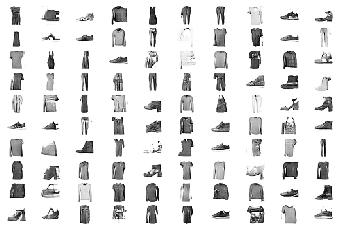

In [15]:
model = load_model('generator.h5')
latent_points = generate_latent_points(100,100)
X = model.predict(latent_points)
show_plot(X,10)